In [1]:
import os
import pandas as pd
import numpy as np
import regex as re
import pysbd
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import datetime
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from datasets import load_dataset
from datasets import load_metric
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from keras.callbacks import TensorBoard
from transformers import BartTokenizer, TFBartForConditionalGeneration
from difflib import SequenceMatcher
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from transformers import AdamWeightDecay
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers.keras_callbacks import KerasMetricCallback
import evaluate
import bert_score
from get_transcripts import get_transcription, semantic_segmentation, extract_features

tqdm.pandas()
nltk.download('punkt')

c:\Users\serix\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\serix\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
DS_path = 'metadata.tsv'
metadata_train = pd.read_csv(DS_path, sep='\t')
print("Columns: ", metadata_train.columns)
print("Shape: ", metadata_train.shape)

Columns:  Index(['show_uri', 'show_name', 'show_description', 'publisher', 'language',
       'rss_link', 'episode_uri', 'episode_name', 'episode_description',
       'duration', 'show_filename_prefix', 'episode_filename_prefix'],
      dtype='object')
Shape:  (105360, 12)


In [9]:
print("Before dropping NaN values: \n", metadata_train.isna().any())
metadata_train.dropna(subset=['episode_description', 'show_description'], inplace=True)
print("\nAfter dropping NaN values:\n", metadata_train.isna().any())

Before dropping NaN values: 
 show_uri                   False
show_name                  False
show_description            True
publisher                  False
language                   False
rss_link                   False
episode_uri                False
episode_name               False
episode_description         True
duration                   False
show_filename_prefix       False
episode_filename_prefix    False
dtype: bool

After dropping NaN values:
 show_uri                   False
show_name                  False
show_description           False
publisher                  False
language                   False
rss_link                   False
episode_uri                False
episode_name               False
episode_description        False
duration                   False
show_filename_prefix       False
episode_filename_prefix    False
dtype: bool


In [10]:
gold_path = '150gold.tsv'
metadata_gold = pd.read_csv(gold_path, sep='\t')
quality = {'B': 1, 'F': 2, 'G': 3, 'E': 4}

egfb_columns = ['EGFB', 'EGFB.1', 'EGFB.2', 'EGFB.3', 'EGFB.4', 'EGFB.5']
egfb_to_quality = metadata_gold[egfb_columns].replace(quality)

egfb_to_quality = egfb_to_quality[egfb_to_quality.gt(1).any(axis=1)]

best_egfb = egfb_to_quality.idxmax(axis=1)

best = metadata_gold.lookup(best_egfb.index, best_egfb)

metadata_gold = metadata_gold.loc[best_egfb.index]
metadata_gold['best_summary'] = best

golden_sum = metadata_gold.set_index('episode id')['best_summary'].to_dict()

In [11]:
for index, row in metadata_train.iterrows():
    if row['episode_uri'] in golden_sum:
        metadata_train.at[index, 'episode_description'] = golden_sum[row['episode_uri']]

In [ ]:
def doc_freq(descriptions):
    seg = pysbd.Segmenter(language="en", clean=False)

    flat_descrip = []
    for description in tqdm(descriptions, desc="Computing word frequencies"):
        description_set = set(word.lower() for sentence in seg.segment(description) for word in word_tokenize(sentence))
        flat_descrip.extend(description_set)
            
    counts = pd.Series(Counter(flat_descrip))
    return counts

doc_freq = doc_freq(metadata_train['episode_description'])

In [ ]:
def remove_dash(description):
    dash_re = re.compile(r"---.*")
    return dash_re.sub("", description)

def remove_link_sponsors(description):
    hashtag_re = re.compile(r"(\B@\w+|\B#\w+)")
    links_sponsors_re = re.compile(
        r"(http|https|[pP]atreon|[eE]mail|[dD]onate|IG|[iI]nstagram|[fF]acebook|[yY]outube|[tT]witter|[dD]iscord|[fF]ollow|[sS]potify)"
    )

    description = hashtag_re.sub(" ", description)
    seg = pysbd.Segmenter(language="en", clean=False)
    sentences = seg.segment(description)
    sentences = [sentence for sentence in sentences if not links_sponsors_re.search(sentence)] 
    return " ".join(sentences)

def remove_emojii(description):
    emojii_re = re.compile(r"[^\x00-\x7F]+")
    return emojii_re.sub(" ", description)

print("Removing dashes from the episode descriptions:")
metadata_train['episode_description'] = metadata_train['episode_description'].progress_map(remove_dash)

print("Removing links and sponsors from the episode descriptions:")
metadata_train['episode_description'] = metadata_train['episode_description'].progress_map(remove_link_sponsors)

print("Removing emojii from the episode descriptions:")
metadata_train['episode_description'] = metadata_train['episode_description'].progress_map(remove_emojii)


Removing dashes from the episode descriptions:


100%|██████████| 105153/105153 [00:00<00:00, 193961.25it/s]


Removing links and sponsors from the episode descriptions:


100%|██████████| 105153/105153 [04:51<00:00, 360.74it/s]


Removing emojii from the episode descriptions:


100%|██████████| 105153/105153 [00:00<00:00, 175506.44it/s]


In [ ]:
def sent_salience(sentence, num_descriptions, doc_freq):
    tokenized_sent = sentence.lower().split()
    stopwords = ['episode', 'podcast']
    relevant = [word for word in tokenized_sent if word.isalpha() and word not in stopwords and len(word) > 1 and word in doc_freq]

    if relevant:
        idf_scores = [np.log(num_descriptions / doc_freq[word]) for word in relevant]
        return np.mean(idf_scores)
    else:
        return 0.0


def remove_unuseful_sent(description, num_descriptions, word_freq):
    seg = pysbd.Segmenter(language="en", clean=False)
    sentences = seg.segment(description)
    
    useful_sent = []
    for sentence in sentences:
        if sent_salience(sentence, num_descriptions, word_freq) > 3.7:
            useful_sent.append(sentence)
    
    return " ".join(useful_sent)

metadata_train['episode_description'] = metadata_train['episode_description'].progress_map(
    lambda x: remove_unuseful_sent(x, metadata_train.shape[0], doc_freq)
)

100%|██████████| 105153/105153 [20:42<00:00, 84.61it/s] 


In [ ]:
def check_length(episode, max=700, min=50):
    length = len(episode['episode_description'])
    if min <= length <= max:
        return True
    else:
        return False
    
def descrip_similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()

def show_descrip_similarity(episode):
    similarity_score = descrip_similarity(episode['show_description'], episode['episode_description'])
    if similarity_score < 0.6:
        return True
    else:
        return False
    
def check_other_description_overlap(episode, show_episodes):
    for other_prefix, other_description in show_episodes[episode['show_filename_prefix']]:
        if other_prefix != episode['episode_filename_prefix'] and descrip_similarity(episode['episode_description'], other_description) > 0.7 and len(episode['episode_description']) < len(other_description):
            return False
    return True


reduced_length = metadata_train[metadata_train.progress_apply(check_length, axis=1)]
print(f"Removed {len(metadata_train) - len(reduced_length)} episodes ({(100-(len(reduced_length)/len(metadata_train)*100)):.2f}%) because of too long or too short descriptions")

reduced_overlap = reduced_length[reduced_length.progress_apply(show_descrip_similarity, axis=1)]
print(f"Removed {len(reduced_length) - len(reduced_overlap)} episodes ({(100-(len(reduced_overlap)/len(reduced_length)*100)):.2f}%) because of too high overlap with the show description")

show_episodes = reduced_overlap.groupby(['show_filename_prefix']).apply(lambda x: list(zip(x['episode_filename_prefix'], x['episode_description']))).to_dict()
reduced_set = reduced_overlap[reduced_overlap.progress_apply(lambda x: check_other_description_overlap(x, show_episodes), axis=1)]
print(f"Removed {len(reduced_overlap) - len(reduced_set)} episodes ({(100-(len(reduced_set)/len(reduced_overlap)*100)):.2f}%) because of too high overlap with other descriptions in the same show")

100%|██████████| 105153/105153 [00:00<00:00, 162738.93it/s]


Removed 23782 episodes (22.62%) because of too long or too short descriptions


100%|██████████| 81371/81371 [00:46<00:00, 1752.90it/s]


Removed 967 episodes (1.19%) because of too high overlap with the show description


100%|██████████| 80404/80404 [28:43<00:00, 46.64it/s]  

Removed 5469 episodes (6.80%) because of too high overlap with other descriptions in the same show


In [ ]:
nltk.download('words')
wordset = set(words.words())
def is_english(text):
    tokenized = word_tokenize(text)
    alpha_token = [word.lower() for word in tokenized if word.isalpha()]
    score = sum([word.lower() in wordset for word in alpha_token
                           ]) / len(alpha_token)
    return score > 0.3


old_length = len(reduced_set)
reduced_set = reduced_set[reduced_set.progress_apply(lambda x: is_english(x['episode_description']), axis=1)]
print(f"Removed {old_length - len(reduced_set)} episodes ({(100-(len(reduced_set)/old_length*100)):.2f}%) because of non english description")

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\serix\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.
100%|██████████| 74935/74935 [00:19<00:00, 3811.54it/s]

Removed 254 episodes (0.34%) because of non english description


In [ ]:
reduced_set.to_csv("reduced_set.tsv", index=False, sep='\t')
new_set = pd.read_csv("new_set.tsv", sep='\t')

In [ ]:
def transcript_filtering(episode, chunk_model, sent_encoder, tokenizer, test_set=False):
    chunks = semantic_segmentation(get_transcription(episode, DS_path, test_set), sent_encoder)
    features = np.array([extract_features(chunk, sent_encoder) for chunk in chunks])
    y = chunk_model.predict(features)

    scores = [{'idx': i, 'relevance':y[i]} for i in range(len(chunks))]
    scores.sort(key=lambda e: e['relevance'], reverse=True)

    count = 0
    i = 0
    max_tokens = 1024
    while count <= max_tokens and i < len(scores):
        count += len(tokenizer(' '.join(chunks[scores[i]['idx']]))['input_ids'])
        i += 1
    if i == len(scores):
        relevant = [' '.join(chunk) for chunk in chunks]
    else:
        selected = {scores[j]['idx']: chunks[scores[j]['idx']] for j in range(i-1)}
        relevant = [' '.join(chunks[idx]) for idx in sorted(selected.keys())]

    return ' '.join(relevant)

DS_path = os.path.abspath("")
chunk_model = load_model("ChunkModel.h5")
BART_model = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(BART_model)
sent_encoder = SentenceTransformer('all-MiniLM-L6-v2')

new_set['filtered_transcript'] = new_set.progress_apply(lambda x: transcript_filtering(x, chunk_model, sent_encoder, tokenizer), axis=1)

new_set[['episode_uri','filtered_transcript', 'episode_description']].to_csv(os.path.join(DS_path, "filtered_set.csv"), index=False)

  0%|          | 0/2761 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  0%|          | 2/2761 [00:02<1:05:17,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  0%|          | 3/2761 [00:04<1:08:11,  1.48s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 4/2761 [00:17<4:22:01,  5.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 5/2761 [00:32<6:52:19,  8.98s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 6/2761 [00:44<7:34:54,  9.91s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 7/2761 [00:50<6:41:10,  8.74s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 8/2761 [00:57<6:19:00,  8.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 9/2761 [01:12<7:52:09, 10.29s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 10/2761 [01:21<7:39:37, 10.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|          | 11/2761 [01:26<6:18:27,  8.26s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  0%|          | 12/2761 [01:30<5:25:24,  7.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|          | 13/2761 [01:31<3:58:36,  5.21s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|          | 14/2761 [01:53<7:59:15, 10.47s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|          | 15/2761 [02:05<8:20:02, 10.93s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|          | 16/2761 [02:12<7:23:17,  9.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|          | 17/2761 [02:27<8:36:22, 11.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|          | 18/2761 [02:44<9:53:44, 12.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|          | 19/2761 [02:49<7:56:27, 10.43s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  1%|          | 20/2761 [02:58<7:35:24,  9.97s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  1%|          | 21/2761 [03:04<6:49:16,  8.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|          | 22/2761 [03:19<8:02:12, 10.56s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  1%|          | 23/2761 [03:39<10:20:30, 13.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|          | 24/2761 [03:53<10:16:48, 13.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|          | 25/2761 [03:55<7:39:34, 10.08s/it] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|          | 26/2761 [03:57<5:54:36,  7.78s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|          | 27/2761 [04:04<5:46:51,  7.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|          | 28/2761 [04:20<7:37:05, 10.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|          | 29/2761 [04:22<5:51:00,  7.71s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|          | 30/2761 [04:30<5:46:24,  7.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|          | 31/2761 [04:31<4:23:06,  5.78s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  1%|          | 32/2761 [04:41<5:12:50,  6.88s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  1%|          | 33/2761 [04:53<6:25:02,  8.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|          | 34/2761 [05:08<7:59:12, 10.54s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  1%|▏         | 35/2761 [05:15<7:07:34,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|▏         | 36/2761 [05:31<8:32:57, 11.29s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|▏         | 37/2761 [05:40<8:13:04, 10.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▏         | 38/2761 [05:43<6:23:33,  8.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  1%|▏         | 39/2761 [05:59<7:56:34, 10.51s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|▏         | 40/2761 [06:06<7:13:27,  9.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▏         | 41/2761 [06:07<5:19:10,  7.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|▏         | 42/2761 [06:10<4:26:31,  5.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 43/2761 [06:10<3:09:03,  4.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|▏         | 44/2761 [06:13<2:44:28,  3.63s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 45/2761 [06:20<3:39:36,  4.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|▏         | 46/2761 [06:23<3:08:44,  4.17s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 47/2761 [06:31<3:59:34,  5.30s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  2%|▏         | 48/2761 [06:38<4:16:35,  5.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 49/2761 [06:42<4:04:24,  5.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 50/2761 [06:57<6:05:01,  8.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 51/2761 [06:58<4:40:17,  6.21s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 52/2761 [07:21<8:23:40, 11.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 53/2761 [07:24<6:32:52,  8.70s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 54/2761 [07:43<8:53:49, 11.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|▏         | 55/2761 [07:45<6:41:55,  8.91s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 56/2761 [07:58<7:30:08,  9.98s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 57/2761 [08:06<6:59:44,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 58/2761 [08:20<8:08:09, 10.84s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 59/2761 [08:26<6:59:43,  9.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|▏         | 60/2761 [08:27<5:04:15,  6.76s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 61/2761 [08:34<5:06:47,  6.82s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 62/2761 [08:38<4:38:51,  6.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 63/2761 [08:39<3:29:49,  4.67s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 64/2761 [08:51<5:08:19,  6.86s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 65/2761 [08:58<5:08:47,  6.87s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 66/2761 [09:08<5:48:02,  7.75s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 67/2761 [09:19<6:25:41,  8.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  2%|▏         | 68/2761 [09:34<7:55:32, 10.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  2%|▏         | 69/2761 [09:50<9:12:13, 12.31s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 70/2761 [10:04<9:27:04, 12.64s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  3%|▎         | 71/2761 [10:12<8:29:18, 11.36s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 72/2761 [10:16<6:55:20,  9.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 73/2761 [10:22<6:07:57,  8.21s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 74/2761 [10:32<6:30:52,  8.73s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  3%|▎         | 75/2761 [10:40<6:26:25,  8.63s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  3%|▎         | 76/2761 [10:51<6:46:16,  9.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|▎         | 77/2761 [10:53<5:16:44,  7.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  3%|▎         | 78/2761 [11:06<6:40:01,  8.95s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 79/2761 [11:19<7:27:30, 10.01s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 80/2761 [11:30<7:49:38, 10.51s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 81/2761 [11:42<7:58:27, 10.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 82/2761 [11:44<6:06:49,  8.22s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 83/2761 [11:49<5:28:57,  7.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|▎         | 84/2761 [11:53<4:43:36,  6.36s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 85/2761 [12:13<7:38:51, 10.29s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 86/2761 [12:34<10:07:24, 13.62s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 87/2761 [12:42<8:48:58, 11.87s/it] 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 88/2761 [13:03<10:43:35, 14.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|▎         | 89/2761 [13:07<8:30:14, 11.46s/it] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|▎         | 90/2761 [13:09<6:30:13,  8.77s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 91/2761 [13:14<5:39:43,  7.63s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  3%|▎         | 92/2761 [13:21<5:22:25,  7.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 93/2761 [13:22<4:03:08,  5.47s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 94/2761 [13:29<4:20:17,  5.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 95/2761 [13:32<3:48:59,  5.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 96/2761 [13:46<5:35:56,  7.56s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▎         | 97/2761 [13:55<6:00:05,  8.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|▎         | 98/2761 [13:56<4:21:51,  5.90s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▎         | 99/2761 [14:17<7:46:33, 10.52s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▎         | 100/2761 [14:23<6:51:12,  9.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|▎         | 101/2761 [14:24<4:53:22,  6.62s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  4%|▎         | 102/2761 [14:35<5:54:53,  8.01s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▎         | 103/2761 [14:45<6:17:16,  8.52s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  4%|▍         | 104/2761 [15:10<10:04:44, 13.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 105/2761 [15:14<7:55:04, 10.73s/it] 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 106/2761 [15:23<7:26:16, 10.09s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 107/2761 [15:30<6:49:58,  9.27s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  4%|▍         | 108/2761 [15:49<8:54:08, 12.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|▍         | 109/2761 [15:51<6:46:46,  9.20s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  4%|▍         | 110/2761 [16:14<9:40:52, 13.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 111/2761 [16:29<10:02:31, 13.64s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  4%|▍         | 112/2761 [16:57<13:12:02, 17.94s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 113/2761 [17:06<11:16:54, 15.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|▍         | 114/2761 [17:07<8:08:38, 11.08s/it] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 115/2761 [17:09<6:13:48,  8.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|▍         | 116/2761 [17:10<4:33:16,  6.20s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  4%|▍         | 117/2761 [17:20<5:14:35,  7.14s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 118/2761 [17:32<6:20:01,  8.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|▍         | 119/2761 [17:35<5:14:31,  7.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|▍         | 120/2761 [17:39<4:29:16,  6.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  4%|▍         | 121/2761 [17:54<6:21:57,  8.68s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 122/2761 [18:12<8:26:30, 11.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|▍         | 123/2761 [18:14<6:22:37,  8.70s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 124/2761 [18:25<6:51:45,  9.37s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▍         | 125/2761 [18:32<6:16:33,  8.57s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▍         | 126/2761 [18:36<5:22:35,  7.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|▍         | 127/2761 [18:38<4:05:09,  5.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▍         | 128/2761 [18:38<3:02:34,  4.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▍         | 129/2761 [18:42<2:58:47,  4.08s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  5%|▍         | 130/2761 [18:47<3:07:55,  4.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▍         | 131/2761 [19:03<5:35:13,  7.65s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  5%|▍         | 132/2761 [19:09<5:20:43,  7.32s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▍         | 133/2761 [19:22<6:36:18,  9.05s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  5%|▍         | 134/2761 [19:34<7:07:49,  9.77s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▍         | 135/2761 [19:46<7:36:37, 10.43s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▍         | 136/2761 [19:56<7:41:42, 10.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▍         | 137/2761 [19:59<5:50:36,  8.02s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  5%|▍         | 138/2761 [20:06<5:48:10,  7.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▌         | 139/2761 [20:09<4:42:45,  6.47s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▌         | 140/2761 [20:16<4:41:05,  6.43s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  5%|▌         | 141/2761 [20:42<8:59:27, 12.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▌         | 142/2761 [20:57<9:31:02, 13.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  5%|▌         | 143/2761 [21:16<10:52:26, 14.95s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▌         | 144/2761 [21:24<9:16:45, 12.76s/it] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|▌         | 145/2761 [21:27<7:13:12,  9.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▌         | 146/2761 [21:42<8:20:09, 11.48s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▌         | 147/2761 [21:54<8:23:41, 11.56s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▌         | 148/2761 [22:00<7:18:20, 10.07s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▌         | 149/2761 [22:08<6:49:04,  9.40s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  5%|▌         | 150/2761 [22:14<6:06:37,  8.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▌         | 151/2761 [22:16<4:42:19,  6.49s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 152/2761 [22:27<5:30:01,  7.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 153/2761 [22:46<8:05:29, 11.17s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  6%|▌         | 154/2761 [22:54<7:22:47, 10.19s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  6%|▌         | 155/2761 [23:11<8:55:57, 12.34s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 156/2761 [23:16<7:16:18, 10.05s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 157/2761 [23:28<7:36:04, 10.51s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 158/2761 [23:36<7:12:13,  9.96s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 159/2761 [23:44<6:48:27,  9.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|▌         | 160/2761 [23:47<5:19:33,  7.37s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 161/2761 [23:54<5:20:18,  7.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|▌         | 162/2761 [23:55<3:50:12,  5.31s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  6%|▌         | 163/2761 [24:00<3:49:52,  5.31s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 164/2761 [24:07<4:08:52,  5.75s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  6%|▌         | 165/2761 [24:14<4:19:06,  5.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|▌         | 166/2761 [24:17<3:40:58,  5.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|▌         | 167/2761 [24:17<2:42:29,  3.76s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 168/2761 [24:22<3:01:42,  4.20s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 169/2761 [24:30<3:38:30,  5.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|▌         | 170/2761 [24:32<3:04:35,  4.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  6%|▌         | 171/2761 [24:39<3:45:09,  5.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▌         | 172/2761 [24:41<3:03:16,  4.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  6%|▋         | 173/2761 [24:55<5:05:00,  7.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▋         | 174/2761 [24:57<3:54:57,  5.45s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▋         | 175/2761 [25:04<4:13:46,  5.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|▋         | 176/2761 [25:05<3:12:23,  4.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▋         | 177/2761 [25:22<5:54:41,  8.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|▋         | 178/2761 [25:25<4:51:12,  6.76s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▋         | 179/2761 [25:38<6:14:39,  8.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  7%|▋         | 180/2761 [25:57<8:24:37, 11.73s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 181/2761 [26:10<8:33:34, 11.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|▋         | 182/2761 [26:14<6:53:12,  9.61s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 183/2761 [26:21<6:26:27,  8.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|▋         | 184/2761 [26:24<5:11:02,  7.24s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


  7%|▋         | 185/2761 [26:29<4:36:16,  6.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|▋         | 186/2761 [26:30<3:30:20,  4.90s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 187/2761 [26:37<3:49:53,  5.36s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  7%|▋         | 188/2761 [26:48<4:59:43,  6.99s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  7%|▋         | 189/2761 [26:55<5:11:36,  7.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  7%|▋         | 190/2761 [26:58<4:09:38,  5.83s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  7%|▋         | 191/2761 [27:07<4:46:55,  6.70s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 192/2761 [27:19<5:54:28,  8.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|▋         | 193/2761 [27:21<4:44:47,  6.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 194/2761 [27:35<6:18:14,  8.84s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  7%|▋         | 195/2761 [27:46<6:46:18,  9.50s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 196/2761 [28:00<7:41:37, 10.80s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  7%|▋         | 197/2761 [28:08<6:58:00,  9.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|▋         | 198/2761 [28:09<5:14:42,  7.37s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 199/2761 [28:20<5:55:05,  8.32s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 200/2761 [28:32<6:36:46,  9.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|▋         | 201/2761 [28:33<4:59:15,  7.01s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 202/2761 [28:40<4:53:30,  6.88s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  7%|▋         | 203/2761 [29:04<8:31:20, 11.99s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 204/2761 [29:14<8:02:39, 11.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 205/2761 [29:14<5:41:38,  8.02s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 206/2761 [29:22<5:41:58,  8.03s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 207/2761 [29:28<5:17:50,  7.47s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  8%|▊         | 208/2761 [29:49<8:04:54, 11.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|▊         | 209/2761 [29:51<6:06:53,  8.63s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 210/2761 [30:12<8:44:26, 12.34s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 211/2761 [30:24<8:43:28, 12.32s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 212/2761 [30:46<10:41:05, 15.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|▊         | 213/2761 [30:47<7:47:34, 11.01s/it] 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 214/2761 [31:04<9:03:48, 12.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|▊         | 215/2761 [31:07<6:58:52,  9.87s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 216/2761 [31:14<6:26:57,  9.12s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 217/2761 [31:27<7:09:19, 10.13s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  8%|▊         | 218/2761 [31:41<7:54:19, 11.19s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  8%|▊         | 219/2761 [32:05<10:35:51, 15.01s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  8%|▊         | 220/2761 [32:15<9:40:21, 13.70s/it] 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  8%|▊         | 221/2761 [32:28<9:27:58, 13.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 222/2761 [32:42<9:38:34, 13.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  8%|▊         | 223/2761 [32:44<7:02:48, 10.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  8%|▊         | 224/2761 [33:00<8:23:47, 11.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 225/2761 [33:03<6:24:36,  9.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|▊         | 226/2761 [33:03<4:38:52,  6.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|▊         | 227/2761 [33:04<3:22:57,  4.81s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 228/2761 [33:10<3:43:28,  5.29s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 229/2761 [33:17<4:01:01,  5.71s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 230/2761 [33:30<5:36:44,  7.98s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  8%|▊         | 231/2761 [33:55<9:03:00, 12.88s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 232/2761 [34:06<8:47:20, 12.51s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  8%|▊         | 233/2761 [34:14<7:46:31, 11.07s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 234/2761 [34:20<6:44:38,  9.61s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▊         | 235/2761 [34:25<5:48:52,  8.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|▊         | 236/2761 [34:27<4:21:00,  6.20s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▊         | 237/2761 [34:41<6:02:04,  8.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|▊         | 238/2761 [34:43<4:43:59,  6.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|▊         | 239/2761 [34:44<3:25:09,  4.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▊         | 240/2761 [34:59<5:34:28,  7.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|▊         | 241/2761 [35:00<4:05:37,  5.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 242/2761 [35:14<5:52:23,  8.39s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 243/2761 [35:19<5:02:11,  7.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 244/2761 [35:33<6:32:53,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  9%|▉         | 245/2761 [35:50<8:02:23, 11.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|▉         | 246/2761 [35:50<5:45:21,  8.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|▉         | 247/2761 [35:52<4:25:05,  6.33s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 248/2761 [35:57<4:06:33,  5.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 249/2761 [36:13<6:11:16,  8.87s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 250/2761 [36:20<5:46:20,  8.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▉         | 251/2761 [36:21<4:24:04,  6.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 252/2761 [36:38<6:32:05,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 253/2761 [36:56<8:15:35, 11.86s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  9%|▉         | 254/2761 [37:06<7:56:39, 11.41s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  9%|▉         | 255/2761 [37:18<8:00:42, 11.51s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  9%|▉         | 256/2761 [37:28<7:44:33, 11.13s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 257/2761 [37:37<7:22:59, 10.62s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 258/2761 [37:47<7:07:36, 10.25s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 259/2761 [38:00<7:42:08, 11.08s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  9%|▉         | 260/2761 [38:09<7:12:55, 10.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|▉         | 261/2761 [38:13<5:56:54,  8.57s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 262/2761 [38:19<5:27:34,  7.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|▉         | 263/2761 [38:22<4:28:26,  6.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 10%|▉         | 264/2761 [38:37<6:13:17,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 10%|▉         | 265/2761 [38:52<7:29:19, 10.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|▉         | 266/2761 [38:52<5:18:37,  7.66s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|▉         | 267/2761 [39:02<5:37:39,  8.12s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|▉         | 268/2761 [39:06<4:48:32,  6.94s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|▉         | 269/2761 [39:16<5:21:50,  7.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|▉         | 270/2761 [39:16<3:55:10,  5.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|▉         | 271/2761 [39:22<3:49:15,  5.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|▉         | 272/2761 [39:24<3:13:42,  4.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 10%|▉         | 273/2761 [39:39<5:17:12,  7.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|▉         | 274/2761 [39:58<7:37:58, 11.05s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|▉         | 275/2761 [40:06<7:01:28, 10.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|▉         | 276/2761 [40:10<5:48:58,  8.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|█         | 277/2761 [40:26<7:25:08, 10.75s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|█         | 278/2761 [40:35<6:55:00, 10.03s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|█         | 279/2761 [40:43<6:31:47,  9.47s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|█         | 280/2761 [40:48<5:34:55,  8.10s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|█         | 281/2761 [41:07<7:55:19, 11.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|█         | 282/2761 [41:08<5:43:53,  8.32s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|█         | 283/2761 [41:14<5:09:05,  7.48s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|█         | 284/2761 [41:24<5:45:33,  8.37s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|█         | 285/2761 [41:35<6:20:14,  9.21s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|█         | 286/2761 [41:44<6:08:01,  8.92s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 10%|█         | 287/2761 [41:54<6:23:35,  9.30s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 10%|█         | 288/2761 [42:04<6:38:35,  9.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 10%|█         | 289/2761 [42:05<4:47:57,  6.99s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 290/2761 [42:14<5:11:31,  7.56s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 291/2761 [42:23<5:29:20,  8.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|█         | 292/2761 [42:25<4:17:48,  6.27s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 293/2761 [42:36<5:13:52,  7.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|█         | 294/2761 [42:38<4:01:48,  5.88s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 11%|█         | 295/2761 [42:48<4:52:48,  7.12s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 296/2761 [42:55<4:53:56,  7.15s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 297/2761 [43:02<4:50:11,  7.07s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 298/2761 [43:09<4:51:37,  7.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|█         | 299/2761 [43:09<3:28:30,  5.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 11%|█         | 300/2761 [43:25<5:38:40,  8.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|█         | 301/2761 [43:29<4:40:28,  6.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|█         | 302/2761 [43:31<3:49:31,  5.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 303/2761 [43:49<6:21:37,  9.32s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 304/2761 [43:56<5:47:48,  8.49s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 305/2761 [44:06<6:13:06,  9.12s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 306/2761 [44:15<6:02:09,  8.85s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 11%|█         | 307/2761 [44:32<7:47:39, 11.43s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 308/2761 [44:58<10:44:45, 15.77s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 309/2761 [45:07<9:15:05, 13.58s/it] 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 11%|█         | 310/2761 [45:20<9:16:21, 13.62s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█▏        | 311/2761 [45:29<8:21:26, 12.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|█▏        | 312/2761 [45:32<6:22:30,  9.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|█▏        | 313/2761 [45:35<5:03:55,  7.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█▏        | 314/2761 [45:50<6:37:28,  9.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█▏        | 315/2761 [46:03<7:17:19, 10.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|█▏        | 316/2761 [46:04<5:13:19,  7.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|█▏        | 317/2761 [46:06<4:03:55,  5.99s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 12%|█▏        | 318/2761 [46:14<4:29:02,  6.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|█▏        | 319/2761 [46:15<3:17:43,  4.86s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 320/2761 [46:20<3:28:40,  5.13s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 321/2761 [46:27<3:49:26,  5.64s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 322/2761 [46:32<3:45:27,  5.55s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 323/2761 [46:51<6:20:42,  9.37s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 324/2761 [46:59<6:11:32,  9.15s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 325/2761 [47:06<5:44:22,  8.48s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 326/2761 [47:15<5:43:42,  8.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|█▏        | 327/2761 [47:16<4:13:17,  6.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 12%|█▏        | 328/2761 [47:32<6:10:19,  9.13s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 329/2761 [47:39<5:48:49,  8.61s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 330/2761 [47:45<5:21:59,  7.95s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 12%|█▏        | 331/2761 [47:56<5:57:13,  8.82s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 332/2761 [48:03<5:27:55,  8.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|█▏        | 333/2761 [48:03<3:53:57,  5.78s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 12%|█▏        | 334/2761 [48:11<4:23:39,  6.52s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 12%|█▏        | 335/2761 [48:36<8:09:36, 12.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|█▏        | 336/2761 [48:37<5:51:45,  8.70s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 337/2761 [48:44<5:26:03,  8.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 338/2761 [48:58<6:36:38,  9.82s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 339/2761 [49:11<7:21:25, 10.94s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 340/2761 [49:18<6:33:00,  9.74s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 341/2761 [49:24<5:40:08,  8.43s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 342/2761 [49:36<6:25:19,  9.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 343/2761 [49:52<7:51:20, 11.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|█▏        | 344/2761 [49:56<6:10:50,  9.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|█▏        | 345/2761 [49:59<4:52:41,  7.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 346/2761 [50:06<4:50:08,  7.21s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 347/2761 [50:11<4:21:25,  6.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 348/2761 [50:26<6:06:10,  9.10s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 349/2761 [50:38<6:40:06,  9.95s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 350/2761 [50:42<5:27:36,  8.15s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 351/2761 [50:46<4:47:41,  7.16s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 352/2761 [50:56<5:16:35,  7.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 353/2761 [51:09<6:19:23,  9.45s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 354/2761 [51:15<5:34:43,  8.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 355/2761 [51:30<6:59:41, 10.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█▎        | 356/2761 [51:31<5:05:10,  7.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█▎        | 357/2761 [51:35<4:20:19,  6.50s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 358/2761 [51:41<4:07:44,  6.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█▎        | 359/2761 [51:43<3:25:26,  5.13s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 13%|█▎        | 360/2761 [51:51<3:59:53,  5.99s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 361/2761 [51:57<3:56:43,  5.92s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 362/2761 [52:04<4:04:26,  6.11s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 363/2761 [52:10<4:02:05,  6.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 13%|█▎        | 364/2761 [52:27<6:23:05,  9.59s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 13%|█▎        | 365/2761 [52:38<6:31:39,  9.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█▎        | 366/2761 [52:40<4:56:56,  7.44s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 13%|█▎        | 367/2761 [53:00<7:35:11, 11.41s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 368/2761 [53:06<6:25:10,  9.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 13%|█▎        | 369/2761 [53:08<5:00:31,  7.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█▎        | 370/2761 [53:09<3:36:47,  5.44s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 371/2761 [53:32<7:12:17, 10.85s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 13%|█▎        | 372/2761 [53:44<7:21:42, 11.09s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 14%|█▎        | 373/2761 [53:48<5:53:08,  8.87s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 14%|█▎        | 374/2761 [54:13<9:09:43, 13.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 14%|█▎        | 375/2761 [54:14<6:34:54,  9.93s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▎        | 376/2761 [54:22<6:13:42,  9.40s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▎        | 377/2761 [54:29<5:43:27,  8.64s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▎        | 378/2761 [54:38<5:52:01,  8.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 14%|█▎        | 379/2761 [54:54<7:08:55, 10.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▍        | 380/2761 [54:54<5:01:21,  7.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█▍        | 381/2761 [54:56<3:58:52,  6.02s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 14%|█▍        | 382/2761 [55:07<4:50:04,  7.32s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 383/2761 [55:14<4:53:46,  7.41s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 14%|█▍        | 384/2761 [55:35<7:34:35, 11.47s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 385/2761 [55:45<7:14:53, 10.98s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 14%|█▍        | 386/2761 [56:09<9:43:56, 14.75s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 14%|█▍        | 387/2761 [56:16<8:15:50, 12.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 388/2761 [56:31<8:43:11, 13.23s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 389/2761 [56:36<7:10:55, 10.90s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 390/2761 [56:47<7:05:20, 10.76s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 14%|█▍        | 391/2761 [57:12<9:56:25, 15.10s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 14%|█▍        | 392/2761 [57:36<11:43:53, 17.83s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 14%|█▍        | 393/2761 [57:42<9:27:32, 14.38s/it] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|█▍        | 394/2761 [57:46<7:14:51, 11.02s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 14%|█▍        | 395/2761 [58:03<8:34:26, 13.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█▍        | 396/2761 [58:06<6:31:16,  9.93s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 397/2761 [58:14<6:11:06,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 398/2761 [58:32<7:54:08, 12.04s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 399/2761 [58:53<9:36:38, 14.65s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 400/2761 [59:01<8:11:12, 12.48s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▍        | 401/2761 [59:10<7:32:27, 11.50s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 15%|█▍        | 402/2761 [59:35<10:17:06, 15.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 15%|█▍        | 403/2761 [59:50<10:03:57, 15.37s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 15%|█▍        | 404/2761 [59:55<8:00:46, 12.24s/it] 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▍        | 405/2761 [1:00:05<7:41:57, 11.76s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▍        | 406/2761 [1:00:12<6:43:26, 10.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|█▍        | 407/2761 [1:00:17<5:38:24,  8.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|█▍        | 408/2761 [1:00:19<4:21:09,  6.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|█▍        | 409/2761 [1:00:21<3:28:06,  5.31s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▍        | 410/2761 [1:00:25<3:14:19,  4.96s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▍        | 411/2761 [1:00:46<6:14:59,  9.57s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▍        | 412/2761 [1:00:52<5:40:44,  8.70s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▍        | 413/2761 [1:00:58<5:08:03,  7.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|█▍        | 414/2761 [1:01:02<4:13:47,  6.49s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▌        | 415/2761 [1:01:08<4:13:26,  6.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 15%|█▌        | 416/2761 [1:01:23<5:55:35,  9.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|█▌        | 417/2761 [1:01:25<4:28:46,  6.88s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▌        | 418/2761 [1:01:33<4:41:33,  7.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|█▌        | 419/2761 [1:01:34<3:26:33,  5.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|█▌        | 420/2761 [1:01:36<2:50:48,  4.38s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▌        | 421/2761 [1:01:43<3:21:59,  5.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|█▌        | 422/2761 [1:01:45<2:49:07,  4.34s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▌        | 423/2761 [1:01:57<4:18:39,  6.64s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▌        | 424/2761 [1:02:07<4:58:17,  7.66s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▌        | 425/2761 [1:02:28<7:24:35, 11.42s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 15%|█▌        | 426/2761 [1:02:38<7:13:38, 11.14s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▌        | 427/2761 [1:02:51<7:31:15, 11.60s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 428/2761 [1:02:57<6:23:36,  9.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|█▌        | 429/2761 [1:03:00<5:04:08,  7.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 430/2761 [1:03:14<6:23:30,  9.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|█▌        | 431/2761 [1:03:18<5:14:31,  8.10s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 432/2761 [1:03:31<6:09:48,  9.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|█▌        | 433/2761 [1:03:32<4:31:37,  7.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|█▌        | 434/2761 [1:03:35<3:40:32,  5.69s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 435/2761 [1:03:41<3:49:56,  5.93s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 436/2761 [1:04:03<6:52:23, 10.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|█▌        | 437/2761 [1:04:05<5:13:48,  8.10s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 438/2761 [1:04:11<4:44:42,  7.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|█▌        | 439/2761 [1:04:11<3:25:22,  5.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|█▌        | 440/2761 [1:04:14<2:59:48,  4.65s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 16%|█▌        | 441/2761 [1:04:38<6:35:19, 10.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 16%|█▌        | 442/2761 [1:04:51<7:12:58, 11.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|█▌        | 443/2761 [1:04:55<5:47:08,  8.99s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 16%|█▌        | 444/2761 [1:05:19<8:44:17, 13.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|█▌        | 445/2761 [1:05:22<6:42:43, 10.43s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 16%|█▌        | 446/2761 [1:05:27<5:37:43,  8.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 16%|█▌        | 447/2761 [1:05:41<6:32:01, 10.17s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 448/2761 [1:05:48<6:01:59,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▋        | 449/2761 [1:06:04<7:11:55, 11.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|█▋        | 450/2761 [1:06:07<5:36:49,  8.75s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 16%|█▋        | 451/2761 [1:06:26<7:41:06, 11.98s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 16%|█▋        | 452/2761 [1:06:37<7:27:21, 11.62s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▋        | 453/2761 [1:06:44<6:34:37, 10.26s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 16%|█▋        | 454/2761 [1:07:03<8:17:08, 12.93s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▋        | 455/2761 [1:07:11<7:15:30, 11.33s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 17%|█▋        | 456/2761 [1:07:36<9:58:42, 15.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 457/2761 [1:07:51<9:43:56, 15.21s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 458/2761 [1:07:58<8:12:37, 12.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|█▋        | 459/2761 [1:08:02<6:30:37, 10.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 460/2761 [1:08:02<4:36:37,  7.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|█▋        | 461/2761 [1:08:04<3:37:15,  5.67s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 462/2761 [1:08:14<4:23:45,  6.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 463/2761 [1:08:30<6:09:53,  9.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 464/2761 [1:08:35<5:11:59,  8.15s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 465/2761 [1:08:46<5:45:57,  9.04s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 466/2761 [1:08:56<5:53:35,  9.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█▋        | 467/2761 [1:08:56<4:13:29,  6.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█▋        | 468/2761 [1:08:59<3:29:18,  5.48s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 469/2761 [1:09:11<4:45:52,  7.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 17%|█▋        | 470/2761 [1:09:25<5:52:56,  9.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█▋        | 471/2761 [1:09:26<4:18:17,  6.77s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 17%|█▋        | 472/2761 [1:09:46<6:50:12, 10.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 473/2761 [1:10:00<7:32:39, 11.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|█▋        | 474/2761 [1:10:02<5:33:49,  8.76s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 475/2761 [1:10:06<4:44:37,  7.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|█▋        | 476/2761 [1:10:07<3:27:53,  5.46s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 477/2761 [1:10:35<7:51:05, 12.38s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 478/2761 [1:10:40<6:23:16, 10.07s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 479/2761 [1:10:49<6:15:53,  9.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|█▋        | 480/2761 [1:10:53<5:09:07,  8.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 17%|█▋        | 481/2761 [1:11:08<6:27:20, 10.19s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 482/2761 [1:11:15<5:45:43,  9.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|█▋        | 483/2761 [1:11:18<4:33:47,  7.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 484/2761 [1:11:32<5:57:12,  9.41s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 485/2761 [1:11:37<5:06:47,  8.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█▊        | 486/2761 [1:11:39<3:49:48,  6.06s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 18%|█▊        | 487/2761 [1:12:08<8:17:35, 13.13s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 18%|█▊        | 488/2761 [1:12:29<9:38:26, 15.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 489/2761 [1:12:36<8:06:14, 12.84s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 18%|█▊        | 490/2761 [1:12:54<9:04:45, 14.39s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 491/2761 [1:13:00<7:28:03, 11.84s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 18%|█▊        | 492/2761 [1:13:12<7:32:42, 11.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█▊        | 493/2761 [1:13:14<5:38:49,  8.96s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 494/2761 [1:13:20<5:04:11,  8.05s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 495/2761 [1:13:40<7:26:51, 11.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 18%|█▊        | 496/2761 [1:13:57<8:24:10, 13.36s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 18%|█▊        | 497/2761 [1:14:21<10:20:26, 16.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 498/2761 [1:14:27<8:27:17, 13.45s/it] 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 499/2761 [1:14:36<7:30:27, 11.95s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 18%|█▊        | 500/2761 [1:14:55<8:49:02, 14.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 501/2761 [1:14:59<6:55:56, 11.04s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 502/2761 [1:15:06<6:07:17,  9.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 18%|█▊        | 503/2761 [1:15:20<6:54:18, 11.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█▊        | 504/2761 [1:15:21<5:03:08,  8.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█▊        | 505/2761 [1:15:21<3:35:11,  5.72s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 506/2761 [1:15:26<3:31:43,  5.63s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 507/2761 [1:15:33<3:37:14,  5.78s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


 18%|█▊        | 508/2761 [1:15:40<3:50:37,  6.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█▊        | 509/2761 [1:15:40<2:44:29,  4.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 510/2761 [1:15:57<5:07:30,  8.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|█▊        | 511/2761 [1:15:58<3:46:20,  6.04s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▊        | 512/2761 [1:16:03<3:36:17,  5.77s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▊        | 513/2761 [1:16:11<4:03:30,  6.50s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 19%|█▊        | 514/2761 [1:16:31<6:33:33, 10.51s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▊        | 515/2761 [1:16:35<5:20:25,  8.56s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▊        | 516/2761 [1:16:39<4:28:54,  7.19s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▊        | 517/2761 [1:16:49<5:00:33,  8.04s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 518/2761 [1:17:07<6:48:58, 10.94s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 19%|█▉        | 519/2761 [1:17:28<8:44:30, 14.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 520/2761 [1:17:45<9:15:36, 14.88s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 521/2761 [1:18:06<10:21:54, 16.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 522/2761 [1:18:11<8:17:48, 13.34s/it] 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 523/2761 [1:18:24<8:14:31, 13.26s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 19%|█▉        | 524/2761 [1:18:43<9:11:08, 14.78s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 525/2761 [1:18:55<8:37:37, 13.89s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 19%|█▉        | 526/2761 [1:19:02<7:26:33, 11.99s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 527/2761 [1:19:23<9:01:04, 14.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|█▉        | 528/2761 [1:19:24<6:35:17, 10.62s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 529/2761 [1:19:36<6:45:24, 10.90s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 19%|█▉        | 530/2761 [1:20:08<10:44:09, 17.32s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 531/2761 [1:20:21<9:51:00, 15.90s/it] 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 532/2761 [1:20:26<7:48:36, 12.61s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 533/2761 [1:20:35<7:09:14, 11.56s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 534/2761 [1:20:47<7:13:09, 11.67s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 19%|█▉        | 535/2761 [1:21:04<8:18:54, 13.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 536/2761 [1:21:19<8:31:03, 13.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|█▉        | 537/2761 [1:21:21<6:25:34, 10.40s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 538/2761 [1:21:27<5:29:37,  8.90s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 20%|█▉        | 539/2761 [1:21:33<5:04:08,  8.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|█▉        | 540/2761 [1:21:45<5:42:02,  9.24s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|█▉        | 541/2761 [1:22:06<7:50:35, 12.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|█▉        | 542/2761 [1:22:08<5:52:45,  9.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|█▉        | 543/2761 [1:22:25<7:15:48, 11.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 20%|█▉        | 544/2761 [1:22:26<5:16:41,  8.57s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|█▉        | 545/2761 [1:22:53<8:37:54, 14.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 20%|█▉        | 546/2761 [1:23:06<8:25:40, 13.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|█▉        | 547/2761 [1:23:21<8:45:34, 14.24s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|█▉        | 548/2761 [1:23:35<8:37:23, 14.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|█▉        | 549/2761 [1:23:36<6:17:11, 10.23s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|█▉        | 550/2761 [1:23:45<5:58:50,  9.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|█▉        | 551/2761 [1:23:48<4:46:53,  7.79s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|█▉        | 552/2761 [1:24:01<5:47:01,  9.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|██        | 553/2761 [1:24:01<4:07:34,  6.73s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 554/2761 [1:24:22<6:42:42, 10.95s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 20%|██        | 555/2761 [1:24:30<6:04:03,  9.90s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 20%|██        | 556/2761 [1:24:53<8:31:52, 13.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 20%|██        | 557/2761 [1:25:12<9:30:44, 15.54s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 558/2761 [1:25:26<9:05:57, 14.87s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 20%|██        | 559/2761 [1:25:49<10:34:36, 17.29s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 560/2761 [1:26:02<9:49:09, 16.06s/it] 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 20%|██        | 561/2761 [1:26:24<10:55:42, 17.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 562/2761 [1:26:42<10:51:58, 17.79s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 563/2761 [1:26:56<10:20:00, 16.92s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 564/2761 [1:27:15<10:32:43, 17.28s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 20%|██        | 565/2761 [1:27:22<8:41:38, 14.25s/it] 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 566/2761 [1:27:34<8:23:13, 13.76s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 567/2761 [1:27:40<6:52:12, 11.27s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 568/2761 [1:27:51<6:51:48, 11.27s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 569/2761 [1:28:01<6:40:27, 10.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|██        | 570/2761 [1:28:05<5:22:27,  8.83s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 21%|██        | 571/2761 [1:28:15<5:27:57,  8.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|██        | 572/2761 [1:28:15<3:54:21,  6.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 21%|██        | 573/2761 [1:28:28<5:07:09,  8.42s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 21%|██        | 574/2761 [1:28:33<4:33:13,  7.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|██        | 575/2761 [1:28:35<3:31:37,  5.81s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 21%|██        | 576/2761 [1:28:57<6:23:02, 10.52s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 577/2761 [1:29:03<5:41:11,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 21%|██        | 578/2761 [1:29:17<6:27:02, 10.64s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 21%|██        | 579/2761 [1:29:26<6:08:51, 10.14s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 21%|██        | 580/2761 [1:29:32<5:23:20,  8.90s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 581/2761 [1:29:43<5:40:58,  9.38s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 21%|██        | 582/2761 [1:29:51<5:32:05,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 583/2761 [1:30:06<6:29:13, 10.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 584/2761 [1:30:22<7:27:22, 12.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|██        | 585/2761 [1:30:24<5:35:12,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 586/2761 [1:30:39<6:40:48, 11.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██▏       | 587/2761 [1:30:56<7:48:48, 12.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|██▏       | 588/2761 [1:31:00<6:08:29, 10.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██▏       | 589/2761 [1:31:17<7:23:22, 12.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|██▏       | 590/2761 [1:31:18<5:15:45,  8.73s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██▏       | 591/2761 [1:31:29<5:42:03,  9.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|██▏       | 592/2761 [1:31:31<4:22:32,  7.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|██▏       | 593/2761 [1:31:31<3:09:59,  5.26s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 594/2761 [1:31:50<5:37:13,  9.34s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 595/2761 [1:32:20<9:17:08, 15.43s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 596/2761 [1:32:24<7:11:39, 11.96s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 597/2761 [1:32:37<7:22:13, 12.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 22%|██▏       | 598/2761 [1:32:38<5:24:48,  9.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|██▏       | 599/2761 [1:32:40<4:01:12,  6.69s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 600/2761 [1:32:45<3:53:04,  6.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 22%|██▏       | 601/2761 [1:32:49<3:17:02,  5.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 602/2761 [1:33:02<4:47:27,  7.99s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 603/2761 [1:33:09<4:35:46,  7.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 604/2761 [1:33:15<4:13:59,  7.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|██▏       | 605/2761 [1:33:18<3:25:35,  5.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|██▏       | 606/2761 [1:33:20<2:51:52,  4.79s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 607/2761 [1:33:34<4:27:06,  7.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|██▏       | 608/2761 [1:33:37<3:42:15,  6.19s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 22%|██▏       | 609/2761 [1:33:56<5:54:51,  9.89s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 610/2761 [1:34:20<8:28:31, 14.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|██▏       | 611/2761 [1:34:21<6:06:39, 10.23s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 612/2761 [1:34:29<5:41:42,  9.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 613/2761 [1:34:44<6:37:31, 11.10s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 22%|██▏       | 614/2761 [1:34:55<6:38:26, 11.13s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 615/2761 [1:35:02<5:51:34,  9.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 616/2761 [1:35:18<6:59:55, 11.75s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 22%|██▏       | 617/2761 [1:35:26<6:19:55, 10.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|██▏       | 618/2761 [1:35:31<5:16:17,  8.86s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 619/2761 [1:35:37<4:49:14,  8.10s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 620/2761 [1:35:48<5:18:04,  8.91s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 621/2761 [1:35:55<5:01:30,  8.45s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 23%|██▎       | 622/2761 [1:36:19<7:46:29, 13.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██▎       | 623/2761 [1:36:23<6:08:09, 10.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 23%|██▎       | 624/2761 [1:36:24<4:26:00,  7.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██▎       | 625/2761 [1:36:25<3:25:38,  5.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██▎       | 626/2761 [1:36:27<2:35:05,  4.36s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 627/2761 [1:36:39<4:01:21,  6.79s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 628/2761 [1:36:49<4:38:58,  7.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██▎       | 629/2761 [1:36:51<3:29:32,  5.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 630/2761 [1:36:52<2:44:21,  4.63s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 23%|██▎       | 631/2761 [1:37:01<3:32:37,  5.99s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 23%|██▎       | 632/2761 [1:37:11<4:13:41,  7.15s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 633/2761 [1:37:20<4:32:31,  7.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██▎       | 634/2761 [1:37:22<3:28:35,  5.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 635/2761 [1:37:36<4:56:20,  8.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 636/2761 [1:37:40<4:04:40,  6.91s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 637/2761 [1:38:00<6:22:34, 10.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 638/2761 [1:38:14<7:00:43, 11.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 23%|██▎       | 639/2761 [1:38:30<7:44:59, 13.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██▎       | 640/2761 [1:38:35<6:13:44, 10.57s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 641/2761 [1:38:49<6:52:04, 11.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 642/2761 [1:38:54<5:46:35,  9.81s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 643/2761 [1:39:02<5:26:46,  9.26s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 23%|██▎       | 644/2761 [1:39:16<6:14:43, 10.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██▎       | 645/2761 [1:39:17<4:28:47,  7.62s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 646/2761 [1:39:29<5:16:25,  8.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 647/2761 [1:39:43<6:16:02, 10.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██▎       | 648/2761 [1:39:44<4:31:44,  7.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▎       | 649/2761 [1:39:46<3:25:27,  5.84s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 24%|██▎       | 650/2761 [1:39:58<4:30:38,  7.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▎       | 651/2761 [1:40:00<3:37:08,  6.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██▎       | 652/2761 [1:40:03<2:55:51,  5.00s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▎       | 653/2761 [1:40:22<5:28:03,  9.34s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▎       | 654/2761 [1:40:28<4:52:18,  8.32s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▎       | 655/2761 [1:40:36<4:46:55,  8.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 24%|██▍       | 656/2761 [1:40:39<3:50:07,  6.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▍       | 657/2761 [1:40:41<3:07:59,  5.36s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 658/2761 [1:41:00<5:27:39,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 659/2761 [1:41:15<6:28:57, 11.10s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 24%|██▍       | 660/2761 [1:41:29<6:54:59, 11.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 24%|██▍       | 661/2761 [1:41:31<5:15:59,  9.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 24%|██▍       | 662/2761 [1:41:45<6:11:29, 10.62s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 663/2761 [1:41:50<5:10:48,  8.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██▍       | 664/2761 [1:41:54<4:18:53,  7.41s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 665/2761 [1:42:00<3:59:38,  6.86s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 666/2761 [1:42:07<4:00:42,  6.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██▍       | 667/2761 [1:42:09<3:10:26,  5.46s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 24%|██▍       | 668/2761 [1:42:21<4:21:47,  7.50s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 24%|██▍       | 669/2761 [1:42:26<3:57:43,  6.82s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 670/2761 [1:42:38<4:51:19,  8.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 24%|██▍       | 671/2761 [1:42:41<3:46:24,  6.50s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 672/2761 [1:43:05<6:52:52, 11.86s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 673/2761 [1:43:16<6:43:54, 11.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▍       | 674/2761 [1:43:18<5:07:44,  8.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██▍       | 675/2761 [1:43:19<3:41:26,  6.37s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 676/2761 [1:43:23<3:19:31,  5.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▍       | 677/2761 [1:43:40<5:17:02,  9.13s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 25%|██▍       | 678/2761 [1:43:49<5:15:30,  9.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▍       | 679/2761 [1:43:52<4:10:46,  7.23s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 25%|██▍       | 680/2761 [1:44:01<4:27:45,  7.72s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▍       | 681/2761 [1:44:09<4:33:46,  7.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▍       | 682/2761 [1:44:25<5:59:05, 10.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▍       | 683/2761 [1:44:42<7:01:36, 12.17s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▍       | 684/2761 [1:44:51<6:33:16, 11.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▍       | 685/2761 [1:45:04<6:43:23, 11.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 25%|██▍       | 686/2761 [1:45:18<7:11:18, 12.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▍       | 687/2761 [1:45:36<8:05:00, 14.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 25%|██▍       | 688/2761 [1:45:38<5:59:38, 10.41s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 25%|██▍       | 689/2761 [1:45:58<7:44:10, 13.44s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▍       | 690/2761 [1:46:09<7:19:04, 12.72s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▌       | 691/2761 [1:46:22<7:20:06, 12.76s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 25%|██▌       | 692/2761 [1:46:43<8:46:10, 15.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 25%|██▌       | 693/2761 [1:47:01<9:11:17, 15.99s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 25%|██▌       | 694/2761 [1:47:22<10:07:43, 17.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|██▌       | 695/2761 [1:47:25<7:29:08, 13.04s/it] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 25%|██▌       | 696/2761 [1:47:26<5:29:55,  9.59s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▌       | 697/2761 [1:47:46<7:13:43, 12.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▌       | 698/2761 [1:48:02<7:49:08, 13.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|██▌       | 699/2761 [1:48:03<5:37:28,  9.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▌       | 700/2761 [1:48:17<6:26:51, 11.26s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▌       | 701/2761 [1:48:32<6:58:10, 12.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|██▌       | 702/2761 [1:48:35<5:25:29,  9.49s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▌       | 703/2761 [1:48:41<4:45:55,  8.34s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 25%|██▌       | 704/2761 [1:49:03<7:14:55, 12.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|██▌       | 705/2761 [1:49:05<5:21:52,  9.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▌       | 706/2761 [1:49:07<4:02:03,  7.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 26%|██▌       | 707/2761 [1:49:22<5:23:33,  9.45s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 708/2761 [1:49:30<5:15:01,  9.21s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 709/2761 [1:49:42<5:38:04,  9.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▌       | 710/2761 [1:49:46<4:36:59,  8.10s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 26%|██▌       | 711/2761 [1:50:08<6:59:01, 12.26s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 712/2761 [1:50:15<6:03:27, 10.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|██▌       | 713/2761 [1:50:17<4:35:13,  8.06s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 26%|██▌       | 714/2761 [1:50:23<4:15:31,  7.49s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 26%|██▌       | 715/2761 [1:50:43<6:29:08, 11.41s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 26%|██▌       | 716/2761 [1:51:10<9:06:19, 16.03s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 717/2761 [1:51:15<7:15:36, 12.79s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 718/2761 [1:51:24<6:29:36, 11.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 26%|██▌       | 719/2761 [1:51:26<4:51:03,  8.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 720/2761 [1:51:44<6:33:31, 11.57s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 721/2761 [1:51:54<6:11:57, 10.94s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 722/2761 [1:52:06<6:28:52, 11.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 723/2761 [1:52:22<7:15:50, 12.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 26%|██▌       | 724/2761 [1:52:40<8:09:14, 14.41s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▋       | 725/2761 [1:52:48<7:02:34, 12.45s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 26%|██▋       | 726/2761 [1:52:58<6:30:38, 11.52s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▋       | 727/2761 [1:53:07<6:05:35, 10.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|██▋       | 728/2761 [1:53:08<4:24:34,  7.81s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▋       | 729/2761 [1:53:11<3:43:47,  6.61s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 26%|██▋       | 730/2761 [1:53:17<3:33:47,  6.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▋       | 731/2761 [1:53:18<2:36:52,  4.64s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 732/2761 [1:53:23<2:42:47,  4.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|██▋       | 733/2761 [1:53:27<2:30:58,  4.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 734/2761 [1:53:29<2:05:16,  3.71s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 735/2761 [1:53:35<2:29:39,  4.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██▋       | 736/2761 [1:53:35<1:51:44,  3.31s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 737/2761 [1:53:45<2:53:38,  5.15s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 27%|██▋       | 738/2761 [1:53:53<3:22:53,  6.02s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 27%|██▋       | 739/2761 [1:54:18<6:33:23, 11.67s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 740/2761 [1:54:27<6:12:29, 11.06s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 27%|██▋       | 741/2761 [1:54:35<5:40:27, 10.11s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 742/2761 [1:54:44<5:29:08,  9.78s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 743/2761 [1:54:56<5:48:54, 10.37s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 744/2761 [1:55:00<4:48:18,  8.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 745/2761 [1:55:02<3:40:16,  6.56s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 27%|██▋       | 746/2761 [1:55:26<6:31:35, 11.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██▋       | 747/2761 [1:55:28<4:57:39,  8.87s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 27%|██▋       | 748/2761 [1:55:38<5:09:17,  9.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|██▋       | 749/2761 [1:55:39<3:49:41,  6.85s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 750/2761 [1:55:46<3:50:39,  6.88s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 27%|██▋       | 751/2761 [1:55:57<4:23:05,  7.85s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 752/2761 [1:56:09<5:09:49,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 753/2761 [1:56:26<6:26:42, 11.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 27%|██▋       | 754/2761 [1:56:29<5:03:41,  9.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 755/2761 [1:56:31<3:49:41,  6.87s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 756/2761 [1:56:44<4:46:07,  8.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██▋       | 757/2761 [1:56:45<3:33:44,  6.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██▋       | 758/2761 [1:56:48<3:01:37,  5.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██▋       | 759/2761 [1:56:52<2:45:38,  4.96s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 760/2761 [1:57:12<5:20:31,  9.61s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 761/2761 [1:57:23<5:29:26,  9.88s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 762/2761 [1:57:31<5:13:04,  9.40s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 763/2761 [1:57:37<4:40:55,  8.44s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 764/2761 [1:57:48<5:03:53,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 28%|██▊       | 765/2761 [1:58:07<6:40:43, 12.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 766/2761 [1:58:10<5:06:27,  9.22s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 767/2761 [1:58:18<5:02:03,  9.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|██▊       | 768/2761 [1:58:22<4:07:47,  7.46s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 769/2761 [1:58:28<3:51:53,  6.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 770/2761 [1:58:42<4:59:04,  9.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|██▊       | 771/2761 [1:58:43<3:41:58,  6.69s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 772/2761 [1:58:49<3:33:01,  6.43s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 773/2761 [1:59:10<6:02:27, 10.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 28%|██▊       | 774/2761 [1:59:25<6:43:34, 12.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 28%|██▊       | 775/2761 [1:59:40<7:04:43, 12.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 776/2761 [1:59:57<7:53:16, 14.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|██▊       | 777/2761 [1:59:58<5:36:22, 10.17s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 28%|██▊       | 778/2761 [2:00:22<7:58:37, 14.48s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 779/2761 [2:00:28<6:25:43, 11.68s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 28%|██▊       | 780/2761 [2:00:33<5:28:11,  9.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|██▊       | 781/2761 [2:00:35<4:06:19,  7.46s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 28%|██▊       | 782/2761 [2:00:41<3:46:38,  6.87s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 783/2761 [2:00:45<3:20:40,  6.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|██▊       | 784/2761 [2:00:48<2:49:46,  5.15s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 28%|██▊       | 785/2761 [2:00:54<3:01:48,  5.52s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 786/2761 [2:01:01<3:17:19,  5.99s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▊       | 787/2761 [2:01:15<4:33:14,  8.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▊       | 788/2761 [2:01:29<5:27:31,  9.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|██▊       | 789/2761 [2:01:29<3:50:29,  7.01s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▊       | 790/2761 [2:01:39<4:17:15,  7.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▊       | 791/2761 [2:01:40<3:14:57,  5.94s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 29%|██▊       | 792/2761 [2:01:53<4:22:11,  7.99s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▊       | 793/2761 [2:02:07<5:18:25,  9.71s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 794/2761 [2:02:13<4:42:27,  8.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 795/2761 [2:02:31<6:14:20, 11.42s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 796/2761 [2:02:37<5:17:58,  9.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 797/2761 [2:02:54<6:32:00, 11.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|██▉       | 798/2761 [2:02:56<4:51:31,  8.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|██▉       | 799/2761 [2:02:57<3:35:13,  6.58s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 800/2761 [2:03:07<4:09:16,  7.63s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 801/2761 [2:03:12<3:48:38,  7.00s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 802/2761 [2:03:17<3:27:34,  6.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▉       | 803/2761 [2:03:18<2:31:15,  4.63s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 804/2761 [2:03:24<2:43:04,  5.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 805/2761 [2:03:40<4:36:06,  8.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 806/2761 [2:03:56<5:52:05, 10.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▉       | 807/2761 [2:03:58<4:24:46,  8.13s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 808/2761 [2:04:11<5:06:43,  9.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▉       | 809/2761 [2:04:11<3:39:36,  6.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██▉       | 810/2761 [2:04:12<2:45:25,  5.09s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 811/2761 [2:04:17<2:43:41,  5.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██▉       | 812/2761 [2:04:18<2:02:48,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██▉       | 813/2761 [2:04:20<1:38:40,  3.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▉       | 814/2761 [2:04:24<1:49:50,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|██▉       | 815/2761 [2:04:26<1:35:08,  2.93s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|██▉       | 816/2761 [2:04:47<4:30:04,  8.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██▉       | 817/2761 [2:04:49<3:28:40,  6.44s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 30%|██▉       | 818/2761 [2:05:09<5:45:19, 10.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


 30%|██▉       | 819/2761 [2:05:13<4:43:16,  8.75s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 30%|██▉       | 820/2761 [2:05:34<6:36:25, 12.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|██▉       | 821/2761 [2:05:40<5:39:07, 10.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|██▉       | 822/2761 [2:05:42<4:19:32,  8.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 30%|██▉       | 823/2761 [2:05:45<3:23:26,  6.30s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 30%|██▉       | 824/2761 [2:06:14<7:05:08, 13.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 30%|██▉       | 825/2761 [2:06:33<8:01:37, 14.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|██▉       | 826/2761 [2:06:33<5:38:47, 10.51s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 30%|██▉       | 827/2761 [2:06:40<4:59:40,  9.30s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 30%|██▉       | 828/2761 [2:07:05<7:33:50, 14.09s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 829/2761 [2:07:12<6:28:41, 12.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 30%|███       | 830/2761 [2:07:29<7:09:57, 13.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 831/2761 [2:07:46<7:50:33, 14.63s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 832/2761 [2:07:57<7:15:39, 13.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 833/2761 [2:08:11<7:19:15, 13.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 834/2761 [2:08:25<7:18:12, 13.64s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 30%|███       | 835/2761 [2:08:33<6:24:48, 11.99s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 836/2761 [2:08:47<6:41:31, 12.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███       | 837/2761 [2:08:48<4:52:41,  9.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███       | 838/2761 [2:08:52<4:03:00,  7.58s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 839/2761 [2:09:05<4:52:02,  9.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|███       | 840/2761 [2:09:06<3:35:44,  6.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███       | 841/2761 [2:09:07<2:44:34,  5.14s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 842/2761 [2:09:20<3:53:41,  7.31s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 843/2761 [2:09:30<4:19:46,  8.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███       | 844/2761 [2:09:32<3:24:26,  6.40s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 845/2761 [2:09:36<3:05:28,  5.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███       | 846/2761 [2:09:39<2:31:16,  4.74s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 847/2761 [2:09:47<3:09:48,  5.95s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 848/2761 [2:09:54<3:17:00,  6.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|███       | 849/2761 [2:09:56<2:32:14,  4.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███       | 850/2761 [2:09:59<2:18:19,  4.34s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 851/2761 [2:10:09<3:15:25,  6.14s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 852/2761 [2:10:17<3:28:53,  6.57s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 31%|███       | 853/2761 [2:10:38<5:50:29, 11.02s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 854/2761 [2:10:48<5:33:49, 10.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███       | 855/2761 [2:10:51<4:24:53,  8.34s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 856/2761 [2:11:01<4:45:39,  9.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███       | 857/2761 [2:11:04<3:45:24,  7.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███       | 858/2761 [2:11:04<2:41:29,  5.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███       | 859/2761 [2:11:05<1:58:05,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███       | 860/2761 [2:11:08<1:48:57,  3.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 861/2761 [2:11:24<3:53:12,  7.36s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 862/2761 [2:11:31<3:48:37,  7.22s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███▏      | 863/2761 [2:11:38<3:44:26,  7.10s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███▏      | 864/2761 [2:11:46<3:57:33,  7.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███▏      | 865/2761 [2:11:47<2:52:37,  5.46s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 31%|███▏      | 866/2761 [2:11:56<3:23:34,  6.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███▏      | 867/2761 [2:11:59<2:50:59,  5.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███▏      | 868/2761 [2:12:02<2:25:46,  4.62s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 31%|███▏      | 869/2761 [2:12:07<2:27:56,  4.69s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 870/2761 [2:12:16<3:14:45,  6.18s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 871/2761 [2:12:22<3:08:23,  5.98s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 872/2761 [2:12:43<5:32:46, 10.57s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 32%|███▏      | 873/2761 [2:12:51<5:12:55,  9.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 874/2761 [2:12:56<4:17:22,  8.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 875/2761 [2:12:57<3:18:20,  6.31s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 876/2761 [2:13:10<4:14:21,  8.10s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 877/2761 [2:13:23<5:01:25,  9.60s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 32%|███▏      | 878/2761 [2:13:34<5:11:43,  9.93s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 879/2761 [2:13:46<5:37:07, 10.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███▏      | 880/2761 [2:13:51<4:43:55,  9.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 881/2761 [2:13:54<3:42:13,  7.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███▏      | 882/2761 [2:13:56<2:56:35,  5.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 883/2761 [2:13:59<2:35:07,  4.96s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 32%|███▏      | 884/2761 [2:14:25<5:47:12, 11.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 885/2761 [2:14:27<4:26:04,  8.51s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 886/2761 [2:14:38<4:43:13,  9.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 887/2761 [2:14:41<3:46:12,  7.24s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 888/2761 [2:14:44<3:12:57,  6.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███▏      | 889/2761 [2:14:46<2:34:33,  4.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███▏      | 890/2761 [2:14:48<1:58:57,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███▏      | 891/2761 [2:14:50<1:49:19,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███▏      | 892/2761 [2:14:53<1:37:08,  3.12s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 893/2761 [2:15:04<2:53:12,  5.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 894/2761 [2:15:06<2:19:05,  4.47s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 895/2761 [2:15:11<2:23:12,  4.60s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 32%|███▏      | 896/2761 [2:15:18<2:50:44,  5.49s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 897/2761 [2:15:39<5:15:05, 10.14s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 898/2761 [2:15:44<4:28:31,  8.65s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 899/2761 [2:15:52<4:16:31,  8.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 33%|███▎      | 900/2761 [2:15:57<3:47:49,  7.35s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 33%|███▎      | 901/2761 [2:16:09<4:28:14,  8.65s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 902/2761 [2:16:19<4:42:31,  9.12s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 903/2761 [2:16:47<7:37:15, 14.77s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 904/2761 [2:16:59<7:12:33, 13.98s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 905/2761 [2:17:09<6:31:53, 12.67s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 906/2761 [2:17:21<6:29:54, 12.61s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 907/2761 [2:17:42<7:48:31, 15.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 908/2761 [2:17:44<5:41:46, 11.07s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 909/2761 [2:17:48<4:37:38,  8.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 910/2761 [2:18:00<5:07:21,  9.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 911/2761 [2:18:15<5:52:29, 11.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 912/2761 [2:18:19<4:39:30,  9.07s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 33%|███▎      | 913/2761 [2:18:41<6:38:40, 12.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 33%|███▎      | 914/2761 [2:18:58<7:15:53, 14.16s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 915/2761 [2:19:12<7:14:31, 14.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|███▎      | 916/2761 [2:19:14<5:23:52, 10.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 917/2761 [2:19:17<4:15:30,  8.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 33%|███▎      | 918/2761 [2:19:20<3:30:32,  6.85s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 919/2761 [2:19:33<4:26:19,  8.68s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 33%|███▎      | 920/2761 [2:19:57<6:49:37, 13.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 921/2761 [2:20:00<5:09:18, 10.09s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 922/2761 [2:20:12<5:29:40, 10.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|███▎      | 923/2761 [2:20:15<4:16:07,  8.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|███▎      | 924/2761 [2:20:18<3:28:18,  6.80s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▎      | 925/2761 [2:20:24<3:16:21,  6.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▎      | 926/2761 [2:20:24<2:22:56,  4.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|███▎      | 927/2761 [2:20:26<1:56:43,  3.82s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▎      | 928/2761 [2:20:31<2:05:31,  4.11s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 34%|███▎      | 929/2761 [2:20:54<4:55:22,  9.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▎      | 930/2761 [2:20:59<4:16:36,  8.41s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▎      | 931/2761 [2:21:06<4:05:56,  8.06s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 34%|███▍      | 932/2761 [2:21:19<4:46:59,  9.41s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 933/2761 [2:21:28<4:45:18,  9.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|███▍      | 934/2761 [2:21:29<3:23:45,  6.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 34%|███▍      | 935/2761 [2:21:31<2:48:23,  5.53s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 936/2761 [2:21:42<3:36:32,  7.12s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 937/2761 [2:21:52<4:00:09,  7.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 34%|███▍      | 938/2761 [2:22:11<5:41:49, 11.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 939/2761 [2:22:16<4:41:13,  9.26s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 34%|███▍      | 940/2761 [2:22:35<6:13:42, 12.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|███▍      | 941/2761 [2:22:36<4:30:52,  8.93s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 942/2761 [2:22:49<5:07:13, 10.13s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 943/2761 [2:22:55<4:32:46,  9.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▍      | 944/2761 [2:22:57<3:28:37,  6.89s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 34%|███▍      | 945/2761 [2:23:01<3:00:58,  5.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|███▍      | 946/2761 [2:23:02<2:11:30,  4.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|███▍      | 947/2761 [2:23:05<2:03:02,  4.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|███▍      | 948/2761 [2:23:06<1:30:24,  2.99s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 949/2761 [2:23:15<2:25:37,  4.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 34%|███▍      | 950/2761 [2:23:33<4:29:10,  8.92s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 951/2761 [2:23:40<4:09:59,  8.29s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 952/2761 [2:23:46<3:45:15,  7.47s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▍      | 953/2761 [2:23:53<3:43:55,  7.43s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▍      | 954/2761 [2:24:04<4:13:01,  8.40s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 35%|███▍      | 955/2761 [2:24:23<5:53:25, 11.74s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 35%|███▍      | 956/2761 [2:24:50<8:10:27, 16.30s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▍      | 957/2761 [2:24:55<6:31:47, 13.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▍      | 958/2761 [2:25:12<7:07:04, 14.21s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▍      | 959/2761 [2:25:24<6:42:26, 13.40s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▍      | 960/2761 [2:25:45<7:48:22, 15.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 35%|███▍      | 961/2761 [2:25:58<7:31:50, 15.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 35%|███▍      | 962/2761 [2:25:59<5:23:17, 10.78s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▍      | 963/2761 [2:26:11<5:27:49, 10.94s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▍      | 964/2761 [2:26:15<4:31:41,  9.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▍      | 965/2761 [2:26:32<5:39:46, 11.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███▍      | 966/2761 [2:26:33<4:07:22,  8.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 35%|███▌      | 967/2761 [2:26:40<3:51:52,  7.76s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▌      | 968/2761 [2:26:49<4:09:07,  8.34s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 35%|███▌      | 969/2761 [2:27:10<5:59:28, 12.04s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 35%|███▌      | 970/2761 [2:27:30<7:13:05, 14.51s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▌      | 971/2761 [2:27:51<8:09:41, 16.41s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▌      | 972/2761 [2:27:57<6:36:09, 13.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|███▌      | 973/2761 [2:27:59<4:58:20, 10.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 35%|███▌      | 974/2761 [2:28:15<5:51:20, 11.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|███▌      | 975/2761 [2:28:18<4:28:27,  9.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|███▌      | 976/2761 [2:28:22<3:40:38,  7.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▌      | 977/2761 [2:28:23<2:45:47,  5.58s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▌      | 978/2761 [2:28:35<3:47:05,  7.64s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▌      | 979/2761 [2:28:45<4:01:12,  8.12s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 35%|███▌      | 980/2761 [2:28:52<3:57:41,  8.01s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 36%|███▌      | 981/2761 [2:28:57<3:25:14,  6.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▌      | 982/2761 [2:28:59<2:41:41,  5.45s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 983/2761 [2:29:05<2:49:09,  5.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▌      | 984/2761 [2:29:08<2:27:16,  4.97s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 985/2761 [2:29:19<3:13:46,  6.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▌      | 986/2761 [2:29:21<2:41:30,  5.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▌      | 987/2761 [2:29:25<2:26:09,  4.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▌      | 988/2761 [2:29:26<1:52:22,  3.80s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 36%|███▌      | 989/2761 [2:29:37<2:53:34,  5.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▌      | 990/2761 [2:29:41<2:36:05,  5.29s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 991/2761 [2:29:47<2:40:57,  5.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▌      | 992/2761 [2:29:49<2:09:16,  4.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▌      | 993/2761 [2:29:52<1:56:35,  3.96s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 994/2761 [2:30:04<3:12:37,  6.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 36%|███▌      | 995/2761 [2:30:09<2:52:34,  5.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▌      | 996/2761 [2:30:12<2:30:31,  5.12s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 997/2761 [2:30:18<2:35:41,  5.30s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 998/2761 [2:30:26<3:01:44,  6.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 999/2761 [2:30:43<4:35:28,  9.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███▌      | 1000/2761 [2:30:44<3:23:19,  6.93s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▋      | 1001/2761 [2:30:56<4:09:33,  8.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▋      | 1002/2761 [2:30:57<2:58:08,  6.08s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▋      | 1003/2761 [2:31:07<3:32:24,  7.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▋      | 1004/2761 [2:31:07<2:31:03,  5.16s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 36%|███▋      | 1005/2761 [2:31:12<2:33:28,  5.24s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▋      | 1006/2761 [2:31:21<3:02:45,  6.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▋      | 1007/2761 [2:31:23<2:23:07,  4.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|███▋      | 1008/2761 [2:31:24<1:49:02,  3.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 1009/2761 [2:31:40<3:36:58,  7.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 1010/2761 [2:31:57<5:00:04, 10.28s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 1011/2761 [2:32:01<4:09:59,  8.57s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 1012/2761 [2:32:09<4:05:17,  8.41s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 1013/2761 [2:32:14<3:35:12,  7.39s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 37%|███▋      | 1014/2761 [2:32:24<3:55:29,  8.09s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 1015/2761 [2:32:36<4:29:02,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 37%|███▋      | 1016/2761 [2:32:50<5:10:10, 10.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|███▋      | 1017/2761 [2:32:52<3:54:28,  8.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|███▋      | 1018/2761 [2:32:52<2:49:16,  5.83s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 1019/2761 [2:33:01<3:14:57,  6.71s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 1020/2761 [2:33:06<2:55:03,  6.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|███▋      | 1021/2761 [2:33:07<2:09:34,  4.47s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 1022/2761 [2:33:19<3:19:44,  6.89s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 1023/2761 [2:33:28<3:36:24,  7.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 37%|███▋      | 1024/2761 [2:33:42<4:33:17,  9.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 1025/2761 [2:33:50<4:23:52,  9.12s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 1026/2761 [2:33:55<3:46:53,  7.85s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 37%|███▋      | 1027/2761 [2:34:24<6:45:07, 14.02s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 1028/2761 [2:34:33<6:05:45, 12.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 37%|███▋      | 1029/2761 [2:34:49<6:34:11, 13.66s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 1030/2761 [2:35:09<7:28:00, 15.53s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 1031/2761 [2:35:21<6:58:50, 14.53s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 1032/2761 [2:35:35<6:51:46, 14.29s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 1033/2761 [2:35:46<6:21:36, 13.25s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 1034/2761 [2:35:57<6:00:25, 12.52s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 1035/2761 [2:36:03<5:07:52, 10.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 1036/2761 [2:36:16<5:26:17, 11.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 38%|███▊      | 1037/2761 [2:36:35<6:29:33, 13.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 1038/2761 [2:36:38<5:03:51, 10.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 38%|███▊      | 1039/2761 [2:36:55<5:59:45, 12.54s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 1040/2761 [2:37:00<4:49:41, 10.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 1041/2761 [2:37:15<5:38:31, 11.81s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 1042/2761 [2:37:35<6:47:54, 14.24s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 1043/2761 [2:37:46<6:17:50, 13.20s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 1044/2761 [2:37:56<5:47:14, 12.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 38%|███▊      | 1045/2761 [2:38:08<5:45:10, 12.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 1046/2761 [2:38:11<4:32:00,  9.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 1047/2761 [2:38:11<3:11:32,  6.71s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 1048/2761 [2:38:24<4:05:29,  8.60s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 1049/2761 [2:38:31<3:44:56,  7.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 1050/2761 [2:38:31<2:39:42,  5.60s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 1051/2761 [2:38:37<2:43:01,  5.72s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 1052/2761 [2:38:43<2:45:26,  5.81s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 1053/2761 [2:38:50<2:52:35,  6.06s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 38%|███▊      | 1054/2761 [2:38:57<3:01:25,  6.38s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 1055/2761 [2:39:15<4:43:49,  9.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 1056/2761 [2:39:18<3:45:05,  7.92s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 1057/2761 [2:39:25<3:33:57,  7.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 1058/2761 [2:39:27<2:47:48,  5.91s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 1059/2761 [2:39:34<3:00:15,  6.35s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 1060/2761 [2:39:48<3:58:34,  8.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 1061/2761 [2:40:02<4:50:58, 10.27s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 1062/2761 [2:40:12<4:50:58, 10.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▊      | 1063/2761 [2:40:15<3:41:25,  7.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 39%|███▊      | 1064/2761 [2:40:16<2:48:32,  5.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|███▊      | 1065/2761 [2:40:18<2:11:48,  4.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▊      | 1066/2761 [2:40:24<2:22:58,  5.06s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▊      | 1067/2761 [2:40:31<2:41:53,  5.73s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▊      | 1068/2761 [2:40:37<2:45:01,  5.85s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▊      | 1069/2761 [2:40:49<3:31:20,  7.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|███▉      | 1070/2761 [2:40:50<2:42:50,  5.78s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 39%|███▉      | 1071/2761 [2:41:00<3:13:32,  6.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 1072/2761 [2:41:18<4:46:03, 10.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 1073/2761 [2:41:35<5:42:42, 12.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|███▉      | 1074/2761 [2:41:38<4:27:13,  9.50s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 1075/2761 [2:41:45<4:09:33,  8.88s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 39%|███▉      | 1076/2761 [2:42:05<5:42:12, 12.19s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 1077/2761 [2:42:27<7:07:52, 15.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 1078/2761 [2:42:36<6:09:54, 13.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 1079/2761 [2:42:55<6:57:21, 14.89s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 39%|███▉      | 1080/2761 [2:43:28<9:29:59, 20.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 1081/2761 [2:43:48<9:27:34, 20.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|███▉      | 1082/2761 [2:43:50<6:56:50, 14.90s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 1083/2761 [2:43:57<5:45:06, 12.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 39%|███▉      | 1084/2761 [2:44:01<4:34:06,  9.81s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 1085/2761 [2:44:09<4:25:09,  9.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|███▉      | 1086/2761 [2:44:14<3:43:30,  8.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 1087/2761 [2:44:27<4:26:44,  9.56s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 1088/2761 [2:44:34<4:01:44,  8.67s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 39%|███▉      | 1089/2761 [2:44:46<4:33:37,  9.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 1090/2761 [2:45:02<5:20:19, 11.50s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 40%|███▉      | 1091/2761 [2:45:09<4:44:19, 10.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|███▉      | 1092/2761 [2:45:10<3:33:13,  7.67s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|███▉      | 1093/2761 [2:45:22<4:03:25,  8.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|███▉      | 1094/2761 [2:45:37<4:56:58, 10.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|███▉      | 1095/2761 [2:45:54<5:45:51, 12.46s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|███▉      | 1096/2761 [2:45:58<4:37:44, 10.01s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|███▉      | 1097/2761 [2:46:21<6:27:27, 13.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|███▉      | 1098/2761 [2:46:24<4:51:59, 10.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|███▉      | 1099/2761 [2:46:38<5:27:42, 11.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 40%|███▉      | 1100/2761 [2:46:41<4:14:13,  9.18s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 40%|███▉      | 1101/2761 [2:47:00<5:31:58, 12.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|███▉      | 1102/2761 [2:47:01<3:58:54,  8.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 40%|███▉      | 1103/2761 [2:47:15<4:48:18, 10.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 40%|███▉      | 1104/2761 [2:47:17<3:37:32,  7.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 40%|████      | 1105/2761 [2:47:35<4:58:42, 10.82s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|████      | 1106/2761 [2:47:46<5:01:36, 10.93s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 40%|████      | 1107/2761 [2:47:52<4:17:46,  9.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|████      | 1108/2761 [2:47:52<3:03:57,  6.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|████      | 1109/2761 [2:47:56<2:43:13,  5.93s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|████      | 1110/2761 [2:48:03<2:44:00,  5.96s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|████      | 1111/2761 [2:48:07<2:33:13,  5.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|████      | 1112/2761 [2:48:09<2:01:12,  4.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|████      | 1113/2761 [2:48:12<1:48:45,  3.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|████      | 1114/2761 [2:48:12<1:19:47,  2.91s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|████      | 1115/2761 [2:48:26<2:45:08,  6.02s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|████      | 1116/2761 [2:48:33<2:53:25,  6.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|████      | 1117/2761 [2:48:47<3:59:06,  8.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|████      | 1118/2761 [2:48:48<2:56:37,  6.45s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 41%|████      | 1119/2761 [2:49:09<4:56:31, 10.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|████      | 1120/2761 [2:49:13<4:02:46,  8.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 1121/2761 [2:49:29<4:58:25, 10.92s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 1122/2761 [2:49:35<4:20:38,  9.54s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 1123/2761 [2:49:45<4:20:49,  9.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████      | 1124/2761 [2:49:47<3:17:24,  7.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|████      | 1125/2761 [2:49:50<2:47:16,  6.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 41%|████      | 1126/2761 [2:49:51<2:05:00,  4.59s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 1127/2761 [2:50:03<3:04:57,  6.79s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 1128/2761 [2:50:13<3:28:17,  7.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|████      | 1129/2761 [2:50:14<2:33:27,  5.64s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 1130/2761 [2:50:19<2:30:25,  5.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 41%|████      | 1131/2761 [2:50:22<2:07:43,  4.70s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 1132/2761 [2:50:31<2:45:52,  6.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|████      | 1133/2761 [2:50:34<2:21:21,  5.21s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 41%|████      | 1134/2761 [2:50:57<4:43:48, 10.47s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 1135/2761 [2:51:07<4:38:34, 10.28s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 41%|████      | 1136/2761 [2:51:11<3:48:58,  8.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 41%|████      | 1137/2761 [2:51:26<4:40:31, 10.36s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 1138/2761 [2:51:31<4:00:05,  8.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 41%|████▏     | 1139/2761 [2:51:47<4:57:33, 11.01s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████▏     | 1140/2761 [2:51:52<4:04:02,  9.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|████▏     | 1141/2761 [2:51:54<3:04:46,  6.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 41%|████▏     | 1142/2761 [2:52:11<4:31:46, 10.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|████▏     | 1143/2761 [2:52:14<3:35:31,  7.99s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████▏     | 1144/2761 [2:52:19<3:09:47,  7.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████▏     | 1145/2761 [2:52:33<4:05:54,  9.13s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 42%|████▏     | 1146/2761 [2:52:46<4:33:29, 10.16s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 1147/2761 [2:52:51<3:54:02,  8.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████▏     | 1148/2761 [2:52:53<2:58:56,  6.66s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 42%|████▏     | 1149/2761 [2:53:17<5:16:33, 11.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████▏     | 1150/2761 [2:53:17<3:43:27,  8.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 1151/2761 [2:53:19<2:51:56,  6.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████▏     | 1152/2761 [2:53:20<2:08:25,  4.79s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 1153/2761 [2:53:27<2:24:19,  5.39s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 1154/2761 [2:53:38<3:14:23,  7.26s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 1155/2761 [2:53:53<4:16:11,  9.57s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 1156/2761 [2:54:05<4:30:17, 10.10s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 42%|████▏     | 1157/2761 [2:54:17<4:50:35, 10.87s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 1158/2761 [2:54:31<5:11:22, 11.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 1159/2761 [2:54:47<5:48:18, 13.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████▏     | 1160/2761 [2:54:49<4:19:48,  9.74s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 1161/2761 [2:54:59<4:22:18,  9.84s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 42%|████▏     | 1162/2761 [2:55:06<4:01:20,  9.06s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 42%|████▏     | 1163/2761 [2:55:21<4:48:13, 10.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████▏     | 1164/2761 [2:55:25<3:53:30,  8.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████▏     | 1165/2761 [2:55:26<2:45:05,  6.21s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 1166/2761 [2:55:38<3:33:20,  8.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 1167/2761 [2:55:57<5:00:10, 11.30s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 42%|████▏     | 1168/2761 [2:56:03<4:21:31,  9.85s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 42%|████▏     | 1169/2761 [2:56:22<5:29:35, 12.42s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 42%|████▏     | 1170/2761 [2:56:26<4:28:41, 10.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 1171/2761 [2:56:44<5:25:04, 12.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 1172/2761 [2:56:50<4:40:27, 10.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████▏     | 1173/2761 [2:56:54<3:41:49,  8.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 1174/2761 [2:57:11<4:52:45, 11.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|████▎     | 1175/2761 [2:57:13<3:39:22,  8.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|████▎     | 1176/2761 [2:57:13<2:34:44,  5.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 43%|████▎     | 1177/2761 [2:57:27<3:39:35,  8.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|████▎     | 1178/2761 [2:57:28<2:38:38,  6.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████▎     | 1179/2761 [2:57:31<2:15:40,  5.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████▎     | 1180/2761 [2:57:33<1:51:42,  4.24s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 1181/2761 [2:57:38<1:56:23,  4.42s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 43%|████▎     | 1182/2761 [2:57:52<3:11:44,  7.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|████▎     | 1183/2761 [2:57:54<2:34:52,  5.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|████▎     | 1184/2761 [2:57:58<2:16:58,  5.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|████▎     | 1185/2761 [2:58:01<2:01:23,  4.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 1186/2761 [2:58:17<3:32:20,  8.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████▎     | 1187/2761 [2:58:18<2:34:14,  5.88s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 43%|████▎     | 1188/2761 [2:58:45<5:18:50, 12.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 43%|████▎     | 1189/2761 [2:58:59<5:37:22, 12.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 43%|████▎     | 1190/2761 [2:59:01<4:07:03,  9.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|████▎     | 1191/2761 [2:59:03<3:10:38,  7.29s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 1192/2761 [2:59:13<3:33:45,  8.17s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 1193/2761 [2:59:25<4:01:21,  9.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|████▎     | 1194/2761 [2:59:27<3:02:55,  7.00s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 43%|████▎     | 1195/2761 [2:59:40<3:54:45,  8.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 1196/2761 [2:59:59<5:12:35, 11.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████▎     | 1197/2761 [3:00:01<3:48:36,  8.77s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 43%|████▎     | 1198/2761 [3:00:08<3:35:04,  8.26s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 1199/2761 [3:00:19<4:01:15,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 1200/2761 [3:00:35<4:49:35, 11.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|████▎     | 1201/2761 [3:00:37<3:42:59,  8.58s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▎     | 1202/2761 [3:00:47<3:46:20,  8.71s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▎     | 1203/2761 [3:01:10<5:43:54, 13.24s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 44%|████▎     | 1204/2761 [3:01:24<5:45:28, 13.31s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▎     | 1205/2761 [3:01:34<5:23:33, 12.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|████▎     | 1206/2761 [3:01:35<3:49:37,  8.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|████▎     | 1207/2761 [3:01:37<3:01:20,  7.00s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 1208/2761 [3:01:45<3:04:50,  7.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 44%|████▍     | 1209/2761 [3:02:04<4:38:05, 10.75s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 1210/2761 [3:02:12<4:15:47,  9.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 44%|████▍     | 1211/2761 [3:02:27<4:52:04, 11.31s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 1212/2761 [3:02:40<5:05:57, 11.85s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 1213/2761 [3:02:44<4:09:23,  9.67s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 1214/2761 [3:03:07<5:49:00, 13.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▍     | 1215/2761 [3:03:11<4:36:55, 10.75s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 1216/2761 [3:03:23<4:45:07, 11.07s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 1217/2761 [3:03:36<4:58:21, 11.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 44%|████▍     | 1218/2761 [3:03:38<3:49:13,  8.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 44%|████▍     | 1219/2761 [3:03:39<2:48:02,  6.54s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 1220/2761 [3:03:46<2:44:54,  6.42s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 1221/2761 [3:03:51<2:34:25,  6.02s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 1222/2761 [3:04:08<4:01:21,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 44%|████▍     | 1223/2761 [3:04:24<4:51:53, 11.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 1224/2761 [3:04:39<5:18:54, 12.45s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 1225/2761 [3:04:48<4:51:19, 11.38s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 44%|████▍     | 1226/2761 [3:05:06<5:47:45, 13.59s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 44%|████▍     | 1227/2761 [3:05:17<5:27:06, 12.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 44%|████▍     | 1228/2761 [3:05:20<4:06:46,  9.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▍     | 1229/2761 [3:05:33<4:37:56, 10.89s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▍     | 1230/2761 [3:05:37<3:42:23,  8.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|████▍     | 1231/2761 [3:05:38<2:39:09,  6.24s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▍     | 1232/2761 [3:05:44<2:43:11,  6.40s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▍     | 1233/2761 [3:05:56<3:22:50,  7.97s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▍     | 1234/2761 [3:06:15<4:43:37, 11.14s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▍     | 1235/2761 [3:06:27<4:53:36, 11.54s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 45%|████▍     | 1236/2761 [3:06:31<3:55:11,  9.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▍     | 1237/2761 [3:06:38<3:40:29,  8.68s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▍     | 1238/2761 [3:06:57<4:58:41, 11.77s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 45%|████▍     | 1239/2761 [3:07:17<5:58:52, 14.15s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▍     | 1240/2761 [3:07:30<5:50:03, 13.81s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 45%|████▍     | 1241/2761 [3:07:36<4:49:45, 11.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▍     | 1242/2761 [3:07:42<4:08:59,  9.83s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 45%|████▌     | 1243/2761 [3:07:51<4:06:18,  9.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▌     | 1244/2761 [3:08:08<5:00:04, 11.87s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▌     | 1245/2761 [3:08:18<4:39:53, 11.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|████▌     | 1246/2761 [3:08:20<3:33:31,  8.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▌     | 1247/2761 [3:08:34<4:15:09, 10.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 45%|████▌     | 1248/2761 [3:08:35<3:06:48,  7.41s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▌     | 1249/2761 [3:08:47<3:42:50,  8.84s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 45%|████▌     | 1250/2761 [3:08:53<3:18:20,  7.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 45%|████▌     | 1251/2761 [3:08:55<2:33:48,  6.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 45%|████▌     | 1252/2761 [3:09:09<3:36:00,  8.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|████▌     | 1253/2761 [3:09:12<2:55:11,  6.97s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 45%|████▌     | 1254/2761 [3:09:38<5:12:06, 12.43s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 45%|████▌     | 1255/2761 [3:09:47<4:46:22, 11.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|████▌     | 1256/2761 [3:09:48<3:28:21,  8.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▌     | 1257/2761 [3:09:49<2:33:29,  6.12s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 1258/2761 [3:10:01<3:21:35,  8.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▌     | 1259/2761 [3:10:03<2:37:29,  6.29s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 1260/2761 [3:10:09<2:28:54,  5.95s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 1261/2761 [3:10:17<2:44:19,  6.57s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 1262/2761 [3:10:25<2:59:54,  7.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 1263/2761 [3:10:41<4:02:39,  9.72s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 1264/2761 [3:10:49<3:54:20,  9.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|████▌     | 1265/2761 [3:10:51<2:54:57,  7.02s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 1266/2761 [3:10:59<3:01:51,  7.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████▌     | 1267/2761 [3:11:01<2:20:17,  5.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 1268/2761 [3:11:14<3:20:11,  8.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████▌     | 1269/2761 [3:11:15<2:23:11,  5.76s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 1270/2761 [3:11:36<4:15:46, 10.29s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 46%|████▌     | 1271/2761 [3:11:47<4:24:38, 10.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 1272/2761 [3:11:51<3:37:53,  8.78s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 1273/2761 [3:11:56<3:05:58,  7.50s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 1274/2761 [3:12:17<4:45:12, 11.51s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 1275/2761 [3:12:23<4:06:13,  9.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 1276/2761 [3:12:41<5:03:04, 12.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▋     | 1277/2761 [3:12:47<4:17:47, 10.42s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▋     | 1278/2761 [3:12:56<4:09:12, 10.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|████▋     | 1279/2761 [3:12:57<2:57:08,  7.17s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 46%|████▋     | 1280/2761 [3:13:04<2:58:44,  7.24s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▋     | 1281/2761 [3:13:13<3:13:25,  7.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 46%|████▋     | 1282/2761 [3:13:15<2:27:41,  5.99s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▋     | 1283/2761 [3:13:21<2:31:32,  6.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 1284/2761 [3:13:36<3:31:36,  8.60s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 1285/2761 [3:13:45<3:32:54,  8.65s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 1286/2761 [3:13:53<3:30:47,  8.57s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 1287/2761 [3:14:01<3:25:29,  8.36s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 1288/2761 [3:14:09<3:20:51,  8.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|████▋     | 1289/2761 [3:14:09<2:27:10,  6.00s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 47%|████▋     | 1290/2761 [3:14:16<2:28:03,  6.04s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 47%|████▋     | 1291/2761 [3:14:28<3:13:24,  7.89s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 1292/2761 [3:14:43<4:08:40, 10.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████▋     | 1293/2761 [3:14:45<3:06:42,  7.63s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 1294/2761 [3:14:56<3:30:13,  8.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|████▋     | 1295/2761 [3:14:57<2:36:44,  6.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████▋     | 1296/2761 [3:14:59<2:03:30,  5.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 47%|████▋     | 1297/2761 [3:15:00<1:36:15,  3.95s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 1298/2761 [3:15:09<2:11:57,  5.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████▋     | 1299/2761 [3:15:11<1:43:02,  4.23s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 1300/2761 [3:15:30<3:30:26,  8.64s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 1301/2761 [3:15:49<4:51:49, 11.99s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 1302/2761 [3:15:56<4:13:35, 10.43s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 1303/2761 [3:16:02<3:36:42,  8.92s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 1304/2761 [3:16:23<5:04:08, 12.53s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 1305/2761 [3:16:37<5:16:00, 13.02s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 1306/2761 [3:16:42<4:21:29, 10.78s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 47%|████▋     | 1307/2761 [3:16:49<3:54:26,  9.67s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 1308/2761 [3:17:01<4:07:16, 10.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 47%|████▋     | 1309/2761 [3:17:02<2:59:44,  7.43s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 1310/2761 [3:17:11<3:09:17,  7.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|████▋     | 1311/2761 [3:17:12<2:20:08,  5.80s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 1312/2761 [3:17:25<3:11:42,  7.94s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 1313/2761 [3:17:31<3:00:04,  7.46s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 1314/2761 [3:17:56<5:06:50, 12.72s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 1315/2761 [3:18:05<4:39:39, 11.60s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 48%|████▊     | 1316/2761 [3:18:37<7:05:45, 17.68s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 1317/2761 [3:18:43<5:40:00, 14.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 48%|████▊     | 1318/2761 [3:19:00<6:00:22, 14.98s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 1319/2761 [3:19:06<4:54:43, 12.26s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 48%|████▊     | 1320/2761 [3:19:12<4:11:27, 10.47s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 1321/2761 [3:19:21<4:00:05, 10.00s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 1322/2761 [3:19:29<3:47:53,  9.50s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 1323/2761 [3:19:37<3:38:19,  9.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 1324/2761 [3:19:55<4:37:28, 11.59s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 1325/2761 [3:20:01<3:59:43, 10.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 1326/2761 [3:20:04<3:08:31,  7.88s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 1327/2761 [3:20:11<3:00:19,  7.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 1328/2761 [3:20:28<4:13:33, 10.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 1329/2761 [3:20:29<3:04:19,  7.72s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 48%|████▊     | 1330/2761 [3:20:53<4:59:03, 12.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 48%|████▊     | 1331/2761 [3:20:55<3:42:36,  9.34s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 1332/2761 [3:21:07<4:03:08, 10.21s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 1333/2761 [3:21:16<3:52:26,  9.77s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 1334/2761 [3:21:23<3:32:31,  8.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 1335/2761 [3:21:39<4:23:29, 11.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 1336/2761 [3:21:55<4:58:16, 12.56s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 1337/2761 [3:22:15<5:53:52, 14.91s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 1338/2761 [3:22:23<4:58:47, 12.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 48%|████▊     | 1339/2761 [3:22:23<3:33:04,  8.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████▊     | 1340/2761 [3:22:27<2:53:48,  7.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 49%|████▊     | 1341/2761 [3:22:27<2:04:54,  5.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 49%|████▊     | 1342/2761 [3:22:31<1:56:15,  4.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 49%|████▊     | 1343/2761 [3:22:34<1:40:04,  4.23s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▊     | 1344/2761 [3:22:44<2:21:50,  6.01s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▊     | 1345/2761 [3:22:49<2:14:35,  5.70s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 1346/2761 [3:22:58<2:39:41,  6.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 1347/2761 [3:23:15<3:46:13,  9.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 49%|████▉     | 1348/2761 [3:23:29<4:17:04, 10.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 49%|████▉     | 1349/2761 [3:23:29<3:05:56,  7.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|████▉     | 1350/2761 [3:23:32<2:31:07,  6.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 1351/2761 [3:23:46<3:19:23,  8.48s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 1352/2761 [3:23:59<3:50:54,  9.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|████▉     | 1353/2761 [3:24:00<2:51:29,  7.31s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 1354/2761 [3:24:12<3:27:01,  8.83s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 49%|████▉     | 1355/2761 [3:24:19<3:13:01,  8.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 1356/2761 [3:24:34<3:59:33, 10.23s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 1357/2761 [3:24:43<3:50:28,  9.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████▉     | 1358/2761 [3:24:44<2:44:33,  7.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████▉     | 1359/2761 [3:24:45<2:03:43,  5.29s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 1360/2761 [3:24:52<2:18:49,  5.95s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 1361/2761 [3:24:58<2:19:17,  5.97s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 1362/2761 [3:25:08<2:43:29,  7.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 1363/2761 [3:25:27<4:05:24, 10.53s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 1364/2761 [3:25:35<3:50:08,  9.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 49%|████▉     | 1365/2761 [3:25:35<2:44:00,  7.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 1366/2761 [3:25:50<3:40:04,  9.47s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|████▉     | 1367/2761 [3:25:57<3:17:11,  8.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|████▉     | 1368/2761 [3:25:59<2:33:18,  6.60s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|████▉     | 1369/2761 [3:26:10<3:07:08,  8.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|████▉     | 1370/2761 [3:26:27<4:08:30, 10.72s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|████▉     | 1371/2761 [3:26:40<4:22:42, 11.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|████▉     | 1372/2761 [3:26:42<3:20:20,  8.65s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 50%|████▉     | 1373/2761 [3:26:49<3:03:06,  7.92s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


 50%|████▉     | 1374/2761 [3:26:57<3:07:27,  8.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|████▉     | 1375/2761 [3:27:00<2:32:09,  6.59s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 50%|████▉     | 1376/2761 [3:27:10<2:57:14,  7.68s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|████▉     | 1377/2761 [3:27:17<2:46:35,  7.22s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|████▉     | 1378/2761 [3:27:26<2:59:41,  7.80s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|████▉     | 1379/2761 [3:27:51<5:03:50, 13.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|████▉     | 1380/2761 [3:27:53<3:45:36,  9.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 1381/2761 [3:28:10<4:30:05, 11.74s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 50%|█████     | 1382/2761 [3:28:16<3:52:48, 10.13s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 1383/2761 [3:28:27<3:59:37, 10.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 1384/2761 [3:28:39<4:05:52, 10.71s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 1385/2761 [3:29:00<5:17:14, 13.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 1386/2761 [3:29:14<5:23:13, 14.10s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 1387/2761 [3:29:25<4:56:36, 12.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 50%|█████     | 1388/2761 [3:29:25<3:28:23,  9.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 50%|█████     | 1389/2761 [3:29:27<2:43:07,  7.13s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 1390/2761 [3:29:55<5:01:59, 13.22s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 1391/2761 [3:30:07<4:52:55, 12.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 1392/2761 [3:30:21<5:04:10, 13.33s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 1393/2761 [3:30:31<4:43:13, 12.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 50%|█████     | 1394/2761 [3:30:47<5:05:27, 13.41s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1395/2761 [3:30:52<4:05:52, 10.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████     | 1396/2761 [3:30:55<3:10:11,  8.36s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1397/2761 [3:31:04<3:16:29,  8.64s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1398/2761 [3:31:17<3:48:34, 10.06s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1399/2761 [3:31:25<3:32:01,  9.34s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1400/2761 [3:31:36<3:44:10,  9.88s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1401/2761 [3:32:09<6:21:56, 16.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 51%|█████     | 1402/2761 [3:32:10<4:30:18, 11.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 51%|█████     | 1403/2761 [3:32:12<3:24:46,  9.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1404/2761 [3:32:30<4:24:46, 11.71s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1405/2761 [3:32:35<3:41:55,  9.82s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1406/2761 [3:32:49<4:07:40, 10.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████     | 1407/2761 [3:32:53<3:19:27,  8.84s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 51%|█████     | 1408/2761 [3:33:06<3:46:40, 10.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████     | 1409/2761 [3:33:09<3:03:39,  8.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████     | 1410/2761 [3:33:12<2:24:38,  6.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 1411/2761 [3:33:13<1:50:45,  4.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 51%|█████     | 1412/2761 [3:33:14<1:22:58,  3.69s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1413/2761 [3:33:23<2:01:59,  5.43s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1414/2761 [3:33:29<2:03:10,  5.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 51%|█████     | 1415/2761 [3:33:43<3:01:03,  8.07s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 51%|█████▏    | 1416/2761 [3:34:09<4:57:47, 13.28s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████▏    | 1417/2761 [3:34:20<4:44:29, 12.70s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 51%|█████▏    | 1418/2761 [3:34:26<4:00:29, 10.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████▏    | 1419/2761 [3:34:27<2:52:44,  7.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 51%|█████▏    | 1420/2761 [3:34:43<3:49:40, 10.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 51%|█████▏    | 1421/2761 [3:34:45<2:55:55,  7.88s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1422/2761 [3:34:55<3:05:46,  8.32s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 52%|█████▏    | 1423/2761 [3:35:03<3:06:31,  8.36s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1424/2761 [3:35:12<3:12:12,  8.63s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1425/2761 [3:35:18<2:54:48,  7.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 52%|█████▏    | 1426/2761 [3:35:20<2:15:43,  6.10s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1427/2761 [3:35:28<2:25:07,  6.53s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1428/2761 [3:35:38<2:48:52,  7.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 52%|█████▏    | 1429/2761 [3:35:39<2:02:39,  5.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 52%|█████▏    | 1430/2761 [3:35:39<1:27:43,  3.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 52%|█████▏    | 1431/2761 [3:35:43<1:26:15,  3.89s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1432/2761 [3:35:48<1:33:45,  4.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 52%|█████▏    | 1433/2761 [3:35:50<1:22:23,  3.72s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 52%|█████▏    | 1434/2761 [3:36:15<3:39:58,  9.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1435/2761 [3:36:33<4:32:15, 12.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 52%|█████▏    | 1436/2761 [3:36:33<3:13:19,  8.75s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 52%|█████▏    | 1437/2761 [3:36:41<3:06:13,  8.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1438/2761 [3:36:47<2:51:06,  7.76s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 52%|█████▏    | 1439/2761 [3:36:53<2:36:50,  7.12s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1440/2761 [3:36:59<2:33:24,  6.97s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1441/2761 [3:37:08<2:43:03,  7.41s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1442/2761 [3:37:18<3:02:46,  8.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 1443/2761 [3:37:18<2:10:14,  5.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1444/2761 [3:37:33<3:04:15,  8.39s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1445/2761 [3:37:51<4:10:14, 11.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 1446/2761 [3:37:51<2:56:03,  8.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 52%|█████▏    | 1447/2761 [3:37:53<2:11:52,  6.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 52%|█████▏    | 1448/2761 [3:37:55<1:46:31,  4.87s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1449/2761 [3:38:03<2:06:38,  5.79s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1450/2761 [3:38:11<2:20:14,  6.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 53%|█████▎    | 1451/2761 [3:38:17<2:17:17,  6.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1452/2761 [3:38:35<3:38:32, 10.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 53%|█████▎    | 1453/2761 [3:38:36<2:39:58,  7.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|█████▎    | 1454/2761 [3:38:38<2:04:20,  5.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 1455/2761 [3:38:41<1:47:28,  4.94s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1456/2761 [3:38:48<2:00:36,  5.54s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1457/2761 [3:39:00<2:37:28,  7.25s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 53%|█████▎    | 1458/2761 [3:39:20<4:04:39, 11.27s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1459/2761 [3:39:29<3:45:28, 10.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1460/2761 [3:39:43<4:14:51, 11.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 53%|█████▎    | 1461/2761 [3:39:45<3:07:22,  8.65s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1462/2761 [3:39:56<3:26:10,  9.52s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1463/2761 [3:40:06<3:29:10,  9.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1464/2761 [3:40:12<2:59:24,  8.30s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 53%|█████▎    | 1465/2761 [3:40:36<4:46:40, 13.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1466/2761 [3:40:54<5:14:12, 14.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1467/2761 [3:41:08<5:09:50, 14.37s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1468/2761 [3:41:15<4:20:34, 12.09s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1469/2761 [3:41:22<3:47:55, 10.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1470/2761 [3:41:37<4:18:54, 12.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|█████▎    | 1471/2761 [3:41:38<3:08:41,  8.78s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1472/2761 [3:41:44<2:48:20,  7.84s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1473/2761 [3:41:50<2:36:42,  7.30s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1474/2761 [3:41:56<2:24:58,  6.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 1475/2761 [3:41:58<1:55:21,  5.38s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1476/2761 [3:42:22<3:59:12, 11.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 1477/2761 [3:42:27<3:19:38,  9.33s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 54%|█████▎    | 1478/2761 [3:42:41<3:43:41, 10.46s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▎    | 1479/2761 [3:42:51<3:43:08, 10.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|█████▎    | 1480/2761 [3:42:53<2:49:07,  7.92s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▎    | 1481/2761 [3:43:01<2:46:47,  7.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████▎    | 1482/2761 [3:43:01<1:57:57,  5.53s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 54%|█████▎    | 1483/2761 [3:43:24<3:53:36, 10.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 54%|█████▎    | 1484/2761 [3:43:26<2:52:36,  8.11s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1485/2761 [3:43:32<2:38:33,  7.46s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1486/2761 [3:43:37<2:26:22,  6.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1487/2761 [3:43:51<3:11:57,  9.04s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1488/2761 [3:44:05<3:39:04, 10.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1489/2761 [3:44:24<4:35:02, 12.97s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 54%|█████▍    | 1490/2761 [3:44:29<3:42:18, 10.49s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1491/2761 [3:44:36<3:21:31,  9.52s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 54%|█████▍    | 1492/2761 [3:44:46<3:28:23,  9.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▍    | 1493/2761 [3:44:47<2:28:56,  7.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 54%|█████▍    | 1494/2761 [3:45:04<3:29:59,  9.94s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1495/2761 [3:45:10<3:04:27,  8.74s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1496/2761 [3:45:13<2:33:30,  7.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████▍    | 1497/2761 [3:45:14<1:48:53,  5.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1498/2761 [3:45:28<2:48:35,  8.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▍    | 1499/2761 [3:45:30<2:07:09,  6.05s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1500/2761 [3:45:39<2:27:46,  7.03s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1501/2761 [3:46:02<4:09:18, 11.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▍    | 1502/2761 [3:46:06<3:17:21,  9.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|█████▍    | 1503/2761 [3:46:08<2:32:36,  7.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▍    | 1504/2761 [3:46:12<2:07:56,  6.11s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 55%|█████▍    | 1505/2761 [3:46:19<2:14:26,  6.42s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 55%|█████▍    | 1506/2761 [3:46:29<2:37:52,  7.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|█████▍    | 1507/2761 [3:46:32<2:08:47,  6.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▍    | 1508/2761 [3:46:32<1:33:40,  4.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▍    | 1509/2761 [3:46:35<1:21:58,  3.93s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 55%|█████▍    | 1510/2761 [3:46:45<1:56:48,  5.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▍    | 1511/2761 [3:46:59<2:54:40,  8.38s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▍    | 1512/2761 [3:47:10<3:10:56,  9.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|█████▍    | 1513/2761 [3:47:13<2:27:31,  7.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▍    | 1514/2761 [3:47:15<1:56:28,  5.60s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▍    | 1515/2761 [3:47:20<1:56:23,  5.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|█████▍    | 1516/2761 [3:47:23<1:36:16,  4.64s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 55%|█████▍    | 1517/2761 [3:47:32<2:06:25,  6.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▍    | 1518/2761 [3:47:35<1:42:32,  4.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▌    | 1519/2761 [3:47:51<2:52:47,  8.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▌    | 1520/2761 [3:48:07<3:40:49, 10.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▌    | 1521/2761 [3:48:08<2:39:12,  7.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|█████▌    | 1522/2761 [3:48:11<2:09:03,  6.25s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▌    | 1523/2761 [3:48:37<4:11:07, 12.17s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▌    | 1524/2761 [3:48:49<4:11:04, 12.18s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▌    | 1525/2761 [3:48:54<3:28:38, 10.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▌    | 1526/2761 [3:48:56<2:36:00,  7.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▌    | 1527/2761 [3:48:57<1:54:36,  5.57s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▌    | 1528/2761 [3:49:19<3:35:29, 10.49s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 55%|█████▌    | 1529/2761 [3:49:30<3:43:02, 10.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|█████▌    | 1530/2761 [3:49:33<2:50:02,  8.29s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 55%|█████▌    | 1531/2761 [3:49:40<2:42:57,  7.95s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 55%|█████▌    | 1532/2761 [3:49:49<2:51:38,  8.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▌    | 1533/2761 [3:49:51<2:10:36,  6.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▌    | 1534/2761 [3:49:54<1:51:33,  5.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▌    | 1535/2761 [3:49:58<1:40:40,  4.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|█████▌    | 1536/2761 [3:50:01<1:28:56,  4.36s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1537/2761 [3:50:09<1:48:54,  5.34s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1538/2761 [3:50:21<2:31:15,  7.42s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 56%|█████▌    | 1539/2761 [3:50:34<3:03:37,  9.02s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1540/2761 [3:50:46<3:26:02, 10.12s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 56%|█████▌    | 1541/2761 [3:51:07<4:28:42, 13.22s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1542/2761 [3:51:17<4:10:52, 12.35s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1543/2761 [3:51:24<3:35:09, 10.60s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1544/2761 [3:51:31<3:18:09,  9.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▌    | 1545/2761 [3:51:34<2:32:50,  7.54s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 56%|█████▌    | 1546/2761 [3:51:53<3:41:45, 10.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 1547/2761 [3:51:56<2:56:28,  8.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▌    | 1548/2761 [3:52:00<2:24:55,  7.17s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1549/2761 [3:52:21<3:49:16, 11.35s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1550/2761 [3:52:26<3:11:20,  9.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1551/2761 [3:52:40<3:36:47, 10.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1552/2761 [3:52:55<4:07:10, 12.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1553/2761 [3:53:02<3:30:50, 10.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▋    | 1554/2761 [3:53:17<3:56:40, 11.77s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 56%|█████▋    | 1555/2761 [3:53:38<4:53:19, 14.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|█████▋    | 1556/2761 [3:53:39<3:35:09, 10.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|█████▋    | 1557/2761 [3:53:42<2:44:14,  8.18s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▋    | 1558/2761 [3:53:49<2:38:01,  7.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▋    | 1559/2761 [3:54:05<3:27:11, 10.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 57%|█████▋    | 1560/2761 [3:54:22<4:07:34, 12.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|█████▋    | 1561/2761 [3:54:25<3:11:15,  9.56s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 57%|█████▋    | 1562/2761 [3:54:43<4:00:54, 12.06s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1563/2761 [3:55:12<5:41:16, 17.09s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1564/2761 [3:55:18<4:37:53, 13.93s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1565/2761 [3:55:28<4:10:23, 12.56s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 57%|█████▋    | 1566/2761 [3:55:53<5:25:29, 16.34s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1567/2761 [3:56:11<5:38:51, 17.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|█████▋    | 1568/2761 [3:56:12<4:00:53, 12.12s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1569/2761 [3:56:30<4:36:42, 13.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 57%|█████▋    | 1570/2761 [3:56:46<4:47:42, 14.49s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1571/2761 [3:56:53<4:04:54, 12.35s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1572/2761 [3:57:01<3:37:44, 10.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|█████▋    | 1573/2761 [3:57:03<2:43:20,  8.25s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1574/2761 [3:57:11<2:40:08,  8.09s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1575/2761 [3:57:16<2:22:10,  7.19s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1576/2761 [3:57:29<2:58:44,  9.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|█████▋    | 1577/2761 [3:57:32<2:20:54,  7.14s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1578/2761 [3:57:39<2:19:37,  7.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|█████▋    | 1579/2761 [3:57:42<1:56:47,  5.93s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 57%|█████▋    | 1580/2761 [3:57:46<1:45:26,  5.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|█████▋    | 1581/2761 [3:57:46<1:15:21,  3.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1582/2761 [3:58:03<2:30:00,  7.63s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 57%|█████▋    | 1583/2761 [3:58:28<4:11:52, 12.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|█████▋    | 1584/2761 [3:58:31<3:13:42,  9.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|█████▋    | 1585/2761 [3:58:33<2:25:00,  7.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|█████▋    | 1586/2761 [3:58:33<1:46:58,  5.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 1587/2761 [3:58:37<1:36:19,  4.92s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1588/2761 [3:58:46<1:58:26,  6.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 1589/2761 [3:58:48<1:34:18,  4.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|█████▊    | 1590/2761 [3:58:49<1:15:43,  3.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|█████▊    | 1591/2761 [3:58:52<1:06:16,  3.40s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1592/2761 [3:59:14<2:56:12,  9.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1593/2761 [3:59:30<3:34:08, 11.00s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1594/2761 [3:59:40<3:29:23, 10.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1595/2761 [3:59:55<3:54:02, 12.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|█████▊    | 1596/2761 [3:59:56<2:50:19,  8.77s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1597/2761 [4:00:05<2:50:22,  8.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1598/2761 [4:00:21<3:34:43, 11.08s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1599/2761 [4:00:35<3:47:49, 11.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 58%|█████▊    | 1600/2761 [4:00:47<3:54:12, 12.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 1601/2761 [4:00:50<2:57:47,  9.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|█████▊    | 1602/2761 [4:00:52<2:17:57,  7.14s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1603/2761 [4:01:06<2:55:10,  9.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|█████▊    | 1604/2761 [4:01:08<2:12:50,  6.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|█████▊    | 1605/2761 [4:01:08<1:35:58,  4.98s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1606/2761 [4:01:18<2:02:23,  6.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1607/2761 [4:01:33<2:51:19,  8.91s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1608/2761 [4:01:52<3:54:13, 12.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1609/2761 [4:02:06<4:04:08, 12.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|█████▊    | 1610/2761 [4:02:08<3:00:40,  9.42s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1611/2761 [4:02:19<3:08:06,  9.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|█████▊    | 1612/2761 [4:02:19<2:14:20,  7.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 58%|█████▊    | 1613/2761 [4:02:32<2:48:04,  8.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|█████▊    | 1614/2761 [4:02:34<2:07:37,  6.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1615/2761 [4:02:50<3:03:09,  9.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████▊    | 1616/2761 [4:02:51<2:13:15,  6.98s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▊    | 1617/2761 [4:02:57<2:07:11,  6.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████▊    | 1618/2761 [4:02:58<1:32:52,  4.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████▊    | 1619/2761 [4:03:01<1:25:41,  4.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▊    | 1620/2761 [4:03:17<2:28:50,  7.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████▊    | 1621/2761 [4:03:19<1:52:49,  5.94s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▊    | 1622/2761 [4:03:36<3:00:04,  9.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1623/2761 [4:03:52<3:36:52, 11.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1624/2761 [4:04:06<3:48:36, 12.06s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1625/2761 [4:04:15<3:31:11, 11.15s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1626/2761 [4:04:21<3:01:56,  9.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████▉    | 1627/2761 [4:04:22<2:13:09,  7.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████▉    | 1628/2761 [4:04:24<1:42:13,  5.41s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1629/2761 [4:04:28<1:35:07,  5.04s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1630/2761 [4:04:41<2:21:07,  7.49s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1631/2761 [4:04:48<2:16:49,  7.27s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1632/2761 [4:05:08<3:31:37, 11.25s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1633/2761 [4:05:17<3:18:25, 10.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████▉    | 1634/2761 [4:05:19<2:28:58,  7.93s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1635/2761 [4:05:27<2:28:20,  7.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████▉    | 1636/2761 [4:05:30<2:04:12,  6.62s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 59%|█████▉    | 1637/2761 [4:05:37<2:01:32,  6.49s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1638/2761 [4:05:59<3:28:23, 11.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|█████▉    | 1639/2761 [4:06:00<2:34:40,  8.27s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1640/2761 [4:06:28<4:21:26, 13.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████▉    | 1641/2761 [4:06:29<3:12:09, 10.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|█████▉    | 1642/2761 [4:06:33<2:35:31,  8.34s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 60%|█████▉    | 1643/2761 [4:06:56<3:59:15, 12.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|█████▉    | 1644/2761 [4:06:57<2:49:55,  9.13s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 60%|█████▉    | 1645/2761 [4:07:02<2:26:03,  7.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|█████▉    | 1646/2761 [4:07:04<1:53:34,  6.11s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|█████▉    | 1647/2761 [4:07:08<1:44:55,  5.65s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|█████▉    | 1648/2761 [4:07:19<2:12:14,  7.13s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|█████▉    | 1649/2761 [4:07:24<2:01:08,  6.54s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 60%|█████▉    | 1650/2761 [4:07:34<2:19:32,  7.54s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|█████▉    | 1651/2761 [4:07:41<2:17:46,  7.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 60%|█████▉    | 1652/2761 [4:07:43<1:46:20,  5.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|█████▉    | 1653/2761 [4:07:45<1:25:03,  4.61s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|█████▉    | 1654/2761 [4:07:52<1:40:28,  5.45s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|█████▉    | 1655/2761 [4:08:02<2:04:44,  6.77s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|█████▉    | 1656/2761 [4:08:07<1:54:40,  6.23s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|██████    | 1657/2761 [4:08:20<2:32:28,  8.29s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|██████    | 1658/2761 [4:08:26<2:16:44,  7.44s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|██████    | 1659/2761 [4:08:35<2:24:53,  7.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|██████    | 1660/2761 [4:08:36<1:47:49,  5.88s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 60%|██████    | 1661/2761 [4:08:58<3:16:36, 10.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|██████    | 1662/2761 [4:08:59<2:26:56,  8.02s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|██████    | 1663/2761 [4:09:10<2:38:27,  8.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 60%|██████    | 1664/2761 [4:09:10<1:53:45,  6.22s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 60%|██████    | 1665/2761 [4:09:31<3:15:33, 10.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|██████    | 1666/2761 [4:09:33<2:26:51,  8.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 60%|██████    | 1667/2761 [4:09:35<1:54:57,  6.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|██████    | 1668/2761 [4:09:39<1:38:57,  5.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|██████    | 1669/2761 [4:09:41<1:19:56,  4.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|██████    | 1670/2761 [4:09:57<2:22:47,  7.85s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1671/2761 [4:10:05<2:22:39,  7.85s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1672/2761 [4:10:17<2:47:49,  9.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1673/2761 [4:10:23<2:30:00,  8.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1674/2761 [4:10:29<2:16:47,  7.55s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1675/2761 [4:10:38<2:23:33,  7.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|██████    | 1676/2761 [4:10:41<1:55:20,  6.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|██████    | 1677/2761 [4:10:43<1:35:22,  5.28s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1678/2761 [4:10:50<1:44:13,  5.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1679/2761 [4:11:10<2:59:00,  9.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|██████    | 1680/2761 [4:11:14<2:28:41,  8.25s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1681/2761 [4:11:36<3:41:16, 12.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 61%|██████    | 1682/2761 [4:11:48<3:40:36, 12.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████    | 1683/2761 [4:11:51<2:48:51,  9.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|██████    | 1684/2761 [4:11:55<2:20:33,  7.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|██████    | 1685/2761 [4:11:57<1:49:45,  6.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1686/2761 [4:12:12<2:36:42,  8.75s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1687/2761 [4:12:21<2:40:37,  8.97s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1688/2761 [4:12:27<2:22:05,  7.95s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 61%|██████    | 1689/2761 [4:12:48<3:34:11, 11.99s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1690/2761 [4:12:59<3:25:54, 11.54s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1691/2761 [4:13:07<3:07:37, 10.52s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████▏   | 1692/2761 [4:13:17<3:04:55, 10.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|██████▏   | 1693/2761 [4:13:20<2:26:09,  8.21s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████▏   | 1694/2761 [4:13:30<2:34:15,  8.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████▏   | 1695/2761 [4:13:34<2:09:12,  7.27s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████▏   | 1696/2761 [4:13:54<3:14:50, 10.98s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████▏   | 1697/2761 [4:14:00<2:51:29,  9.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|██████▏   | 1698/2761 [4:14:03<2:13:31,  7.54s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 62%|██████▏   | 1699/2761 [4:14:11<2:17:20,  7.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1700/2761 [4:14:25<2:47:31,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1701/2761 [4:14:42<3:31:41, 11.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 62%|██████▏   | 1702/2761 [4:14:43<2:31:23,  8.58s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1703/2761 [4:15:07<3:54:38, 13.31s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1704/2761 [4:15:24<4:12:59, 14.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 62%|██████▏   | 1705/2761 [4:15:38<4:08:39, 14.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1706/2761 [4:15:51<4:01:28, 13.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1707/2761 [4:16:03<3:56:46, 13.48s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 62%|██████▏   | 1708/2761 [4:16:13<3:34:18, 12.21s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1709/2761 [4:16:22<3:16:58, 11.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 62%|██████▏   | 1710/2761 [4:16:23<2:22:12,  8.12s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1711/2761 [4:16:27<2:01:44,  6.96s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1712/2761 [4:16:34<2:00:34,  6.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|██████▏   | 1713/2761 [4:16:34<1:25:41,  4.91s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1714/2761 [4:16:44<1:52:19,  6.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 62%|██████▏   | 1715/2761 [4:16:49<1:45:12,  6.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 62%|██████▏   | 1716/2761 [4:16:51<1:22:21,  4.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|██████▏   | 1717/2761 [4:16:53<1:10:11,  4.03s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1718/2761 [4:17:02<1:35:06,  5.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|██████▏   | 1719/2761 [4:17:02<1:10:10,  4.04s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1720/2761 [4:17:08<1:18:43,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 1721/2761 [4:17:11<1:11:31,  4.13s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1722/2761 [4:17:21<1:37:56,  5.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1723/2761 [4:17:26<1:37:19,  5.63s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 62%|██████▏   | 1724/2761 [4:17:33<1:45:47,  6.12s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 62%|██████▏   | 1725/2761 [4:17:46<2:18:27,  8.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 1726/2761 [4:17:48<1:46:05,  6.15s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1727/2761 [4:17:57<2:04:54,  7.25s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 63%|██████▎   | 1728/2761 [4:18:11<2:35:47,  9.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1729/2761 [4:18:27<3:11:51, 11.15s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1730/2761 [4:18:34<2:53:08, 10.08s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1731/2761 [4:18:40<2:29:46,  8.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 1732/2761 [4:18:42<1:53:13,  6.60s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1733/2761 [4:18:49<1:55:18,  6.73s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1734/2761 [4:18:56<1:57:30,  6.87s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 63%|██████▎   | 1735/2761 [4:19:05<2:11:41,  7.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 63%|██████▎   | 1736/2761 [4:19:06<1:36:05,  5.62s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1737/2761 [4:19:12<1:37:21,  5.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 63%|██████▎   | 1738/2761 [4:19:14<1:18:20,  4.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 63%|██████▎   | 1739/2761 [4:19:16<1:02:07,  3.65s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1740/2761 [4:19:39<2:43:05,  9.58s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 63%|██████▎   | 1741/2761 [4:19:43<2:16:15,  8.02s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 63%|██████▎   | 1742/2761 [4:19:51<2:16:21,  8.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 63%|██████▎   | 1743/2761 [4:20:04<2:41:52,  9.54s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1744/2761 [4:20:11<2:24:23,  8.52s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 63%|██████▎   | 1745/2761 [4:20:22<2:36:35,  9.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1746/2761 [4:20:28<2:23:38,  8.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 63%|██████▎   | 1747/2761 [4:20:31<1:56:03,  6.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 63%|██████▎   | 1748/2761 [4:20:48<2:47:16,  9.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 63%|██████▎   | 1749/2761 [4:20:51<2:09:55,  7.70s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1750/2761 [4:20:55<1:51:50,  6.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1751/2761 [4:21:09<2:27:44,  8.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1752/2761 [4:21:24<2:59:03, 10.65s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1753/2761 [4:21:33<2:52:32, 10.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▎   | 1754/2761 [4:21:40<2:32:46,  9.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████▎   | 1755/2761 [4:21:40<1:50:25,  6.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████▎   | 1756/2761 [4:21:42<1:24:42,  5.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 64%|██████▎   | 1757/2761 [4:21:44<1:11:09,  4.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████▎   | 1758/2761 [4:21:45<53:20,  3.19s/it]  

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▎   | 1759/2761 [4:21:51<1:08:34,  4.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████▎   | 1760/2761 [4:21:52<52:42,  3.16s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████▍   | 1761/2761 [4:21:53<42:55,  2.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 64%|██████▍   | 1762/2761 [4:22:07<1:38:53,  5.94s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 1763/2761 [4:22:19<2:07:07,  7.64s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 64%|██████▍   | 1764/2761 [4:22:43<3:28:51, 12.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 64%|██████▍   | 1765/2761 [4:22:44<2:30:32,  9.07s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 1766/2761 [4:22:56<2:45:17,  9.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████▍   | 1767/2761 [4:22:59<2:09:27,  7.81s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 1768/2761 [4:23:11<2:32:27,  9.21s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 1769/2761 [4:23:16<2:13:01,  8.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████▍   | 1770/2761 [4:23:17<1:36:16,  5.83s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 64%|██████▍   | 1771/2761 [4:23:27<1:54:53,  6.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 64%|██████▍   | 1772/2761 [4:23:41<2:33:25,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 1773/2761 [4:23:55<2:53:33, 10.54s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 1774/2761 [4:24:03<2:43:34,  9.94s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 1775/2761 [4:24:10<2:29:12,  9.08s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 1776/2761 [4:24:23<2:47:14, 10.19s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 64%|██████▍   | 1777/2761 [4:24:40<3:21:43, 12.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 1778/2761 [4:24:56<3:37:26, 13.27s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 64%|██████▍   | 1779/2761 [4:25:06<3:19:26, 12.19s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 1780/2761 [4:25:16<3:08:22, 11.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 65%|██████▍   | 1781/2761 [4:25:30<3:23:11, 12.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▍   | 1782/2761 [4:25:32<2:29:57,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▍   | 1783/2761 [4:25:46<2:55:37, 10.77s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 65%|██████▍   | 1784/2761 [4:25:59<3:05:15, 11.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████▍   | 1785/2761 [4:26:01<2:20:05,  8.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▍   | 1786/2761 [4:26:15<2:43:21, 10.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████▍   | 1787/2761 [4:26:17<2:06:44,  7.81s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▍   | 1788/2761 [4:26:34<2:49:48, 10.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████▍   | 1789/2761 [4:26:35<2:05:43,  7.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▍   | 1790/2761 [4:26:53<2:56:04, 10.88s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▍   | 1791/2761 [4:27:02<2:46:34, 10.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▍   | 1792/2761 [4:27:18<3:13:14, 11.97s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▍   | 1793/2761 [4:27:24<2:43:32, 10.14s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▍   | 1794/2761 [4:27:35<2:48:31, 10.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 1795/2761 [4:27:50<3:06:47, 11.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 1796/2761 [4:28:06<3:30:37, 13.10s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 1797/2761 [4:28:14<3:04:11, 11.46s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 65%|██████▌   | 1798/2761 [4:28:34<3:47:25, 14.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████▌   | 1799/2761 [4:28:35<2:40:48, 10.03s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 1800/2761 [4:28:46<2:46:47, 10.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████▌   | 1801/2761 [4:28:49<2:09:14,  8.08s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 1802/2761 [4:28:56<2:07:58,  8.01s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 1803/2761 [4:29:04<2:07:39,  8.00s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 1804/2761 [4:29:09<1:53:07,  7.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████▌   | 1805/2761 [4:29:12<1:31:21,  5.73s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 1806/2761 [4:29:20<1:40:43,  6.33s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 1807/2761 [4:29:42<2:55:06, 11.01s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 1808/2761 [4:30:03<3:43:27, 14.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████▌   | 1809/2761 [4:30:05<2:45:04, 10.40s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1810/2761 [4:30:15<2:45:16, 10.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████▌   | 1811/2761 [4:30:18<2:08:18,  8.10s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1812/2761 [4:30:38<3:06:04, 11.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 66%|██████▌   | 1813/2761 [4:30:53<3:20:43, 12.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████▌   | 1814/2761 [4:30:56<2:33:18,  9.71s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1815/2761 [4:31:02<2:17:02,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1816/2761 [4:31:16<2:39:46, 10.14s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1817/2761 [4:31:32<3:11:12, 12.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|██████▌   | 1818/2761 [4:31:33<2:15:19,  8.61s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1819/2761 [4:31:36<1:51:59,  7.13s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 66%|██████▌   | 1820/2761 [4:31:49<2:17:02,  8.74s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1821/2761 [4:32:00<2:27:01,  9.38s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1822/2761 [4:32:12<2:37:47, 10.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1823/2761 [4:32:26<2:58:18, 11.41s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1824/2761 [4:32:36<2:49:21, 10.84s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1825/2761 [4:32:43<2:32:50,  9.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|██████▌   | 1826/2761 [4:32:45<1:57:01,  7.51s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1827/2761 [4:32:55<2:08:03,  8.23s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 66%|██████▌   | 1828/2761 [4:33:01<1:56:20,  7.48s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 66%|██████▌   | 1829/2761 [4:33:07<1:49:51,  7.07s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▋   | 1830/2761 [4:33:19<2:15:19,  8.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|██████▋   | 1831/2761 [4:33:21<1:40:48,  6.50s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▋   | 1832/2761 [4:33:33<2:09:09,  8.34s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▋   | 1833/2761 [4:33:41<2:04:16,  8.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████▋   | 1834/2761 [4:33:44<1:40:33,  6.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 66%|██████▋   | 1835/2761 [4:33:58<2:16:50,  8.87s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▋   | 1836/2761 [4:34:06<2:11:13,  8.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1837/2761 [4:34:22<2:46:36, 10.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████▋   | 1838/2761 [4:34:24<2:07:24,  8.28s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1839/2761 [4:34:29<1:52:42,  7.33s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1840/2761 [4:34:42<2:17:19,  8.95s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1841/2761 [4:34:54<2:30:54,  9.84s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1842/2761 [4:35:02<2:23:08,  9.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|██████▋   | 1843/2761 [4:35:04<1:49:22,  7.15s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1844/2761 [4:35:09<1:38:00,  6.41s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1845/2761 [4:35:21<2:03:03,  8.06s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1846/2761 [4:35:30<2:06:33,  8.30s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 67%|██████▋   | 1847/2761 [4:35:36<1:58:57,  7.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████▋   | 1848/2761 [4:35:39<1:33:07,  6.12s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1849/2761 [4:35:49<1:53:35,  7.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|██████▋   | 1850/2761 [4:35:51<1:28:58,  5.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 67%|██████▋   | 1851/2761 [4:36:04<1:59:33,  7.88s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1852/2761 [4:36:23<2:51:03, 11.29s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1853/2761 [4:36:27<2:19:14,  9.20s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 67%|██████▋   | 1854/2761 [4:36:42<2:41:28, 10.68s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1855/2761 [4:36:49<2:27:20,  9.76s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1856/2761 [4:37:00<2:32:36, 10.12s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 67%|██████▋   | 1857/2761 [4:37:20<3:16:22, 13.03s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1858/2761 [4:37:26<2:42:09, 10.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|██████▋   | 1859/2761 [4:37:26<1:54:10,  7.60s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1860/2761 [4:37:38<2:16:34,  9.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1861/2761 [4:37:52<2:35:46, 10.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|██████▋   | 1862/2761 [4:37:54<2:00:01,  8.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|██████▋   | 1863/2761 [4:37:56<1:30:46,  6.07s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1864/2761 [4:38:15<2:30:20, 10.06s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1865/2761 [4:38:27<2:36:44, 10.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|██████▊   | 1866/2761 [4:38:30<2:03:07,  8.25s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1867/2761 [4:38:50<2:55:37, 11.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 68%|██████▊   | 1868/2761 [4:39:04<3:04:52, 12.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 1869/2761 [4:39:05<2:13:54,  9.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 1870/2761 [4:39:06<1:38:13,  6.61s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 68%|██████▊   | 1871/2761 [4:39:17<1:57:37,  7.93s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1872/2761 [4:39:29<2:16:13,  9.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 1873/2761 [4:39:32<1:50:51,  7.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|██████▊   | 1874/2761 [4:39:33<1:21:30,  5.51s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1875/2761 [4:39:44<1:46:15,  7.20s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 68%|██████▊   | 1876/2761 [4:40:05<2:46:27, 11.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 1877/2761 [4:40:06<1:59:32,  8.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 68%|██████▊   | 1878/2761 [4:40:07<1:29:44,  6.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1879/2761 [4:40:23<2:13:04,  9.05s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1880/2761 [4:40:34<2:22:32,  9.71s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1881/2761 [4:40:40<2:04:16,  8.47s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 68%|██████▊   | 1882/2761 [4:40:52<2:20:39,  9.60s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1883/2761 [4:40:58<2:02:14,  8.35s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1884/2761 [4:41:05<1:59:34,  8.18s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1885/2761 [4:41:15<2:04:23,  8.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 1886/2761 [4:41:17<1:35:22,  6.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 68%|██████▊   | 1887/2761 [4:41:35<2:24:58,  9.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 68%|██████▊   | 1888/2761 [4:41:51<2:51:37, 11.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 1889/2761 [4:41:54<2:15:40,  9.34s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 68%|██████▊   | 1890/2761 [4:42:17<3:11:55, 13.22s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1891/2761 [4:42:26<2:55:23, 12.10s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 69%|██████▊   | 1892/2761 [4:42:50<3:47:25, 15.70s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▊   | 1893/2761 [4:42:55<3:01:30, 12.55s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▊   | 1894/2761 [4:43:00<2:26:14, 10.12s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▊   | 1895/2761 [4:43:04<2:01:47,  8.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████▊   | 1896/2761 [4:43:05<1:28:15,  6.12s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 69%|██████▊   | 1897/2761 [4:43:13<1:37:22,  6.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████▊   | 1898/2761 [4:43:14<1:11:46,  4.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1899/2761 [4:43:27<1:47:11,  7.46s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1900/2761 [4:43:39<2:03:20,  8.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1901/2761 [4:43:54<2:31:32, 10.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████▉   | 1902/2761 [4:43:55<1:52:18,  7.84s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1903/2761 [4:44:01<1:43:12,  7.22s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1904/2761 [4:44:12<1:57:39,  8.24s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1905/2761 [4:44:34<2:57:43, 12.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 69%|██████▉   | 1906/2761 [4:44:49<3:07:57, 13.19s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1907/2761 [4:45:08<3:34:51, 15.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████▉   | 1908/2761 [4:45:11<2:40:31, 11.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████▉   | 1909/2761 [4:45:13<2:02:45,  8.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|██████▉   | 1910/2761 [4:45:15<1:32:53,  6.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1911/2761 [4:45:30<2:10:15,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 69%|██████▉   | 1912/2761 [4:45:44<2:28:39, 10.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████▉   | 1913/2761 [4:45:45<1:50:40,  7.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▉   | 1914/2761 [4:45:46<1:21:17,  5.76s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1915/2761 [4:46:12<2:46:02, 11.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1916/2761 [4:46:26<2:56:02, 12.50s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 69%|██████▉   | 1917/2761 [4:46:35<2:38:38, 11.28s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1918/2761 [4:46:54<3:09:51, 13.51s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 70%|██████▉   | 1919/2761 [4:46:58<2:31:16, 10.78s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|██████▉   | 1920/2761 [4:47:07<2:25:07, 10.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|██████▉   | 1921/2761 [4:47:08<1:45:38,  7.55s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 70%|██████▉   | 1922/2761 [4:47:16<1:46:12,  7.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|██████▉   | 1923/2761 [4:47:18<1:22:37,  5.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|██████▉   | 1924/2761 [4:47:21<1:09:26,  4.98s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 70%|██████▉   | 1925/2761 [4:47:51<2:55:01, 12.56s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|██████▉   | 1926/2761 [4:47:57<2:26:49, 10.55s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|██████▉   | 1927/2761 [4:48:04<2:10:43,  9.40s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|██████▉   | 1928/2761 [4:48:13<2:10:22,  9.39s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|██████▉   | 1929/2761 [4:48:40<3:22:52, 14.63s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|██████▉   | 1930/2761 [4:48:47<2:51:57, 12.42s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|██████▉   | 1931/2761 [4:48:55<2:31:03, 10.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|██████▉   | 1932/2761 [4:48:57<1:54:26,  8.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|███████   | 1933/2761 [4:48:58<1:26:11,  6.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|███████   | 1934/2761 [4:49:01<1:13:17,  5.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 70%|███████   | 1935/2761 [4:49:05<1:04:41,  4.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|███████   | 1936/2761 [4:49:08<57:41,  4.20s/it]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 1937/2761 [4:49:18<1:21:36,  5.94s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 1938/2761 [4:49:24<1:22:35,  6.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 1939/2761 [4:49:41<2:09:08,  9.43s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 1940/2761 [4:50:09<3:25:15, 15.00s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 70%|███████   | 1941/2761 [4:50:17<2:55:18, 12.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|███████   | 1942/2761 [4:50:20<2:14:21,  9.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|███████   | 1943/2761 [4:50:20<1:35:14,  6.99s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 70%|███████   | 1944/2761 [4:50:39<2:24:21, 10.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 1945/2761 [4:50:53<2:38:50, 11.68s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 1946/2761 [4:51:05<2:37:47, 11.62s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1947/2761 [4:51:12<2:20:17, 10.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████   | 1948/2761 [4:51:16<1:53:02,  8.34s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1949/2761 [4:51:23<1:48:22,  8.01s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 71%|███████   | 1950/2761 [4:51:47<2:51:05, 12.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1951/2761 [4:52:04<3:09:36, 14.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████   | 1952/2761 [4:52:06<2:22:00, 10.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████   | 1953/2761 [4:52:06<1:40:02,  7.43s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1954/2761 [4:52:18<1:58:10,  8.79s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 71%|███████   | 1955/2761 [4:52:23<1:41:56,  7.59s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1956/2761 [4:52:30<1:38:13,  7.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1957/2761 [4:52:44<2:07:03,  9.48s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1958/2761 [4:52:56<2:15:56, 10.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1959/2761 [4:53:12<2:39:34, 11.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1960/2761 [4:53:28<2:53:23, 12.99s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 71%|███████   | 1961/2761 [4:53:51<3:35:54, 16.19s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1962/2761 [4:54:03<3:17:25, 14.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1963/2761 [4:54:19<3:20:54, 15.11s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1964/2761 [4:54:30<3:06:09, 14.02s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1965/2761 [4:54:48<3:21:15, 15.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 71%|███████   | 1966/2761 [4:55:04<3:22:22, 15.27s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 71%|███████   | 1967/2761 [4:55:29<4:00:44, 18.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████▏  | 1968/2761 [4:55:31<2:59:06, 13.55s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████▏  | 1969/2761 [4:55:36<2:22:22, 10.79s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████▏  | 1970/2761 [4:55:46<2:18:53, 10.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████▏  | 1971/2761 [4:55:48<1:45:00,  7.97s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████▏  | 1972/2761 [4:55:59<1:57:20,  8.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|███████▏  | 1973/2761 [4:55:59<1:22:26,  6.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████▏  | 1974/2761 [4:56:02<1:08:13,  5.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1975/2761 [4:56:17<1:48:08,  8.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|███████▏  | 1976/2761 [4:56:21<1:31:53,  7.02s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1977/2761 [4:56:27<1:27:54,  6.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|███████▏  | 1978/2761 [4:56:29<1:09:48,  5.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1979/2761 [4:56:48<2:00:42,  9.26s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 72%|███████▏  | 1980/2761 [4:57:09<2:47:30, 12.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|███████▏  | 1981/2761 [4:57:13<2:11:46, 10.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 72%|███████▏  | 1982/2761 [4:57:30<2:41:27, 12.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1983/2761 [4:57:49<3:04:10, 14.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1984/2761 [4:58:04<3:08:03, 14.52s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1985/2761 [4:58:12<2:40:25, 12.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|███████▏  | 1986/2761 [4:58:13<1:59:14,  9.23s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1987/2761 [4:58:18<1:41:20,  7.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1988/2761 [4:58:35<2:15:33, 10.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|███████▏  | 1989/2761 [4:58:37<1:44:28,  8.12s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1990/2761 [4:58:49<1:56:41,  9.08s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 72%|███████▏  | 1991/2761 [4:59:09<2:38:32, 12.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|███████▏  | 1992/2761 [4:59:12<2:05:17,  9.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1993/2761 [4:59:29<2:31:45, 11.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1994/2761 [4:59:42<2:35:33, 12.17s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 72%|███████▏  | 1995/2761 [4:59:51<2:24:26, 11.31s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 72%|███████▏  | 1996/2761 [5:00:10<2:51:47, 13.47s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1997/2761 [5:00:15<2:21:55, 11.15s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 72%|███████▏  | 1998/2761 [5:00:24<2:10:59, 10.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 72%|███████▏  | 1999/2761 [5:00:27<1:42:01,  8.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 72%|███████▏  | 2000/2761 [5:00:29<1:20:34,  6.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 2001/2761 [5:00:43<1:49:06,  8.61s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 2002/2761 [5:00:57<2:10:32, 10.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 73%|███████▎  | 2003/2761 [5:01:00<1:41:49,  8.06s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 2004/2761 [5:01:09<1:44:34,  8.29s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 2005/2761 [5:01:20<1:55:40,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 73%|███████▎  | 2006/2761 [5:01:35<2:16:26, 10.84s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 2007/2761 [5:01:41<1:58:38,  9.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 2008/2761 [5:01:47<1:47:08,  8.54s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 2009/2761 [5:01:57<1:49:54,  8.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|███████▎  | 2010/2761 [5:01:58<1:21:41,  6.53s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 73%|███████▎  | 2011/2761 [5:02:09<1:38:27,  7.88s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 2012/2761 [5:02:19<1:45:04,  8.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|███████▎  | 2013/2761 [5:02:19<1:14:33,  5.98s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 73%|███████▎  | 2014/2761 [5:02:28<1:27:01,  6.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|███████▎  | 2015/2761 [5:02:33<1:16:30,  6.15s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 73%|███████▎  | 2016/2761 [5:02:56<2:19:27, 11.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 73%|███████▎  | 2017/2761 [5:03:00<1:52:41,  9.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 73%|███████▎  | 2018/2761 [5:03:01<1:24:43,  6.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 73%|███████▎  | 2019/2761 [5:03:02<1:01:11,  4.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 73%|███████▎  | 2020/2761 [5:03:04<50:27,  4.09s/it]  

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 2021/2761 [5:03:09<55:31,  4.50s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 2022/2761 [5:03:26<1:41:14,  8.22s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 2023/2761 [5:03:33<1:36:18,  7.83s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 2024/2761 [5:03:43<1:44:51,  8.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 73%|███████▎  | 2025/2761 [5:03:44<1:14:10,  6.05s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 2026/2761 [5:03:50<1:16:09,  6.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 2027/2761 [5:04:10<2:04:54, 10.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 2028/2761 [5:04:24<2:19:42, 11.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 73%|███████▎  | 2029/2761 [5:04:27<1:48:48,  8.92s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▎  | 2030/2761 [5:04:36<1:48:00,  8.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 74%|███████▎  | 2031/2761 [5:04:36<1:17:21,  6.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 74%|███████▎  | 2032/2761 [5:04:38<1:01:58,  5.10s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▎  | 2033/2761 [5:04:47<1:14:04,  6.10s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▎  | 2034/2761 [5:04:51<1:06:49,  5.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 74%|███████▎  | 2035/2761 [5:04:53<54:39,  4.52s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 74%|███████▎  | 2036/2761 [5:04:55<45:51,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|███████▍  | 2037/2761 [5:04:56<33:03,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 74%|███████▍  | 2038/2761 [5:04:57<28:59,  2.41s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 2039/2761 [5:05:18<1:35:36,  7.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 74%|███████▍  | 2040/2761 [5:05:20<1:14:11,  6.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████▍  | 2041/2761 [5:05:22<58:39,  4.89s/it]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 2042/2761 [5:05:31<1:14:27,  6.21s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 2043/2761 [5:05:35<1:04:27,  5.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████▍  | 2044/2761 [5:05:38<57:13,  4.79s/it]  

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 74%|███████▍  | 2045/2761 [5:05:43<56:49,  4.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|███████▍  | 2046/2761 [5:05:46<50:35,  4.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 74%|███████▍  | 2047/2761 [5:05:50<49:42,  4.18s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 2048/2761 [5:05:56<57:10,  4.81s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 2049/2761 [5:06:05<1:12:28,  6.11s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 2050/2761 [5:06:12<1:14:05,  6.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 2051/2761 [5:06:19<1:17:18,  6.53s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 2052/2761 [5:06:26<1:18:36,  6.65s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 2053/2761 [5:06:45<2:02:28, 10.38s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 2054/2761 [5:06:55<2:01:10, 10.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 2055/2761 [5:07:12<2:23:26, 12.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 74%|███████▍  | 2056/2761 [5:07:14<1:49:14,  9.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 75%|███████▍  | 2057/2761 [5:07:18<1:29:49,  7.66s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▍  | 2058/2761 [5:07:30<1:44:40,  8.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▍  | 2059/2761 [5:07:46<2:09:56, 11.11s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▍  | 2060/2761 [5:08:04<2:33:41, 13.15s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▍  | 2061/2761 [5:08:14<2:22:28, 12.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▍  | 2062/2761 [5:08:16<1:46:01,  9.10s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▍  | 2063/2761 [5:08:20<1:26:46,  7.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▍  | 2064/2761 [5:08:37<2:01:53, 10.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|███████▍  | 2065/2761 [5:08:39<1:30:31,  7.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▍  | 2066/2761 [5:08:41<1:09:24,  5.99s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▍  | 2067/2761 [5:08:50<1:22:20,  7.12s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 75%|███████▍  | 2068/2761 [5:08:59<1:27:52,  7.61s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 75%|███████▍  | 2069/2761 [5:09:07<1:28:11,  7.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|███████▍  | 2070/2761 [5:09:07<1:02:49,  5.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 2071/2761 [5:09:23<1:39:58,  8.69s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 2072/2761 [5:09:31<1:37:31,  8.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 2073/2761 [5:09:48<2:04:27, 10.85s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 2074/2761 [5:09:54<1:46:44,  9.32s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 2075/2761 [5:10:03<1:46:18,  9.30s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 2076/2761 [5:10:08<1:31:09,  7.98s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 2077/2761 [5:10:26<2:06:47, 11.12s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 2078/2761 [5:10:31<1:45:24,  9.26s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 2079/2761 [5:10:36<1:31:56,  8.09s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 2080/2761 [5:10:49<1:45:32,  9.30s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 2081/2761 [5:11:07<2:15:02, 11.92s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 2082/2761 [5:11:17<2:08:26, 11.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▌  | 2083/2761 [5:11:19<1:36:10,  8.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|███████▌  | 2084/2761 [5:11:19<1:10:07,  6.22s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 2085/2761 [5:11:31<1:29:22,  7.93s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 2086/2761 [5:11:42<1:39:29,  8.84s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 2087/2761 [5:11:50<1:34:17,  8.39s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 2088/2761 [5:11:58<1:32:23,  8.24s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 2089/2761 [5:12:02<1:20:47,  7.21s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 76%|███████▌  | 2090/2761 [5:12:22<2:03:15, 11.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 2091/2761 [5:12:38<2:17:48, 12.34s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 2092/2761 [5:12:44<1:58:28, 10.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████▌  | 2093/2761 [5:12:45<1:23:30,  7.50s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 2094/2761 [5:12:56<1:35:27,  8.59s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 2095/2761 [5:13:00<1:21:59,  7.39s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 76%|███████▌  | 2096/2761 [5:13:09<1:26:21,  7.79s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 2097/2761 [5:13:20<1:37:09,  8.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▌  | 2098/2761 [5:13:21<1:10:21,  6.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▌  | 2099/2761 [5:13:22<53:48,  4.88s/it]  

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 2100/2761 [5:13:39<1:33:05,  8.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 2101/2761 [5:13:58<2:07:27, 11.59s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 2102/2761 [5:14:16<2:28:59, 13.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 2103/2761 [5:14:35<2:45:57, 15.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 2104/2761 [5:14:50<2:44:56, 15.06s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 2105/2761 [5:14:55<2:12:04, 12.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|███████▋  | 2106/2761 [5:14:57<1:40:11,  9.18s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▋  | 2107/2761 [5:15:10<1:53:13, 10.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▋  | 2108/2761 [5:15:27<2:12:13, 12.15s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▋  | 2109/2761 [5:15:50<2:49:47, 15.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████▋  | 2110/2761 [5:15:53<2:05:56, 11.61s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▋  | 2111/2761 [5:15:59<1:49:29, 10.11s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▋  | 2112/2761 [5:16:05<1:34:14,  8.71s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 2113/2761 [5:16:11<1:25:39,  7.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 2114/2761 [5:16:24<1:41:16,  9.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████▋  | 2115/2761 [5:16:24<1:12:26,  6.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 2116/2761 [5:16:39<1:39:06,  9.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████▋  | 2117/2761 [5:16:40<1:10:37,  6.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████▋  | 2118/2761 [5:16:42<56:23,  5.26s/it]  

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 2119/2761 [5:17:00<1:37:42,  9.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████▋  | 2120/2761 [5:17:04<1:22:07,  7.69s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 2121/2761 [5:17:10<1:15:40,  7.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 2122/2761 [5:17:26<1:42:28,  9.62s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 2123/2761 [5:17:30<1:26:21,  8.12s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 2124/2761 [5:17:53<2:12:04, 12.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|███████▋  | 2125/2761 [5:17:54<1:37:50,  9.23s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 2126/2761 [5:18:14<2:11:34, 12.43s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 2127/2761 [5:18:20<1:50:55, 10.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 77%|███████▋  | 2128/2761 [5:18:34<2:01:36, 11.53s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 77%|███████▋  | 2129/2761 [5:18:54<2:27:09, 13.97s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 2130/2761 [5:18:58<1:56:22, 11.07s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 2131/2761 [5:19:09<1:55:53, 11.04s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 2132/2761 [5:19:16<1:43:26,  9.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████▋  | 2133/2761 [5:19:17<1:14:45,  7.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|███████▋  | 2134/2761 [5:19:18<56:21,  5.39s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|███████▋  | 2135/2761 [5:19:21<48:25,  4.64s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 77%|███████▋  | 2136/2761 [5:19:28<55:34,  5.34s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 2137/2761 [5:19:38<1:09:40,  6.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████▋  | 2138/2761 [5:19:40<54:36,  5.26s/it]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 2139/2761 [5:19:53<1:17:43,  7.50s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 78%|███████▊  | 2140/2761 [5:20:12<1:53:31, 10.97s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 2141/2761 [5:20:18<1:39:33,  9.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████▊  | 2142/2761 [5:20:22<1:20:43,  7.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 78%|███████▊  | 2143/2761 [5:20:23<1:00:09,  5.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 2144/2761 [5:20:37<1:25:26,  8.31s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 78%|███████▊  | 2145/2761 [5:20:48<1:34:18,  9.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████▊  | 2146/2761 [5:20:49<1:08:27,  6.68s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 2147/2761 [5:20:56<1:09:06,  6.75s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 2148/2761 [5:21:02<1:05:00,  6.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 78%|███████▊  | 2149/2761 [5:21:18<1:34:59,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 2150/2761 [5:21:38<2:07:32, 12.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████▊  | 2151/2761 [5:21:41<1:39:38,  9.80s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 2152/2761 [5:21:46<1:24:44,  8.35s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 2153/2761 [5:21:57<1:31:38,  9.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|███████▊  | 2154/2761 [5:21:59<1:09:45,  6.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|███████▊  | 2155/2761 [5:22:03<1:00:31,  5.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 78%|███████▊  | 2156/2761 [5:22:16<1:23:08,  8.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████▊  | 2157/2761 [5:22:20<1:09:32,  6.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 2158/2761 [5:22:20<50:05,  4.98s/it]  

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 2159/2761 [5:22:28<57:08,  5.70s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 2160/2761 [5:22:35<1:01:01,  6.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 2161/2761 [5:22:36<46:11,  4.62s/it]  

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 2162/2761 [5:22:40<45:18,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████▊  | 2163/2761 [5:22:43<38:14,  3.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|███████▊  | 2164/2761 [5:22:45<33:15,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████▊  | 2165/2761 [5:22:49<35:57,  3.62s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 2166/2761 [5:22:58<51:44,  5.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████▊  | 2167/2761 [5:22:58<37:23,  3.78s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 79%|███████▊  | 2168/2761 [5:23:05<45:01,  4.56s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▊  | 2169/2761 [5:23:13<57:07,  5.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 79%|███████▊  | 2170/2761 [5:23:28<1:23:16,  8.45s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▊  | 2171/2761 [5:23:41<1:36:39,  9.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▊  | 2172/2761 [5:23:56<1:50:35, 11.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▊  | 2173/2761 [5:24:03<1:39:38, 10.17s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▊  | 2174/2761 [5:24:11<1:32:15,  9.43s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 2175/2761 [5:24:22<1:35:45,  9.81s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 2176/2761 [5:24:29<1:28:51,  9.11s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 79%|███████▉  | 2177/2761 [5:24:34<1:14:48,  7.69s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 2178/2761 [5:24:53<1:48:57, 11.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|███████▉  | 2179/2761 [5:24:55<1:20:52,  8.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|███████▉  | 2180/2761 [5:24:58<1:05:03,  6.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|███████▉  | 2181/2761 [5:24:58<47:52,  4.95s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|███████▉  | 2182/2761 [5:24:59<35:10,  3.64s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 2183/2761 [5:25:07<48:35,  5.04s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 2184/2761 [5:25:16<59:44,  6.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|███████▉  | 2185/2761 [5:25:19<48:17,  5.03s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 2186/2761 [5:25:29<1:04:42,  6.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 2187/2761 [5:25:44<1:26:40,  9.06s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 2188/2761 [5:25:57<1:39:45, 10.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|███████▉  | 2189/2761 [5:26:00<1:16:05,  7.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|███████▉  | 2190/2761 [5:26:04<1:05:32,  6.89s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 2191/2761 [5:26:10<1:03:23,  6.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 2192/2761 [5:26:15<59:16,  6.25s/it]  

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 2193/2761 [5:26:31<1:26:50,  9.17s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 2194/2761 [5:26:41<1:28:21,  9.35s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|███████▉  | 2195/2761 [5:26:45<1:13:08,  7.75s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|███████▉  | 2196/2761 [5:26:55<1:19:34,  8.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|███████▉  | 2197/2761 [5:26:58<1:03:00,  6.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|███████▉  | 2198/2761 [5:27:00<48:56,  5.22s/it]  

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|███████▉  | 2199/2761 [5:27:15<1:16:55,  8.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 80%|███████▉  | 2200/2761 [5:27:16<57:10,  6.11s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|███████▉  | 2201/2761 [5:27:17<41:46,  4.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|███████▉  | 2202/2761 [5:27:21<40:52,  4.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|███████▉  | 2203/2761 [5:27:22<32:13,  3.46s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|███████▉  | 2204/2761 [5:27:27<35:54,  3.87s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|███████▉  | 2205/2761 [5:27:37<53:26,  5.77s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|███████▉  | 2206/2761 [5:27:49<1:09:39,  7.53s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|███████▉  | 2207/2761 [5:28:16<2:04:06, 13.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|███████▉  | 2208/2761 [5:28:17<1:27:50,  9.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|████████  | 2209/2761 [5:28:20<1:10:08,  7.62s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 80%|████████  | 2210/2761 [5:28:38<1:40:12, 10.91s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 80%|████████  | 2211/2761 [5:28:44<1:25:55,  9.37s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|████████  | 2212/2761 [5:28:55<1:30:02,  9.84s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 80%|████████  | 2213/2761 [5:29:19<2:09:05, 14.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|████████  | 2214/2761 [5:29:33<2:07:22, 13.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████  | 2215/2761 [5:29:34<1:33:06, 10.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████  | 2216/2761 [5:29:37<1:12:53,  8.03s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|████████  | 2217/2761 [5:29:42<1:05:20,  7.21s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 80%|████████  | 2218/2761 [5:29:54<1:16:11,  8.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████  | 2219/2761 [5:29:56<59:14,  6.56s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████  | 2220/2761 [5:29:57<42:56,  4.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|████████  | 2221/2761 [5:29:58<35:18,  3.92s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|████████  | 2222/2761 [5:30:06<44:35,  4.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████  | 2223/2761 [5:30:08<36:08,  4.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 2224/2761 [5:30:08<26:12,  2.93s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 81%|████████  | 2225/2761 [5:30:16<40:04,  4.49s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 2226/2761 [5:30:21<40:43,  4.57s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 2227/2761 [5:30:28<46:20,  5.21s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 2228/2761 [5:30:33<47:04,  5.30s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 2229/2761 [5:30:40<51:09,  5.77s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 2230/2761 [5:30:50<1:02:06,  7.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 81%|████████  | 2231/2761 [5:31:07<1:28:34, 10.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████  | 2232/2761 [5:31:09<1:08:04,  7.72s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 2233/2761 [5:31:27<1:35:09, 10.81s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 2234/2761 [5:31:35<1:26:05,  9.80s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 2235/2761 [5:31:46<1:29:52, 10.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 81%|████████  | 2236/2761 [5:32:02<1:43:20, 11.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████  | 2237/2761 [5:32:04<1:17:49,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 2238/2761 [5:32:20<1:36:31, 11.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████  | 2239/2761 [5:32:21<1:10:00,  8.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|████████  | 2240/2761 [5:32:24<57:47,  6.66s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████  | 2241/2761 [5:32:26<45:23,  5.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 81%|████████  | 2242/2761 [5:32:39<1:04:52,  7.50s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 2243/2761 [5:32:49<1:10:17,  8.14s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████▏ | 2244/2761 [5:32:57<1:10:00,  8.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 81%|████████▏ | 2245/2761 [5:32:58<52:13,  6.07s/it]  

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████▏ | 2246/2761 [5:33:16<1:22:22,  9.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████▏ | 2247/2761 [5:33:19<1:06:15,  7.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 81%|████████▏ | 2248/2761 [5:33:34<1:23:56,  9.82s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████▏ | 2249/2761 [5:33:53<1:46:28, 12.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████▏ | 2250/2761 [5:34:09<1:57:15, 13.77s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 2251/2761 [5:34:36<2:29:45, 17.62s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 2252/2761 [5:34:57<2:37:43, 18.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|████████▏ | 2253/2761 [5:34:59<1:55:48, 13.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|████████▏ | 2254/2761 [5:35:01<1:25:35, 10.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|████████▏ | 2255/2761 [5:35:02<1:02:25,  7.40s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 2256/2761 [5:35:13<1:10:41,  8.40s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 2257/2761 [5:35:19<1:05:40,  7.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 82%|████████▏ | 2258/2761 [5:35:34<1:22:49,  9.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 82%|████████▏ | 2259/2761 [5:35:34<58:31,  7.00s/it]  

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 82%|████████▏ | 2260/2761 [5:35:55<1:34:08, 11.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 2261/2761 [5:36:01<1:20:11,  9.62s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 2262/2761 [5:36:11<1:21:30,  9.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|████████▏ | 2263/2761 [5:36:14<1:04:21,  7.75s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 2264/2761 [5:36:20<1:00:15,  7.28s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 2265/2761 [5:36:29<1:04:01,  7.74s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 2266/2761 [5:36:35<58:08,  7.05s/it]  

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 2267/2761 [5:36:42<59:44,  7.26s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 2268/2761 [5:36:49<57:08,  6.95s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 2269/2761 [5:36:54<53:22,  6.51s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 2270/2761 [5:37:13<1:23:18, 10.18s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 2271/2761 [5:37:19<1:14:04,  9.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|████████▏ | 2272/2761 [5:37:20<54:04,  6.64s/it]  

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 2273/2761 [5:37:25<49:56,  6.14s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 2274/2761 [5:37:33<54:10,  6.68s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 2275/2761 [5:37:42<58:13,  7.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 82%|████████▏ | 2276/2761 [5:37:55<1:12:23,  8.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|████████▏ | 2277/2761 [5:37:56<53:44,  6.66s/it]  

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 83%|████████▎ | 2278/2761 [5:38:17<1:28:15, 10.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 2279/2761 [5:38:36<1:47:28, 13.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 83%|████████▎ | 2280/2761 [5:38:37<1:17:53,  9.72s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 2281/2761 [5:38:47<1:17:59,  9.75s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 2282/2761 [5:39:08<1:44:16, 13.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 2283/2761 [5:39:08<1:14:21,  9.33s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 2284/2761 [5:39:30<1:44:22, 13.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 2285/2761 [5:39:43<1:41:41, 12.82s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 83%|████████▎ | 2286/2761 [5:39:48<1:25:04, 10.75s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 2287/2761 [5:39:55<1:14:31,  9.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 2288/2761 [5:39:57<56:09,  7.12s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 83%|████████▎ | 2289/2761 [5:39:57<39:40,  5.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 2290/2761 [5:39:59<32:24,  4.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 83%|████████▎ | 2291/2761 [5:40:00<25:13,  3.22s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 83%|████████▎ | 2292/2761 [5:40:04<27:26,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 83%|████████▎ | 2293/2761 [5:40:06<24:20,  3.12s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 2294/2761 [5:40:15<37:47,  4.85s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 2295/2761 [5:40:20<38:09,  4.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 2296/2761 [5:40:36<1:03:30,  8.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 2297/2761 [5:40:36<45:10,  5.84s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 2298/2761 [5:40:37<33:36,  4.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 2299/2761 [5:40:39<28:10,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 2300/2761 [5:40:40<22:15,  2.90s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 2301/2761 [5:40:47<30:37,  3.99s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 2302/2761 [5:41:00<50:51,  6.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████▎ | 2303/2761 [5:41:03<42:47,  5.61s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 2304/2761 [5:41:16<59:16,  7.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████▎ | 2305/2761 [5:41:17<45:06,  5.94s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▎ | 2306/2761 [5:41:37<1:16:40, 10.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▎ | 2307/2761 [5:41:53<1:29:17, 11.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|████████▎ | 2308/2761 [5:41:54<1:04:31,  8.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|████████▎ | 2309/2761 [5:41:55<47:07,  6.26s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████▎ | 2310/2761 [5:41:56<34:52,  4.64s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▎ | 2311/2761 [5:42:01<35:39,  4.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████▎ | 2312/2761 [5:42:01<26:26,  3.53s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 84%|████████▍ | 2313/2761 [5:42:09<35:10,  4.71s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 2314/2761 [5:42:14<34:58,  4.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████▍ | 2315/2761 [5:42:15<28:13,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████▍ | 2316/2761 [5:42:16<21:30,  2.90s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 2317/2761 [5:42:23<31:00,  4.19s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 2318/2761 [5:42:34<45:21,  6.14s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 84%|████████▍ | 2319/2761 [5:42:38<41:11,  5.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████▍ | 2320/2761 [5:42:41<35:15,  4.80s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 2321/2761 [5:42:49<41:14,  5.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████▍ | 2322/2761 [5:42:49<29:20,  4.01s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 84%|████████▍ | 2323/2761 [5:43:13<1:13:09, 10.02s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 2324/2761 [5:43:18<1:00:44,  8.34s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 2325/2761 [5:43:26<1:01:28,  8.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 84%|████████▍ | 2326/2761 [5:43:29<48:58,  6.75s/it]  

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 84%|████████▍ | 2327/2761 [5:43:45<1:07:59,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 2328/2761 [5:44:02<1:25:33, 11.86s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 84%|████████▍ | 2329/2761 [5:44:09<1:15:12, 10.44s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 2330/2761 [5:44:21<1:17:35, 10.80s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 2331/2761 [5:44:33<1:20:00, 11.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|████████▍ | 2332/2761 [5:44:36<1:02:56,  8.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 2333/2761 [5:44:51<1:15:12, 10.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▍ | 2334/2761 [5:45:08<1:28:02, 12.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████▍ | 2335/2761 [5:45:08<1:02:42,  8.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|████████▍ | 2336/2761 [5:45:09<46:18,  6.54s/it]  

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▍ | 2337/2761 [5:45:29<1:13:27, 10.40s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▍ | 2338/2761 [5:45:33<1:00:01,  8.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▍ | 2339/2761 [5:45:46<1:08:44,  9.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▍ | 2340/2761 [5:45:58<1:13:24, 10.46s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▍ | 2341/2761 [5:46:06<1:09:46,  9.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████▍ | 2342/2761 [5:46:09<54:04,  7.74s/it]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▍ | 2343/2761 [5:46:20<1:00:18,  8.66s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▍ | 2344/2761 [5:46:31<1:05:07,  9.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|████████▍ | 2345/2761 [5:46:31<46:44,  6.74s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|████████▍ | 2346/2761 [5:46:33<36:16,  5.25s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▌ | 2347/2761 [5:46:43<45:22,  6.58s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 85%|████████▌ | 2348/2761 [5:46:49<43:48,  6.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▌ | 2349/2761 [5:47:02<58:53,  8.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▌ | 2350/2761 [5:47:18<1:13:03, 10.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▌ | 2351/2761 [5:47:32<1:19:44, 11.67s/it]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 85%|████████▌ | 2352/2761 [5:47:59<1:50:27, 16.20s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 85%|████████▌ | 2353/2761 [5:48:21<2:02:04, 17.95s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▌ | 2354/2761 [5:48:26<1:36:42, 14.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████▌ | 2355/2761 [5:48:28<1:10:56, 10.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 85%|████████▌ | 2356/2761 [5:48:46<1:25:16, 12.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 85%|████████▌ | 2357/2761 [5:48:48<1:04:52,  9.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|████████▌ | 2358/2761 [5:48:52<52:17,  7.78s/it]  

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 85%|████████▌ | 2359/2761 [5:49:06<1:04:00,  9.55s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 85%|████████▌ | 2360/2761 [5:49:12<57:58,  8.68s/it]  

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 2361/2761 [5:49:28<1:12:32, 10.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|████████▌ | 2362/2761 [5:49:29<51:50,  7.80s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 2363/2761 [5:49:31<41:01,  6.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 2364/2761 [5:49:46<57:37,  8.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|████████▌ | 2365/2761 [5:49:46<41:14,  6.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|████████▌ | 2366/2761 [5:49:50<36:28,  5.54s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 2367/2761 [5:49:56<37:06,  5.65s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 2368/2761 [5:50:07<46:53,  7.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 86%|████████▌ | 2369/2761 [5:50:20<59:11,  9.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 86%|████████▌ | 2370/2761 [5:50:36<1:12:37, 11.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|████████▌ | 2371/2761 [5:50:40<58:48,  9.05s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|████████▌ | 2372/2761 [5:50:43<45:07,  6.96s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 2373/2761 [5:50:48<42:20,  6.55s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 2374/2761 [5:51:06<1:05:00, 10.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 2375/2761 [5:51:21<1:14:25, 11.57s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 2376/2761 [5:51:32<1:12:27, 11.29s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 2377/2761 [5:51:43<1:10:59, 11.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 86%|████████▌ | 2378/2761 [5:51:59<1:20:44, 12.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 2379/2761 [5:52:16<1:29:33, 14.07s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 2380/2761 [5:52:21<1:12:01, 11.34s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 2381/2761 [5:52:29<1:03:59, 10.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|████████▋ | 2382/2761 [5:52:32<51:41,  8.18s/it]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▋ | 2383/2761 [5:52:45<59:31,  9.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|████████▋ | 2384/2761 [5:52:46<44:50,  7.14s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▋ | 2385/2761 [5:52:51<39:54,  6.37s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▋ | 2386/2761 [5:52:56<36:43,  5.88s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▋ | 2387/2761 [5:53:03<39:29,  6.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|████████▋ | 2388/2761 [5:53:05<31:01,  4.99s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 2389/2761 [5:53:11<33:36,  5.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|████████▋ | 2390/2761 [5:53:12<24:10,  3.91s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 87%|████████▋ | 2391/2761 [5:53:29<49:32,  8.03s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 2392/2761 [5:53:33<41:42,  6.78s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 2393/2761 [5:53:46<53:08,  8.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|████████▋ | 2394/2761 [5:53:50<43:31,  7.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████▋ | 2395/2761 [5:53:51<32:44,  5.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|████████▋ | 2396/2761 [5:53:52<23:35,  3.88s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 87%|████████▋ | 2397/2761 [5:54:00<31:45,  5.23s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 2398/2761 [5:54:06<32:18,  5.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████▋ | 2399/2761 [5:54:08<27:30,  4.56s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 87%|████████▋ | 2400/2761 [5:54:13<27:47,  4.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|████████▋ | 2401/2761 [5:54:14<21:19,  3.55s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 87%|████████▋ | 2402/2761 [5:54:26<36:40,  6.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 87%|████████▋ | 2403/2761 [5:54:42<53:16,  8.93s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 87%|████████▋ | 2404/2761 [5:54:49<50:55,  8.56s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 87%|████████▋ | 2405/2761 [5:55:10<1:11:27, 12.04s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 87%|████████▋ | 2406/2761 [5:55:17<1:03:49, 10.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 87%|████████▋ | 2407/2761 [5:55:21<51:25,  8.72s/it]  

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 2408/2761 [5:55:28<47:05,  8.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 2409/2761 [5:55:44<1:01:04, 10.41s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 2410/2761 [5:55:56<1:03:59, 10.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 2411/2761 [5:56:13<1:15:11, 12.89s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 2412/2761 [5:56:36<1:31:09, 15.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 2413/2761 [5:56:40<1:11:24, 12.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 87%|████████▋ | 2414/2761 [5:56:56<1:18:12, 13.52s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 2415/2761 [5:57:02<1:04:37, 11.21s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 88%|████████▊ | 2416/2761 [5:57:12<1:01:38, 10.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 2417/2761 [5:57:26<1:07:18, 11.74s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 88%|████████▊ | 2418/2761 [5:57:31<55:47,  9.76s/it]  

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 2419/2761 [5:57:48<1:08:44, 12.06s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 2420/2761 [5:57:58<1:03:36, 11.19s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 2421/2761 [5:58:06<58:44, 10.37s/it]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 2422/2761 [5:58:15<57:02, 10.10s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 2423/2761 [5:58:22<51:22,  9.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 2424/2761 [5:58:38<1:01:59, 11.04s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 88%|████████▊ | 2425/2761 [5:59:02<1:24:00, 15.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████▊ | 2426/2761 [5:59:02<59:17, 10.62s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████▊ | 2427/2761 [5:59:03<42:46,  7.68s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 88%|████████▊ | 2428/2761 [5:59:09<39:56,  7.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 2429/2761 [5:59:26<55:34, 10.04s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 2430/2761 [5:59:31<47:26,  8.60s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 2431/2761 [5:59:39<46:09,  8.39s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 2432/2761 [5:59:52<52:35,  9.59s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 2433/2761 [6:00:03<56:06, 10.26s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 2434/2761 [6:00:14<56:52, 10.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 2435/2761 [6:00:17<44:27,  8.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 2436/2761 [6:00:33<57:05, 10.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 2437/2761 [6:00:49<1:05:57, 12.21s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 2438/2761 [6:00:58<59:18, 11.02s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 88%|████████▊ | 2439/2761 [6:00:59<43:54,  8.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 88%|████████▊ | 2440/2761 [6:01:13<53:17,  9.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 2441/2761 [6:01:33<1:09:23, 13.01s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 2442/2761 [6:01:38<55:19, 10.41s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 88%|████████▊ | 2443/2761 [6:01:40<41:36,  7.85s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▊ | 2444/2761 [6:01:57<57:02, 10.80s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▊ | 2445/2761 [6:02:03<48:05,  9.13s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 89%|████████▊ | 2446/2761 [6:02:14<52:07,  9.93s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▊ | 2447/2761 [6:02:26<54:16, 10.37s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 89%|████████▊ | 2448/2761 [6:02:32<47:39,  9.14s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▊ | 2449/2761 [6:02:37<40:53,  7.86s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▊ | 2450/2761 [6:02:48<45:54,  8.86s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 2451/2761 [6:02:55<42:42,  8.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 2452/2761 [6:03:02<40:56,  7.95s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 89%|████████▉ | 2453/2761 [6:03:21<58:13, 11.34s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 2454/2761 [6:03:33<58:22, 11.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|████████▉ | 2455/2761 [6:03:35<44:01,  8.63s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 2456/2761 [6:03:58<1:05:37, 12.91s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 89%|████████▉ | 2457/2761 [6:04:07<1:00:02, 11.85s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 2458/2761 [6:04:19<59:16, 11.74s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|████████▉ | 2459/2761 [6:04:20<42:48,  8.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|████████▉ | 2460/2761 [6:04:24<35:45,  7.13s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 2461/2761 [6:04:34<39:58,  7.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|████████▉ | 2462/2761 [6:04:39<35:03,  7.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|████████▉ | 2463/2761 [6:04:42<29:57,  6.03s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 2464/2761 [6:05:00<46:32,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 2465/2761 [6:05:12<51:42, 10.48s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 2466/2761 [6:05:18<44:43,  9.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|████████▉ | 2467/2761 [6:05:21<35:30,  7.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 89%|████████▉ | 2468/2761 [6:05:23<27:13,  5.58s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 2469/2761 [6:05:30<28:56,  5.95s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 2470/2761 [6:05:34<26:21,  5.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 2471/2761 [6:05:40<26:39,  5.51s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|████████▉ | 2472/2761 [6:05:49<31:54,  6.63s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 90%|████████▉ | 2473/2761 [6:05:58<35:07,  7.32s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|████████▉ | 2474/2761 [6:06:03<31:50,  6.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|████████▉ | 2475/2761 [6:06:11<34:06,  7.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|████████▉ | 2476/2761 [6:06:13<26:19,  5.54s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 90%|████████▉ | 2477/2761 [6:06:40<56:57, 12.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████▉ | 2478/2761 [6:06:41<40:13,  8.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|████████▉ | 2479/2761 [6:06:44<32:43,  6.96s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|████████▉ | 2480/2761 [6:07:05<52:57, 11.31s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 90%|████████▉ | 2481/2761 [6:07:13<47:36, 10.20s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 90%|████████▉ | 2482/2761 [6:07:21<44:32,  9.58s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|████████▉ | 2483/2761 [6:07:27<38:50,  8.38s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|████████▉ | 2484/2761 [6:07:39<44:02,  9.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 90%|█████████ | 2485/2761 [6:07:53<50:01, 10.88s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 2486/2761 [6:07:58<42:26,  9.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|█████████ | 2487/2761 [6:08:00<31:47,  6.96s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 2488/2761 [6:08:18<46:23, 10.20s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 2489/2761 [6:08:30<49:31, 10.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|█████████ | 2490/2761 [6:08:33<37:39,  8.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|█████████ | 2491/2761 [6:08:34<28:19,  6.30s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 2492/2761 [6:08:52<44:10,  9.85s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 2493/2761 [6:09:03<45:31, 10.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|█████████ | 2494/2761 [6:09:07<36:53,  8.29s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 2495/2761 [6:09:19<40:45,  9.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|█████████ | 2496/2761 [6:09:20<29:48,  6.75s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 2497/2761 [6:09:28<32:15,  7.33s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 2498/2761 [6:09:38<35:13,  8.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████ | 2499/2761 [6:09:41<28:13,  6.46s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 2500/2761 [6:09:52<33:54,  7.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|█████████ | 2501/2761 [6:09:55<28:03,  6.47s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 2502/2761 [6:10:03<29:49,  6.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████ | 2503/2761 [6:10:06<24:48,  5.77s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 91%|█████████ | 2504/2761 [6:10:14<27:10,  6.34s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 2505/2761 [6:10:19<26:17,  6.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 2506/2761 [6:10:20<19:24,  4.57s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 2507/2761 [6:10:40<38:48,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 2508/2761 [6:10:53<43:03, 10.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|█████████ | 2509/2761 [6:10:54<31:40,  7.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████ | 2510/2761 [6:10:55<23:16,  5.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 2511/2761 [6:11:10<34:23,  8.25s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 91%|█████████ | 2512/2761 [6:11:30<49:39, 11.97s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 2513/2761 [6:11:39<45:34, 11.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████ | 2514/2761 [6:11:43<35:57,  8.74s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 2515/2761 [6:11:47<30:05,  7.34s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 2516/2761 [6:11:59<36:06,  8.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████ | 2517/2761 [6:12:03<29:41,  7.30s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 2518/2761 [6:12:26<49:14, 12.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████ | 2519/2761 [6:12:28<37:06,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████▏| 2520/2761 [6:12:47<47:59, 11.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 91%|█████████▏| 2521/2761 [6:13:01<50:41, 12.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████▏| 2522/2761 [6:13:16<53:26, 13.41s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 91%|█████████▏| 2523/2761 [6:13:40<1:05:20, 16.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████▏| 2524/2761 [6:13:57<1:05:21, 16.55s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 91%|█████████▏| 2525/2761 [6:14:08<59:11, 15.05s/it]  

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 91%|█████████▏| 2526/2761 [6:14:16<50:54, 13.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|█████████▏| 2527/2761 [6:14:19<38:31,  9.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 2528/2761 [6:14:20<28:09,  7.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 92%|█████████▏| 2529/2761 [6:14:34<35:13,  9.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 2530/2761 [6:14:51<44:47, 11.63s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 2531/2761 [6:14:56<36:20,  9.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 2532/2761 [6:14:56<25:40,  6.73s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step


 92%|█████████▏| 2533/2761 [6:15:01<23:53,  6.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 92%|█████████▏| 2534/2761 [6:15:17<34:32,  9.13s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 2535/2761 [6:15:29<37:51, 10.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|█████████▏| 2536/2761 [6:15:30<26:59,  7.20s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 2537/2761 [6:15:35<24:59,  6.70s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 2538/2761 [6:15:48<32:02,  8.62s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 92%|█████████▏| 2539/2761 [6:16:16<53:08, 14.36s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 2540/2761 [6:16:29<51:05, 13.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 2541/2761 [6:16:30<37:15, 10.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 2542/2761 [6:16:33<28:31,  7.82s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 2543/2761 [6:16:45<33:08,  9.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|█████████▏| 2544/2761 [6:16:46<23:55,  6.62s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 92%|█████████▏| 2545/2761 [6:17:11<44:07, 12.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 2546/2761 [6:17:12<31:26,  8.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 2547/2761 [6:17:27<38:22, 10.76s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 2548/2761 [6:17:34<33:42,  9.49s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 92%|█████████▏| 2549/2761 [6:17:42<32:57,  9.33s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 2550/2761 [6:17:52<33:30,  9.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 2551/2761 [6:17:55<25:33,  7.30s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 2552/2761 [6:18:06<29:20,  8.42s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 92%|█████████▏| 2553/2761 [6:18:25<40:09, 11.59s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 2554/2761 [6:18:36<39:25, 11.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|█████████▎| 2555/2761 [6:18:36<28:20,  8.25s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 2556/2761 [6:18:48<31:25,  9.20s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 2557/2761 [6:18:58<32:00,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 2558/2761 [6:19:15<40:14, 11.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 2559/2761 [6:19:31<44:07, 13.11s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 93%|█████████▎| 2560/2761 [6:19:41<40:27, 12.08s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 2561/2761 [6:19:53<39:44, 11.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 2562/2761 [6:20:07<41:50, 12.62s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 2563/2761 [6:20:20<41:44, 12.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 93%|█████████▎| 2564/2761 [6:20:21<30:12,  9.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 2565/2761 [6:20:23<23:13,  7.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 2566/2761 [6:20:23<16:22,  5.04s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 2567/2761 [6:20:33<20:38,  6.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 2568/2761 [6:20:36<17:04,  5.31s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 2569/2761 [6:20:45<20:49,  6.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|█████████▎| 2570/2761 [6:20:47<16:41,  5.24s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 2571/2761 [6:21:01<24:36,  7.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|█████████▎| 2572/2761 [6:21:02<18:06,  5.75s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 93%|█████████▎| 2573/2761 [6:21:07<17:35,  5.61s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 2574/2761 [6:21:32<35:27, 11.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|█████████▎| 2575/2761 [6:21:35<27:51,  8.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 2576/2761 [6:21:39<23:10,  7.52s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 2577/2761 [6:21:46<22:09,  7.22s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 2578/2761 [6:21:56<24:57,  8.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|█████████▎| 2579/2761 [6:21:59<19:35,  6.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 2580/2761 [6:22:13<26:16,  8.71s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 2581/2761 [6:22:17<22:15,  7.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|█████████▎| 2582/2761 [6:22:19<16:46,  5.62s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 94%|█████████▎| 2583/2761 [6:22:24<16:02,  5.41s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▎| 2584/2761 [6:22:31<17:20,  5.88s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▎| 2585/2761 [6:22:38<18:57,  6.46s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 94%|█████████▎| 2586/2761 [6:22:49<22:32,  7.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▎| 2587/2761 [6:23:05<29:38, 10.22s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▎| 2588/2761 [6:23:14<28:39,  9.94s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 2589/2761 [6:23:26<30:17, 10.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 94%|█████████▍| 2590/2761 [6:23:41<33:10, 11.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████▍| 2591/2761 [6:23:41<23:46,  8.39s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 2592/2761 [6:24:04<35:37, 12.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 94%|█████████▍| 2593/2761 [6:24:21<39:26, 14.09s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 2594/2761 [6:24:34<37:41, 13.54s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 94%|█████████▍| 2595/2761 [6:24:45<35:38, 12.88s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 94%|█████████▍| 2596/2761 [6:24:52<30:41, 11.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 2597/2761 [6:25:08<34:42, 12.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 2598/2761 [6:25:12<27:23, 10.09s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 2599/2761 [6:25:25<29:03, 10.76s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 94%|█████████▍| 2600/2761 [6:25:32<26:19,  9.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|█████████▍| 2601/2761 [6:25:33<19:13,  7.21s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 94%|█████████▍| 2602/2761 [6:25:44<22:01,  8.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 2603/2761 [6:25:59<27:13, 10.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|█████████▍| 2604/2761 [6:26:00<19:17,  7.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|█████████▍| 2605/2761 [6:26:04<16:19,  6.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|█████████▍| 2606/2761 [6:26:06<13:16,  5.14s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 94%|█████████▍| 2607/2761 [6:26:10<12:28,  4.86s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 2608/2761 [6:26:20<16:03,  6.30s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 2609/2761 [6:26:38<24:33,  9.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 95%|█████████▍| 2610/2761 [6:26:40<18:48,  7.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▍| 2611/2761 [6:26:56<24:56,  9.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 95%|█████████▍| 2612/2761 [6:27:00<20:45,  8.36s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▍| 2613/2761 [6:27:12<22:56,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▍| 2614/2761 [6:27:25<25:58, 10.60s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 95%|█████████▍| 2615/2761 [6:27:35<24:45, 10.18s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▍| 2616/2761 [6:27:40<21:19,  8.82s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▍| 2617/2761 [6:27:48<20:27,  8.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 95%|█████████▍| 2618/2761 [6:27:50<15:42,  6.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████▍| 2619/2761 [6:27:52<12:02,  5.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|█████████▍| 2620/2761 [6:27:53<09:21,  3.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 95%|█████████▍| 2621/2761 [6:27:58<09:41,  4.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▍| 2622/2761 [6:28:15<18:43,  8.08s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▌| 2623/2761 [6:28:19<16:02,  6.98s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▌| 2624/2761 [6:28:27<16:44,  7.33s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▌| 2625/2761 [6:28:39<19:09,  8.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 95%|█████████▌| 2626/2761 [6:28:53<23:15, 10.34s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▌| 2627/2761 [6:28:58<19:28,  8.72s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▌| 2628/2761 [6:29:03<16:40,  7.52s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▌| 2629/2761 [6:29:14<18:38,  8.47s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 95%|█████████▌| 2630/2761 [6:29:32<25:09, 11.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████▌| 2631/2761 [6:29:33<18:13,  8.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|█████████▌| 2632/2761 [6:29:36<14:31,  6.76s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 95%|█████████▌| 2633/2761 [6:29:57<23:04, 10.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▌| 2634/2761 [6:30:11<25:06, 11.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▌| 2635/2761 [6:30:13<18:35,  8.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|█████████▌| 2636/2761 [6:30:14<13:48,  6.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 96%|█████████▌| 2637/2761 [6:30:28<18:23,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 2638/2761 [6:30:46<23:34, 11.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|█████████▌| 2639/2761 [6:30:48<17:30,  8.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|█████████▌| 2640/2761 [6:30:49<12:59,  6.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 2641/2761 [6:30:55<12:22,  6.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████▌| 2642/2761 [6:30:57<09:56,  5.01s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 2643/2761 [6:31:06<12:19,  6.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 2644/2761 [6:31:11<11:08,  5.71s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 2645/2761 [6:31:34<21:23, 11.06s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 2646/2761 [6:31:39<17:45,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 2647/2761 [6:31:53<20:06, 10.58s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 2648/2761 [6:32:03<19:30, 10.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 2649/2761 [6:32:19<22:31, 12.07s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 96%|█████████▌| 2650/2761 [6:32:38<26:24, 14.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 2651/2761 [6:32:53<26:23, 14.39s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 2652/2761 [6:32:57<20:27, 11.26s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 96%|█████████▌| 2653/2761 [6:33:21<27:09, 15.09s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 2654/2761 [6:33:40<29:12, 16.38s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 2655/2761 [6:33:46<23:24, 13.25s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 2656/2761 [6:34:12<29:53, 17.08s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 2657/2761 [6:34:20<24:32, 14.16s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▋| 2658/2761 [6:34:39<26:48, 15.62s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▋| 2659/2761 [6:34:48<23:19, 13.72s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▋| 2660/2761 [6:35:01<22:39, 13.46s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 96%|█████████▋| 2661/2761 [6:35:22<26:19, 15.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|█████████▋| 2662/2761 [6:35:24<19:18, 11.70s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▋| 2663/2761 [6:35:45<23:42, 14.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████▋| 2664/2761 [6:35:46<16:44, 10.35s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 2665/2761 [6:35:54<15:34,  9.74s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 2666/2761 [6:36:02<14:38,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 2667/2761 [6:36:18<17:38, 11.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 2668/2761 [6:36:34<19:29, 12.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 2669/2761 [6:36:50<20:42, 13.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 2670/2761 [6:37:02<19:51, 13.10s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 2671/2761 [6:37:29<26:10, 17.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 2672/2761 [6:37:30<18:33, 12.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████▋| 2673/2761 [6:37:31<13:02,  8.89s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 97%|█████████▋| 2674/2761 [6:37:38<12:04,  8.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|█████████▋| 2675/2761 [6:37:38<08:28,  5.91s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 2676/2761 [6:37:46<09:07,  6.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 2677/2761 [6:37:54<09:37,  6.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|█████████▋| 2678/2761 [6:37:56<07:39,  5.53s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 2679/2761 [6:38:15<12:54,  9.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 2680/2761 [6:38:20<10:58,  8.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 2681/2761 [6:38:24<09:12,  6.91s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 2682/2761 [6:38:34<10:20,  7.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████▋| 2683/2761 [6:38:35<07:42,  5.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 2684/2761 [6:38:38<06:29,  5.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|█████████▋| 2685/2761 [6:38:40<05:07,  4.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 2686/2761 [6:38:56<09:38,  7.71s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 2687/2761 [6:39:08<11:02,  8.96s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 2688/2761 [6:39:17<10:57,  9.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████▋| 2689/2761 [6:39:21<08:50,  7.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 2690/2761 [6:39:23<07:03,  5.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|█████████▋| 2691/2761 [6:39:25<05:26,  4.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 2692/2761 [6:39:32<06:18,  5.49s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 2693/2761 [6:39:38<06:23,  5.64s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 2694/2761 [6:39:59<11:25, 10.23s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 2695/2761 [6:40:08<10:48,  9.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 2696/2761 [6:40:10<08:06,  7.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 2697/2761 [6:40:12<06:00,  5.63s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 2698/2761 [6:40:25<08:21,  7.95s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 2699/2761 [6:40:33<08:07,  7.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|█████████▊| 2700/2761 [6:40:35<06:16,  6.18s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 2701/2761 [6:40:44<07:11,  7.19s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 2702/2761 [6:40:53<07:27,  7.59s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 2703/2761 [6:41:00<07:15,  7.51s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 2704/2761 [6:41:13<08:39,  9.12s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 2705/2761 [6:41:34<11:44, 12.58s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 98%|█████████▊| 2706/2761 [6:41:42<10:23, 11.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|█████████▊| 2707/2761 [6:41:44<07:37,  8.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 2708/2761 [6:41:58<08:53, 10.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 2709/2761 [6:42:11<09:37, 11.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|█████████▊| 2710/2761 [6:42:12<06:40,  7.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|█████████▊| 2711/2761 [6:42:13<04:58,  5.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 2712/2761 [6:42:16<04:10,  5.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 2713/2761 [6:42:32<06:32,  8.18s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 2714/2761 [6:42:36<05:32,  7.07s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 2715/2761 [6:42:44<05:32,  7.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 2716/2761 [6:42:46<04:15,  5.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 2717/2761 [6:43:02<06:25,  8.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|█████████▊| 2718/2761 [6:43:04<04:49,  6.72s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 2719/2761 [6:43:10<04:41,  6.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▊| 2720/2761 [6:43:12<03:29,  5.11s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▊| 2721/2761 [6:43:16<03:12,  4.82s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▊| 2722/2761 [6:43:23<03:32,  5.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▊| 2723/2761 [6:43:40<05:42,  9.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▊| 2724/2761 [6:43:54<06:23, 10.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▊| 2725/2761 [6:44:09<07:06, 11.84s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 99%|█████████▊| 2726/2761 [6:44:19<06:35, 11.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 2727/2761 [6:44:20<04:41,  8.29s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 2728/2761 [6:44:25<04:01,  7.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 2729/2761 [6:44:26<02:53,  5.42s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 2730/2761 [6:44:47<05:13, 10.10s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 2731/2761 [6:44:53<04:22,  8.75s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 2732/2761 [6:44:57<03:35,  7.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 99%|█████████▉| 2733/2761 [6:45:13<04:34,  9.79s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 2734/2761 [6:45:24<04:34, 10.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 2735/2761 [6:45:37<04:47, 11.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 2736/2761 [6:45:50<04:50, 11.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 2737/2761 [6:46:07<05:20, 13.36s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 2738/2761 [6:46:15<04:30, 11.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 2739/2761 [6:46:17<03:13,  8.81s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 2740/2761 [6:46:29<03:24,  9.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 2741/2761 [6:46:30<02:20,  7.00s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 2742/2761 [6:46:48<03:16, 10.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 2743/2761 [6:46:48<02:12,  7.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|█████████▉| 2744/2761 [6:46:49<01:30,  5.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 2745/2761 [6:46:51<01:08,  4.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 2746/2761 [6:46:53<00:54,  3.65s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 2747/2761 [6:47:11<01:50,  7.92s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|█████████▉| 2748/2761 [6:47:22<01:56,  8.99s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


100%|█████████▉| 2749/2761 [6:47:30<01:43,  8.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████▉| 2750/2761 [6:47:33<01:15,  6.87s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|█████████▉| 2751/2761 [6:47:42<01:16,  7.65s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|█████████▉| 2752/2761 [6:48:03<01:43, 11.49s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


100%|█████████▉| 2753/2761 [6:48:26<01:59, 14.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


100%|█████████▉| 2754/2761 [6:48:41<01:45, 15.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████▉| 2755/2761 [6:48:43<01:06, 11.17s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


100%|█████████▉| 2756/2761 [6:48:54<00:56, 11.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


100%|█████████▉| 2757/2761 [6:49:11<00:51, 12.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


100%|█████████▉| 2758/2761 [6:49:12<00:27,  9.22s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|█████████▉| 2759/2761 [6:49:17<00:16,  8.09s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|█████████▉| 2760/2761 [6:49:36<00:11, 11.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


100%|██████████| 2761/2761 [6:49:51<00:00, 12.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|██████████| 2761/2761 [6:49:59<00:00,  8.91s/it]

Filtering done!


In [ ]:
dataset = load_dataset('csv', data_files="filtered_set.csv")

train_set, valid_set = dataset['train'].train_test_split(test_size=0.1).values()
print(f"Training set size: {train_set.num_rows}")
print(f"Validation set size: {valid_set.num_rows}")

Generating train split: 2761 examples [00:00, 21024.56 examples/s]

Training set size: 2484
Validation set size: 277


In [ ]:
metric = load_metric("rouge")

In [ ]:
BART_model = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(BART_model)

In [ ]:
def batch_tokenize_preprocess(dataset, text_column, summary_column, tokenizer, max_input_len, max_target_len):
    inputs = dataset[text_column].tolist()
    targets = dataset[summary_column].tolist()

    model_inputs = tokenizer(
        inputs,
        targets,
        max_length=max_input_len,
        max_target_length=max_target_len,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    
    return model_inputs

In [ ]:
max_input_len = 1024
max_target_len = 256

train_set_tokenized = train_set.map(
    lambda batch: batch_tokenize_preprocess(
        batch, "filtered_transcript", "episode_description", tokenizer, max_input_len, max_target_len
    ),
    batched=True,
    remove_columns=train_set.column_names,
    desc="Running tokenizer on train dataset"
)

valid_set_tokenized = valid_set.map(
    lambda batch: batch_tokenize_preprocess(
        batch, "filtered_transcript", "episode_description", tokenizer, max_input_len, max_target_len
    ),
    batched=True,
    remove_columns=valid_set.column_names,
    desc="Running tokenizer on validation dataset"
)

Running tokenizer on train dataset:   0%|          | 0/2484 [00:00<?, ? examples/s]c:\Users\serix\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:3921: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Running tokenizer on validation dataset: 100%|██████████| 277/277 [00:00<00:00, 1052.96 examples/s]


In [ ]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(BART_model)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

In [ ]:
batch_size = 4
learning_rate = 2e-5
weight_decay = 0.01
num_train_epochs = 3

train_dataset = train_set_tokenized.to_tf_dataset(
    batch_size=batch_size,
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=True,
    collate_fn=data_collator,
)
valid_dataset = valid_set_tokenized.to_tf_dataset(
    batch_size=batch_size,
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=False,
    collate_fn=data_collator,
)
gen_dataset = (
    valid_set_tokenized
    .shuffle()
    .select(list(range(200)))
    .to_tf_dataset(
        batch_size=batch_size,
        columns=["input_ids", "attention_mask", "labels"],
        shuffle=False,
        collate_fn=data_collator,
    )
)

optimizer = AdamWeightDecay(learning_rate=learning_rate, weight_decay_rate=weight_decay)
model.compile(optimizer=optimizer)

In [ ]:
def metric_fn(eval_predictions):
    predictions, labels = eval_predictions
    decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    for label in labels:
        label[label < 0] = tokenizer.pad_token_id  
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    decoded_predictions = [
        "\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_predictions
    ]
    decoded_labels = [
        "\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels
    ]
    result = metric.compute(
        predictions=decoded_predictions, references=decoded_labels, use_stemmer=True
    )
    
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions
    ]
    result["gen_len"] = np.mean(prediction_lens)

    return result


model_path = "bart-large-finetuned/filtered-spotify-podcast-summ"
log_s = model_path + "/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_s)

metric_callback = KerasMetricCallback(
    metric_fn, eval_dataset=gen_dataset, predict_with_generate=True
)

callbacks = [metric_callback, tensorboard_callback]

In [ ]:
history = model.fit(
    train_dataset, validation_data=valid_dataset, epochs=num_train_epochs, callbacks=callbacks
)
history = history.history

In [ ]:
model_dir = "FT_model"
model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

In [ ]:
cols = ['loss','val_loss','rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'gen_len']
history = pd.read_csv('bart-large-finetuned/filtered-spotify-podcast-summ/history/history.csv', usecols=cols)

C:\Users\serix\AppData\Local\Temp\ipykernel_12500\345870735.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap, len(keys))


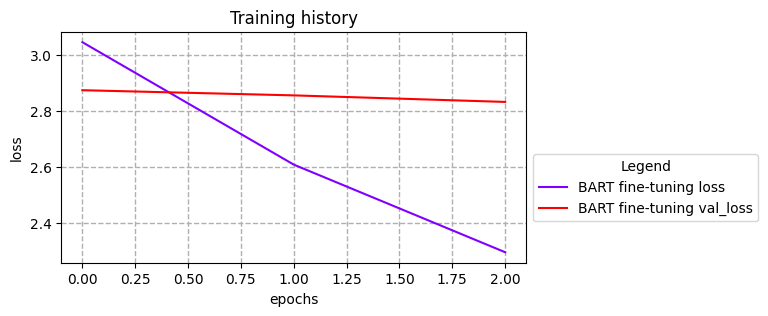

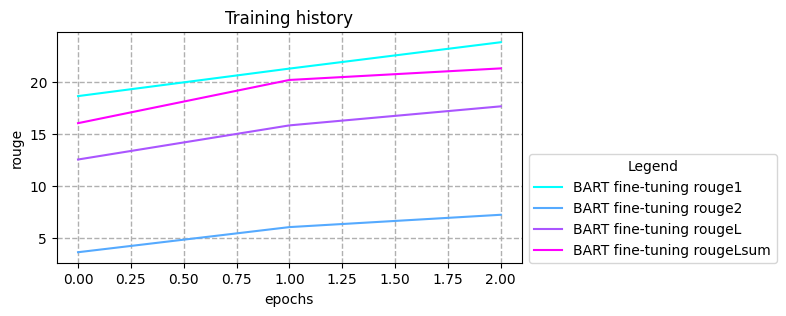

In [ ]:
def plot(models_history, keys, model_names=[], labels=("epochs", "metrics"), y_scale="linear", figsize=(10,5), cmap='rainbow'):
    cmap = plt.cm.get_cmap(cmap, len(keys))

    for i, history in enumerate(models_history):
        for j, metric in enumerate(keys):
            plt.plot(history[metric], label=f"{model_names[i]} {metric}", linestyle="solid", color=cmap(j))
   
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.yscale(y_scale)

    plt.legend(
          title ="Legend",
          loc ="best",
          bbox_to_anchor=(1, 0.5))
    plt.title("Training history")
    plt.grid(linestyle='--', linewidth=1)
    plt.show()

model_his = [history]
model_name = ["BART fine-tuning"]
plot(model_his, keys=['loss', 'val_loss'], model_names=model_name, labels=("epochs", "loss"), figsize=(6,3))
plot(model_his, keys=['rouge1', 'rouge2', 'rougeL', 'rougeLsum'], model_names=model_name, labels=("epochs", "rouge"), figsize=(6,3), cmap="cool")

In [ ]:
metadata_test = pd.read_csv('spotify-podcasts-2020\\metadata-summarization-testset.tsv', sep='\t')
print("Columns: ", metadata_test.columns)
print("Shape: ", metadata_test.shape)

Columns:  Index(['show_uri', 'show_name', 'show_description', 'publisher', 'language',
       'rss_link', 'episode_uri', 'episode_name', 'episode_description',
       'duration', 'show_filename_prefix', 'episode_filename_prefix'],
      dtype='object')
Shape:  (1027, 12)


In [ ]:
metadata_test.dropna(subset=['episode_description', 'show_description'], inplace=True)
metadata_test = metadata_test[[len(desc.strip()) > 0 for desc in metadata_test['episode_description']]]
print("Test set size after dropping NaN values: \n", metadata_test.shape)

Test set size after dropping NaN values: 
 (1025, 12)


In [ ]:
chunk_model = keras.models.load_model("ChunkModel.h5")
sent_encoder = SentenceTransformer('all-MiniLM-L6-v2')

metadata_test['filtered_transcript'] = metadata_test.progress_apply(lambda x: transcript_filtering(x, chunk_model, sent_encoder, tokenizer, test_set=True), axis=1)

metadata_test[['episode_uri','filtered_transcript', 'episode_description']].to_csv('filtered_testset.csv', index=False)

  0%|          | 0/1025 [00:00<?, ?it/s]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  0%|          | 2/1025 [00:18<2:40:21,  9.41s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  0%|          | 3/1025 [00:38<3:55:57, 13.85s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 4/1025 [00:56<4:21:46, 15.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 5/1025 [01:12<4:22:42, 15.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  1%|          | 6/1025 [01:28<4:26:12, 15.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|          | 7/1025 [01:43<4:22:29, 15.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  1%|          | 8/1025 [01:57<4:16:10, 15.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  1%|          | 9/1025 [02:16<4:31:52, 16.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  1%|          | 10/1025 [02:33<4:39:27, 16.52s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  1%|          | 11/1025 [02:40<3:50:18, 13.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|          | 12/1025 [02:56<4:02:50, 14.38s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  1%|▏         | 13/1025 [03:04<3:28:25, 12.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|▏         | 14/1025 [03:18<3:35:25, 12.78s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  1%|▏         | 15/1025 [03:26<3:11:22, 11.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  2%|▏         | 16/1025 [03:30<2:32:58,  9.10s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 17/1025 [03:39<2:35:28,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 18/1025 [03:54<3:04:15, 10.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 19/1025 [04:10<3:27:06, 12.35s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  2%|▏         | 20/1025 [04:17<3:01:58, 10.86s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 21/1025 [04:38<3:49:21, 13.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  2%|▏         | 22/1025 [04:41<2:59:25, 10.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 23/1025 [04:42<2:09:19,  7.74s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  2%|▏         | 24/1025 [04:55<2:34:05,  9.24s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 25/1025 [05:01<2:19:58,  8.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 26/1025 [05:18<3:00:17, 10.83s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  3%|▎         | 27/1025 [05:24<2:37:03,  9.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  3%|▎         | 28/1025 [05:28<2:07:23,  7.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 29/1025 [05:29<1:38:38,  5.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 30/1025 [05:31<1:16:48,  4.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  3%|▎         | 31/1025 [05:33<1:05:43,  3.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 32/1025 [05:49<2:05:41,  7.59s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  3%|▎         | 33/1025 [06:01<2:25:24,  8.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  3%|▎         | 34/1025 [06:03<1:49:51,  6.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  3%|▎         | 35/1025 [06:06<1:31:53,  5.57s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  4%|▎         | 36/1025 [06:12<1:35:06,  5.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▎         | 37/1025 [06:15<1:23:11,  5.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  4%|▎         | 38/1025 [06:18<1:11:33,  4.35s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  4%|▍         | 39/1025 [06:31<1:53:52,  6.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  4%|▍         | 40/1025 [06:32<1:24:14,  5.13s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 41/1025 [06:42<1:47:00,  6.53s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  4%|▍         | 42/1025 [06:48<1:44:22,  6.37s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  4%|▍         | 43/1025 [06:52<1:35:55,  5.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 44/1025 [07:08<2:24:46,  8.85s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  4%|▍         | 45/1025 [07:16<2:19:13,  8.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 46/1025 [07:17<1:40:00,  6.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▍         | 47/1025 [07:17<1:13:42,  4.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  5%|▍         | 48/1025 [07:19<57:24,  3.53s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▍         | 49/1025 [07:21<52:03,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▍         | 50/1025 [07:24<53:25,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▍         | 51/1025 [07:28<52:37,  3.24s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  5%|▌         | 52/1025 [07:34<1:08:36,  4.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▌         | 53/1025 [07:37<1:03:27,  3.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▌         | 54/1025 [07:42<1:07:01,  4.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  5%|▌         | 55/1025 [08:02<2:22:38,  8.82s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  5%|▌         | 56/1025 [08:07<2:04:14,  7.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|▌         | 57/1025 [08:07<1:29:16,  5.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|▌         | 58/1025 [08:08<1:04:25,  4.00s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 59/1025 [08:20<1:43:37,  6.44s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  6%|▌         | 60/1025 [08:29<1:58:23,  7.36s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 61/1025 [08:40<2:15:15,  8.42s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 62/1025 [09:04<3:28:06, 12.97s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 63/1025 [09:16<3:22:04, 12.60s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  6%|▌         | 64/1025 [09:20<2:43:28, 10.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▋         | 65/1025 [09:22<2:04:57,  7.81s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▋         | 66/1025 [09:44<3:12:53, 12.07s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  7%|▋         | 67/1025 [09:51<2:45:53, 10.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 68/1025 [10:08<3:16:22, 12.31s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 69/1025 [10:17<3:01:14, 11.38s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  7%|▋         | 70/1025 [10:30<3:07:32, 11.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 71/1025 [10:44<3:18:52, 12.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|▋         | 72/1025 [10:44<2:21:34,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 73/1025 [11:01<2:59:21, 11.30s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 74/1025 [11:06<2:29:09,  9.41s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 75/1025 [11:17<2:33:36,  9.70s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  7%|▋         | 76/1025 [11:27<2:38:51, 10.04s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  8%|▊         | 77/1025 [11:36<2:30:00,  9.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 78/1025 [11:50<2:52:24, 10.92s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 79/1025 [12:04<3:08:15, 11.94s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 80/1025 [12:16<3:07:55, 11.93s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 81/1025 [12:22<2:38:27, 10.07s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  8%|▊         | 82/1025 [12:28<2:18:41,  8.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 83/1025 [12:41<2:39:13, 10.14s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 84/1025 [13:00<3:22:30, 12.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 85/1025 [13:17<3:39:25, 14.01s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 86/1025 [13:21<2:53:45, 11.10s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  8%|▊         | 87/1025 [13:29<2:37:10, 10.05s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  9%|▊         | 88/1025 [13:40<2:41:12, 10.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▊         | 89/1025 [13:54<3:01:02, 11.61s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  9%|▉         | 90/1025 [14:01<2:37:04, 10.08s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  9%|▉         | 91/1025 [14:09<2:28:10,  9.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 92/1025 [14:28<3:11:20, 12.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|▉         | 93/1025 [14:32<2:33:16,  9.87s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  9%|▉         | 94/1025 [14:38<2:14:37,  8.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|▉         | 95/1025 [14:41<1:49:04,  7.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|▉         | 96/1025 [14:43<1:25:48,  5.54s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  9%|▉         | 97/1025 [14:52<1:42:06,  6.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|▉         | 98/1025 [14:55<1:21:25,  5.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|▉         | 99/1025 [14:57<1:06:44,  4.32s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 10%|▉         | 100/1025 [15:18<2:24:00,  9.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|▉         | 101/1025 [15:22<1:59:45,  7.78s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|▉         | 102/1025 [15:29<1:54:51,  7.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|█         | 103/1025 [15:45<2:34:30, 10.05s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|█         | 104/1025 [15:54<2:29:10,  9.72s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|█         | 105/1025 [16:16<3:28:59, 13.63s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 10%|█         | 106/1025 [16:23<2:55:17, 11.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|█         | 107/1025 [16:23<2:04:36,  8.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 108/1025 [16:37<2:31:25,  9.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 109/1025 [16:55<3:06:22, 12.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 11%|█         | 110/1025 [16:55<2:13:45,  8.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 111/1025 [17:13<2:53:13, 11.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 112/1025 [17:27<3:07:28, 12.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 113/1025 [17:41<3:10:46, 12.55s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 11%|█         | 114/1025 [17:45<2:34:02, 10.15s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 11%|█         | 115/1025 [18:04<3:15:31, 12.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█▏        | 116/1025 [18:18<3:18:07, 13.08s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█▏        | 117/1025 [18:41<4:02:28, 16.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▏        | 118/1025 [18:41<2:51:34, 11.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|█▏        | 119/1025 [18:42<2:01:57,  8.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▏        | 120/1025 [18:42<1:26:36,  5.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|█▏        | 121/1025 [18:42<1:02:50,  4.17s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 12%|█▏        | 122/1025 [18:47<1:06:05,  4.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 123/1025 [19:03<1:56:06,  7.72s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 12%|█▏        | 124/1025 [19:21<2:42:04, 10.79s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 12%|█▏        | 125/1025 [19:44<3:35:39, 14.38s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 12%|█▏        | 126/1025 [20:03<3:58:18, 15.90s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 127/1025 [20:17<3:50:07, 15.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 128/1025 [20:33<3:53:45, 15.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 129/1025 [20:46<3:39:13, 14.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 130/1025 [21:02<3:44:46, 15.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█▎        | 131/1025 [21:05<2:50:37, 11.45s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 132/1025 [21:16<2:50:09, 11.43s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 133/1025 [21:40<3:44:09, 15.08s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 13%|█▎        | 134/1025 [21:51<3:26:59, 13.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 13%|█▎        | 135/1025 [22:06<3:31:22, 14.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 136/1025 [22:13<2:56:26, 11.91s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 137/1025 [22:22<2:45:09, 11.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 138/1025 [22:37<3:00:34, 12.21s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▎        | 139/1025 [22:55<3:27:46, 14.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 14%|█▎        | 140/1025 [22:58<2:36:23, 10.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 14%|█▍        | 141/1025 [22:59<1:55:52,  7.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 14%|█▍        | 142/1025 [23:01<1:28:32,  6.02s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 143/1025 [23:07<1:30:03,  6.13s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 144/1025 [23:16<1:42:53,  7.01s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 145/1025 [23:38<2:47:21, 11.41s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 146/1025 [24:00<3:33:50, 14.60s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 147/1025 [24:11<3:19:17, 13.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 148/1025 [24:26<3:26:13, 14.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▍        | 149/1025 [24:30<2:40:20, 10.98s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▍        | 150/1025 [24:37<2:20:38,  9.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▍        | 151/1025 [24:55<2:58:04, 12.22s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▍        | 152/1025 [24:59<2:23:36,  9.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|█▍        | 153/1025 [25:01<1:48:22,  7.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|█▌        | 154/1025 [25:03<1:21:51,  5.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▌        | 155/1025 [25:04<1:02:40,  4.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▌        | 156/1025 [25:23<2:08:12,  8.85s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▌        | 157/1025 [25:32<2:06:44,  8.76s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▌        | 158/1025 [25:41<2:09:04,  8.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 159/1025 [25:55<2:29:56, 10.39s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 160/1025 [26:05<2:27:01, 10.20s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 161/1025 [26:14<2:22:17,  9.88s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 162/1025 [26:36<3:16:53, 13.69s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 163/1025 [26:57<3:46:19, 15.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 16%|█▌        | 164/1025 [26:59<2:46:56, 11.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 165/1025 [27:15<3:05:44, 12.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 166/1025 [27:30<3:13:14, 13.50s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▋        | 167/1025 [27:50<3:42:14, 15.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 16%|█▋        | 168/1025 [27:54<2:51:18, 11.99s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▋        | 169/1025 [28:01<2:28:53, 10.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 170/1025 [28:04<1:59:58,  8.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 171/1025 [28:07<1:35:24,  6.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|█▋        | 172/1025 [28:08<1:12:41,  5.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|█▋        | 173/1025 [28:10<57:24,  4.04s/it]  

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 174/1025 [28:17<1:11:00,  5.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|█▋        | 175/1025 [28:21<1:04:34,  4.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|█▋        | 176/1025 [28:23<54:30,  3.85s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|█▋        | 177/1025 [28:25<49:05,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|█▋        | 178/1025 [28:26<36:26,  2.58s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 179/1025 [28:32<48:59,  3.47s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 180/1025 [28:37<58:05,  4.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 18%|█▊        | 181/1025 [28:40<54:04,  3.84s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 182/1025 [29:00<2:00:10,  8.55s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 183/1025 [29:05<1:47:15,  7.64s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 184/1025 [29:10<1:32:18,  6.59s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 18%|█▊        | 185/1025 [29:15<1:27:59,  6.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█▊        | 186/1025 [29:19<1:16:08,  5.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█▊        | 187/1025 [29:19<54:34,  3.91s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█▊        | 188/1025 [29:21<47:51,  3.43s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 189/1025 [29:26<54:18,  3.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|█▊        | 190/1025 [29:28<45:39,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|█▊        | 191/1025 [29:30<39:36,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▊        | 192/1025 [29:32<37:08,  2.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 193/1025 [29:49<1:36:14,  6.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 194/1025 [30:05<2:13:33,  9.64s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 19%|█▉        | 195/1025 [30:12<2:03:52,  8.95s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 196/1025 [30:25<2:20:48, 10.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|█▉        | 197/1025 [30:26<1:42:26,  7.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|█▉        | 198/1025 [30:27<1:13:50,  5.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|█▉        | 199/1025 [30:29<1:01:01,  4.43s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|█▉        | 200/1025 [30:36<1:10:25,  5.12s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 20%|█▉        | 201/1025 [30:44<1:20:49,  5.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|█▉        | 202/1025 [31:00<2:03:20,  8.99s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|█▉        | 203/1025 [31:10<2:05:49,  9.18s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|█▉        | 204/1025 [31:16<1:53:02,  8.26s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 205/1025 [31:26<2:00:32,  8.82s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 206/1025 [31:32<1:51:03,  8.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 207/1025 [31:49<2:24:52, 10.63s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 208/1025 [32:01<2:29:45, 11.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|██        | 209/1025 [32:01<1:46:35,  7.84s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 210/1025 [32:11<1:56:56,  8.61s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 211/1025 [32:16<1:39:06,  7.31s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 21%|██        | 212/1025 [32:22<1:36:02,  7.09s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 21%|██        | 213/1025 [32:27<1:27:28,  6.46s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 214/1025 [32:33<1:24:57,  6.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 215/1025 [32:50<2:07:13,  9.42s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 21%|██        | 216/1025 [32:57<1:59:11,  8.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██        | 217/1025 [33:01<1:39:51,  7.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██▏       | 218/1025 [33:02<1:10:23,  5.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██▏       | 219/1025 [33:18<1:54:11,  8.50s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██▏       | 220/1025 [33:27<1:58:16,  8.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 221/1025 [33:41<2:18:14, 10.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 22%|██▏       | 222/1025 [33:42<1:40:03,  7.48s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 223/1025 [33:55<2:01:07,  9.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 224/1025 [34:10<2:23:58, 10.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 22%|██▏       | 225/1025 [34:12<1:52:14,  8.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 22%|██▏       | 226/1025 [34:15<1:27:34,  6.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|██▏       | 227/1025 [34:18<1:14:13,  5.58s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 228/1025 [34:26<1:22:04,  6.18s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 229/1025 [34:44<2:12:47, 10.01s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 22%|██▏       | 230/1025 [34:53<2:08:18,  9.68s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 23%|██▎       | 231/1025 [35:01<1:57:57,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 232/1025 [35:18<2:33:07, 11.59s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 233/1025 [35:30<2:33:05, 11.60s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 234/1025 [35:50<3:06:02, 14.11s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 235/1025 [36:09<3:26:15, 15.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 236/1025 [36:15<2:47:41, 12.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 237/1025 [36:31<3:01:05, 13.79s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 238/1025 [36:46<3:02:19, 13.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 239/1025 [37:01<3:09:07, 14.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 240/1025 [37:17<3:12:33, 14.72s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 24%|██▎       | 241/1025 [37:23<2:40:56, 12.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▎       | 242/1025 [37:43<3:09:27, 14.52s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 24%|██▎       | 243/1025 [37:50<2:38:29, 12.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▍       | 244/1025 [37:54<2:07:10,  9.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██▍       | 245/1025 [37:55<1:31:57,  7.07s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 246/1025 [38:15<2:22:57, 11.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 247/1025 [38:26<2:25:04, 11.19s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 24%|██▍       | 248/1025 [38:47<3:01:21, 14.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██▍       | 249/1025 [38:47<2:08:28,  9.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 24%|██▍       | 250/1025 [38:48<1:32:18,  7.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██▍       | 251/1025 [38:52<1:21:00,  6.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▍       | 252/1025 [39:10<2:06:35,  9.83s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▍       | 253/1025 [39:21<2:08:02,  9.95s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▍       | 254/1025 [39:28<1:56:54,  9.10s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▍       | 255/1025 [39:42<2:16:31, 10.64s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 25%|██▍       | 256/1025 [39:53<2:18:09, 10.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|██▌       | 257/1025 [39:57<1:50:24,  8.63s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▌       | 258/1025 [40:03<1:39:38,  7.80s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▌       | 259/1025 [40:08<1:29:50,  7.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|██▌       | 260/1025 [40:09<1:05:28,  5.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 25%|██▌       | 261/1025 [40:09<48:19,  3.79s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 26%|██▌       | 262/1025 [40:10<35:29,  2.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 26%|██▌       | 263/1025 [40:10<26:40,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|██▌       | 264/1025 [40:11<20:57,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▌       | 265/1025 [40:11<16:28,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▌       | 266/1025 [40:12<14:02,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|██▌       | 267/1025 [40:13<12:05,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|██▌       | 268/1025 [40:13<11:03,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▌       | 269/1025 [40:14<09:39,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|██▋       | 270/1025 [40:14<09:13,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|██▋       | 271/1025 [40:15<08:25,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██▋       | 272/1025 [40:15<08:03,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██▋       | 273/1025 [40:16<07:41,  1.63it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 274/1025 [40:21<24:53,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|██▋       | 275/1025 [40:26<33:32,  2.68s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 276/1025 [40:39<1:12:21,  5.80s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 277/1025 [40:49<1:28:21,  7.09s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 278/1025 [40:53<1:18:05,  6.27s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 279/1025 [41:03<1:32:55,  7.47s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 280/1025 [41:15<1:46:37,  8.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██▋       | 281/1025 [41:15<1:15:46,  6.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 282/1025 [41:30<1:48:49,  8.79s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 28%|██▊       | 283/1025 [41:48<2:24:53, 11.72s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 284/1025 [42:00<2:23:33, 11.62s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 285/1025 [42:06<2:02:03,  9.90s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 286/1025 [42:11<1:45:11,  8.54s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 287/1025 [42:22<1:54:12,  9.29s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 288/1025 [42:33<1:59:30,  9.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 289/1025 [42:48<2:18:02, 11.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 290/1025 [42:52<1:53:15,  9.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 291/1025 [42:59<1:42:29,  8.38s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 292/1025 [43:18<2:22:26, 11.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▊       | 293/1025 [43:26<2:09:32, 10.62s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 29%|██▊       | 294/1025 [43:46<2:43:28, 13.42s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 295/1025 [43:58<2:38:09, 13.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▉       | 296/1025 [44:00<1:57:37,  9.68s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 297/1025 [44:12<2:06:11, 10.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▉       | 298/1025 [44:12<1:29:37,  7.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 299/1025 [44:30<2:06:25, 10.45s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 300/1025 [44:49<2:36:09, 12.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 29%|██▉       | 301/1025 [45:04<2:43:37, 13.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▉       | 302/1025 [45:06<2:03:52, 10.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██▉       | 303/1025 [45:08<1:33:46,  7.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|██▉       | 304/1025 [45:11<1:14:16,  6.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██▉       | 305/1025 [45:14<1:02:49,  5.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|██▉       | 306/1025 [45:16<51:11,  4.27s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|██▉       | 307/1025 [45:19<45:37,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|███       | 308/1025 [45:21<40:18,  3.37s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 30%|███       | 309/1025 [45:33<1:12:48,  6.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███       | 310/1025 [45:34<54:15,  4.55s/it]  

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 311/1025 [45:51<1:36:26,  8.10s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 30%|███       | 312/1025 [45:59<1:35:44,  8.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███       | 313/1025 [46:00<1:10:34,  5.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███       | 314/1025 [46:01<52:34,  4.44s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|███       | 315/1025 [46:03<44:20,  3.75s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 316/1025 [46:12<1:02:48,  5.32s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 317/1025 [46:19<1:09:02,  5.85s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 318/1025 [46:26<1:11:48,  6.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███       | 319/1025 [46:30<1:04:33,  5.49s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 31%|███       | 320/1025 [46:36<1:09:11,  5.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|███▏      | 321/1025 [46:38<53:44,  4.58s/it]  

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███▏      | 322/1025 [46:52<1:25:31,  7.30s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 323/1025 [46:57<1:19:43,  6.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███▏      | 324/1025 [46:59<1:03:30,  5.44s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 325/1025 [47:08<1:13:53,  6.33s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 326/1025 [47:24<1:46:23,  9.13s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 327/1025 [47:31<1:40:28,  8.64s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 32%|███▏      | 328/1025 [47:39<1:37:34,  8.40s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 32%|███▏      | 329/1025 [48:06<2:41:33, 13.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 330/1025 [48:19<2:40:18, 13.84s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 331/1025 [48:30<2:29:02, 12.89s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 332/1025 [48:38<2:10:48, 11.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 333/1025 [48:52<2:22:17, 12.34s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 334/1025 [48:56<1:53:21,  9.84s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 33%|███▎      | 335/1025 [49:07<1:54:51,  9.99s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 336/1025 [49:19<2:02:53, 10.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 337/1025 [49:20<1:27:35,  7.64s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 338/1025 [49:27<1:27:15,  7.62s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 339/1025 [49:37<1:34:46,  8.29s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 340/1025 [49:46<1:36:28,  8.45s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 341/1025 [49:58<1:50:30,  9.69s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 342/1025 [50:17<2:22:09, 12.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 343/1025 [50:35<2:39:13, 14.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|███▎      | 344/1025 [50:36<1:55:32, 10.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|███▎      | 345/1025 [50:40<1:31:46,  8.10s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 346/1025 [50:44<1:20:05,  7.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|███▍      | 347/1025 [50:47<1:05:16,  5.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|███▍      | 348/1025 [50:48<48:38,  4.31s/it]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 349/1025 [50:58<1:06:49,  5.93s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 350/1025 [51:03<1:05:07,  5.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|███▍      | 351/1025 [51:05<52:47,  4.70s/it]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 34%|███▍      | 352/1025 [51:20<1:25:06,  7.59s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 353/1025 [51:28<1:29:41,  8.01s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▍      | 354/1025 [51:37<1:31:16,  8.16s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 35%|███▍      | 355/1025 [51:42<1:22:10,  7.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|███▍      | 356/1025 [51:45<1:04:42,  5.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▍      | 357/1025 [52:02<1:43:51,  9.33s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▍      | 358/1025 [52:12<1:45:57,  9.53s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▌      | 359/1025 [52:25<1:55:05, 10.37s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 35%|███▌      | 360/1025 [52:30<1:39:15,  8.96s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 35%|███▌      | 361/1025 [52:39<1:37:50,  8.84s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▌      | 362/1025 [52:46<1:31:07,  8.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▌      | 363/1025 [52:53<1:26:42,  7.86s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 364/1025 [53:04<1:37:31,  8.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▌      | 365/1025 [53:08<1:21:17,  7.39s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 366/1025 [53:26<1:56:51, 10.64s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 367/1025 [53:44<2:21:54, 12.94s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 368/1025 [53:56<2:18:59, 12.69s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 369/1025 [54:02<1:57:01, 10.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▌      | 370/1025 [54:03<1:25:08,  7.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▌      | 371/1025 [54:08<1:13:22,  6.73s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


 36%|███▋      | 372/1025 [54:14<1:11:41,  6.59s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▋      | 373/1025 [54:19<1:06:23,  6.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▋      | 374/1025 [54:23<59:14,  5.46s/it]  

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 375/1025 [54:28<56:43,  5.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|███▋      | 376/1025 [54:31<50:52,  4.70s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 377/1025 [54:37<55:58,  5.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 378/1025 [54:52<1:25:50,  7.96s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 379/1025 [55:01<1:30:34,  8.41s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 380/1025 [55:10<1:30:53,  8.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|███▋      | 381/1025 [55:13<1:13:32,  6.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|███▋      | 382/1025 [55:17<1:04:11,  5.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 37%|███▋      | 383/1025 [55:32<1:32:34,  8.65s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 384/1025 [55:37<1:22:01,  7.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 385/1025 [55:37<57:46,  5.42s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 386/1025 [55:39<44:08,  4.15s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 387/1025 [55:47<57:52,  5.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 388/1025 [55:51<51:41,  4.87s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 389/1025 [56:02<1:14:11,  7.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 390/1025 [56:03<52:27,  4.96s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|███▊      | 391/1025 [56:03<37:14,  3.52s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 38%|███▊      | 392/1025 [56:23<1:28:16,  8.37s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 393/1025 [56:31<1:29:18,  8.48s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 394/1025 [56:49<1:58:04, 11.23s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 39%|███▊      | 395/1025 [57:09<2:26:16, 13.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|███▊      | 396/1025 [57:12<1:51:17, 10.62s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▊      | 397/1025 [57:26<2:01:24, 11.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|███▉      | 398/1025 [57:29<1:35:17,  9.12s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 399/1025 [57:40<1:39:20,  9.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|███▉      | 400/1025 [57:41<1:13:48,  7.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 401/1025 [57:58<1:43:36,  9.96s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 402/1025 [58:16<2:09:18, 12.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 403/1025 [58:33<2:23:45, 13.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|███▉      | 404/1025 [58:36<1:48:31, 10.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|███▉      | 405/1025 [58:53<2:07:39, 12.35s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|███▉      | 406/1025 [58:59<1:50:24, 10.70s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 40%|███▉      | 407/1025 [59:04<1:32:24,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|███▉      | 408/1025 [59:20<1:52:52, 10.98s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|███▉      | 409/1025 [59:24<1:31:32,  8.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 40%|████      | 410/1025 [59:28<1:16:25,  7.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|████      | 411/1025 [59:41<1:31:55,  8.98s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|████      | 412/1025 [59:47<1:23:59,  8.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|████      | 413/1025 [59:49<1:04:56,  6.37s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|████      | 414/1025 [59:56<1:07:26,  6.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|████      | 415/1025 [1:00:11<1:31:34,  9.01s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 41%|████      | 416/1025 [1:00:15<1:16:34,  7.54s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 417/1025 [1:00:20<1:07:21,  6.65s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 418/1025 [1:00:27<1:10:07,  6.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|████      | 419/1025 [1:00:30<58:39,  5.81s/it]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 420/1025 [1:00:40<1:10:53,  7.03s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 41%|████      | 421/1025 [1:00:51<1:20:55,  8.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|████      | 422/1025 [1:00:51<58:38,  5.83s/it]  

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████▏     | 423/1025 [1:01:04<1:17:54,  7.77s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████▏     | 424/1025 [1:01:14<1:26:39,  8.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████▏     | 425/1025 [1:01:27<1:39:25,  9.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 426/1025 [1:01:42<1:52:07, 11.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 427/1025 [1:01:59<2:10:14, 13.07s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 42%|████▏     | 428/1025 [1:02:10<2:04:06, 12.47s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 429/1025 [1:02:20<1:55:34, 11.63s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 42%|████▏     | 430/1025 [1:02:28<1:44:28, 10.53s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 431/1025 [1:02:46<2:07:22, 12.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████▏     | 432/1025 [1:02:50<1:40:56, 10.21s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 433/1025 [1:02:58<1:34:13,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 434/1025 [1:03:13<1:49:54, 11.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 435/1025 [1:03:26<1:56:00, 11.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|████▎     | 436/1025 [1:03:29<1:29:26,  9.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|████▎     | 437/1025 [1:03:31<1:09:11,  7.06s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 438/1025 [1:03:37<1:06:26,  6.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|████▎     | 439/1025 [1:03:41<56:06,  5.74s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|████▎     | 441/1025 [1:03:44<36:17,  3.73s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 442/1025 [1:03:49<41:19,  4.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 443/1025 [1:03:54<42:58,  4.43s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 43%|████▎     | 444/1025 [1:04:04<55:42,  5.75s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 445/1025 [1:04:14<1:08:47,  7.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▎     | 446/1025 [1:04:27<1:23:59,  8.70s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▎     | 447/1025 [1:04:34<1:20:29,  8.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|████▎     | 448/1025 [1:04:38<1:06:49,  6.95s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 449/1025 [1:04:45<1:05:48,  6.86s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 44%|████▍     | 450/1025 [1:04:53<1:10:28,  7.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 451/1025 [1:05:09<1:33:56,  9.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 452/1025 [1:05:23<1:47:41, 11.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|████▍     | 453/1025 [1:05:26<1:22:01,  8.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 44%|████▍     | 454/1025 [1:05:44<1:50:15, 11.59s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 455/1025 [1:05:57<1:51:54, 11.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 44%|████▍     | 456/1025 [1:06:12<2:02:19, 12.90s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▍     | 457/1025 [1:06:32<2:20:55, 14.89s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 45%|████▍     | 458/1025 [1:06:45<2:17:17, 14.53s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▍     | 459/1025 [1:06:56<2:05:56, 13.35s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▍     | 460/1025 [1:07:05<1:52:20, 11.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|████▍     | 461/1025 [1:07:06<1:23:12,  8.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|████▌     | 462/1025 [1:07:10<1:07:50,  7.23s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▌     | 463/1025 [1:07:15<1:02:36,  6.68s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▌     | 464/1025 [1:07:26<1:13:57,  7.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|████▌     | 465/1025 [1:07:26<52:48,  5.66s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|████▌     | 466/1025 [1:07:27<38:58,  4.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|████▌     | 467/1025 [1:07:27<28:17,  3.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|████▌     | 468/1025 [1:07:30<27:05,  2.92s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 469/1025 [1:07:42<51:50,  5.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████▌     | 470/1025 [1:07:45<45:43,  4.94s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 471/1025 [1:07:55<1:00:06,  6.51s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 46%|████▌     | 472/1025 [1:08:02<1:00:45,  6.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|████▌     | 473/1025 [1:08:03<43:31,  4.73s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████▌     | 474/1025 [1:08:03<31:47,  3.46s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 46%|████▋     | 475/1025 [1:08:13<50:32,  5.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▋     | 476/1025 [1:08:27<1:13:18,  8.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 477/1025 [1:08:42<1:31:32, 10.02s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 478/1025 [1:08:54<1:37:54, 10.74s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 479/1025 [1:09:02<1:29:19,  9.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|████▋     | 480/1025 [1:09:06<1:12:25,  7.97s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 481/1025 [1:09:16<1:17:29,  8.55s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 482/1025 [1:09:34<1:45:05, 11.61s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 483/1025 [1:09:40<1:28:26,  9.79s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 484/1025 [1:09:45<1:14:39,  8.28s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 485/1025 [1:09:50<1:07:03,  7.45s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 486/1025 [1:10:01<1:15:40,  8.42s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 487/1025 [1:10:06<1:07:23,  7.51s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 488/1025 [1:10:12<1:03:29,  7.09s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 489/1025 [1:10:17<57:10,  6.40s/it]  

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 490/1025 [1:10:23<56:31,  6.34s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 491/1025 [1:10:37<1:15:27,  8.48s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 492/1025 [1:10:43<1:10:23,  7.92s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 493/1025 [1:10:53<1:15:53,  8.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|████▊     | 494/1025 [1:10:55<57:26,  6.49s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 495/1025 [1:11:00<52:21,  5.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 496/1025 [1:11:02<43:19,  4.91s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 48%|████▊     | 497/1025 [1:11:11<53:25,  6.07s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▊     | 498/1025 [1:11:20<59:38,  6.79s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▊     | 499/1025 [1:11:27<1:01:01,  6.96s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 49%|████▉     | 500/1025 [1:11:36<1:05:48,  7.52s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 501/1025 [1:11:47<1:14:56,  8.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 502/1025 [1:12:03<1:34:09, 10.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|████▉     | 503/1025 [1:12:06<1:13:50,  8.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|████▉     | 504/1025 [1:12:09<59:46,  6.88s/it]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 505/1025 [1:12:21<1:13:09,  8.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 49%|████▉     | 506/1025 [1:12:29<1:11:42,  8.29s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 49%|████▉     | 507/1025 [1:12:37<1:10:11,  8.13s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|████▉     | 508/1025 [1:12:41<1:01:13,  7.11s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|████▉     | 509/1025 [1:12:47<57:43,  6.71s/it]  

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|████▉     | 510/1025 [1:13:03<1:19:43,  9.29s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|████▉     | 511/1025 [1:13:13<1:22:06,  9.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|████▉     | 512/1025 [1:13:14<1:00:04,  7.03s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 513/1025 [1:13:22<1:01:44,  7.24s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 50%|█████     | 514/1025 [1:13:47<1:48:33, 12.75s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 515/1025 [1:13:54<1:32:30, 10.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 516/1025 [1:14:10<1:46:13, 12.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|█████     | 517/1025 [1:14:12<1:18:09,  9.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████     | 518/1025 [1:14:15<1:01:59,  7.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████     | 519/1025 [1:14:18<52:40,  6.25s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████     | 520/1025 [1:14:21<44:09,  5.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


 51%|█████     | 521/1025 [1:14:28<47:28,  5.65s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 51%|█████     | 522/1025 [1:14:50<1:28:41, 10.58s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 51%|█████     | 523/1025 [1:15:12<1:57:48, 14.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████     | 524/1025 [1:15:13<1:24:17, 10.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 525/1025 [1:15:30<1:42:04, 12.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████▏    | 526/1025 [1:15:37<1:28:50, 10.68s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████▏    | 527/1025 [1:15:47<1:26:20, 10.40s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 528/1025 [1:15:53<1:16:01,  9.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 529/1025 [1:15:54<55:10,  6.67s/it]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 530/1025 [1:16:06<1:06:59,  8.12s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 531/1025 [1:16:13<1:05:49,  7.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 532/1025 [1:16:26<1:17:32,  9.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 52%|█████▏    | 533/1025 [1:16:29<1:01:40,  7.52s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 52%|█████▏    | 534/1025 [1:16:37<1:01:18,  7.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 535/1025 [1:16:37<43:28,  5.32s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 52%|█████▏    | 536/1025 [1:16:41<39:26,  4.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 52%|█████▏    | 537/1025 [1:16:41<28:14,  3.47s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 538/1025 [1:16:53<48:05,  5.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 53%|█████▎    | 539/1025 [1:16:56<41:56,  5.18s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 540/1025 [1:17:07<56:49,  7.03s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 541/1025 [1:17:16<1:01:43,  7.65s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 53%|█████▎    | 542/1025 [1:17:24<1:01:13,  7.61s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 543/1025 [1:17:45<1:32:57, 11.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|█████▎    | 544/1025 [1:17:46<1:08:24,  8.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 53%|█████▎    | 545/1025 [1:17:48<51:45,  6.47s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 53%|█████▎    | 546/1025 [1:17:51<44:12,  5.54s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 547/1025 [1:17:57<44:18,  5.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 53%|█████▎    | 548/1025 [1:18:11<1:05:15,  8.21s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▎    | 549/1025 [1:18:23<1:13:21,  9.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▎    | 550/1025 [1:18:28<1:02:55,  7.95s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 54%|█████▍    | 551/1025 [1:18:50<1:36:27, 12.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▍    | 552/1025 [1:18:53<1:14:57,  9.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████▍    | 553/1025 [1:18:56<58:41,  7.46s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▍    | 554/1025 [1:18:59<48:19,  6.16s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 555/1025 [1:19:09<56:58,  7.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████▍    | 556/1025 [1:19:09<40:12,  5.14s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 557/1025 [1:19:19<51:10,  6.56s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 558/1025 [1:19:30<1:00:40,  7.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▍    | 559/1025 [1:19:47<1:23:59, 10.81s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▍    | 560/1025 [1:20:01<1:30:43, 11.71s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▍    | 561/1025 [1:20:24<1:55:16, 14.91s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▍    | 562/1025 [1:20:31<1:38:05, 12.71s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▍    | 563/1025 [1:20:40<1:29:24, 11.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 55%|█████▌    | 564/1025 [1:20:42<1:06:29,  8.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 55%|█████▌    | 565/1025 [1:20:59<1:26:37, 11.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▌    | 566/1025 [1:21:16<1:37:34, 12.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|█████▌    | 567/1025 [1:21:18<1:13:03,  9.57s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 55%|█████▌    | 568/1025 [1:21:22<1:01:21,  8.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▌    | 569/1025 [1:21:23<44:57,  5.92s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████▌    | 570/1025 [1:21:24<33:33,  4.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 571/1025 [1:21:42<1:04:10,  8.48s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 572/1025 [1:21:55<1:13:21,  9.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|█████▌    | 573/1025 [1:21:58<59:22,  7.88s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▌    | 574/1025 [1:22:01<48:26,  6.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 56%|█████▌    | 575/1025 [1:22:06<45:00,  6.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████▌    | 576/1025 [1:22:10<38:52,  5.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▋    | 577/1025 [1:22:12<33:28,  4.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▋    | 578/1025 [1:22:27<55:21,  7.43s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▋    | 579/1025 [1:22:33<51:54,  6.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 57%|█████▋    | 580/1025 [1:22:48<1:11:06,  9.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|█████▋    | 581/1025 [1:22:51<56:07,  7.58s/it]  

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 582/1025 [1:23:04<1:06:32,  9.01s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 583/1025 [1:23:15<1:11:36,  9.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|█████▋    | 584/1025 [1:23:17<54:49,  7.46s/it]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 585/1025 [1:23:26<56:43,  7.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|█████▋    | 586/1025 [1:23:27<43:47,  5.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|█████▋    | 587/1025 [1:23:28<32:39,  4.47s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 57%|█████▋    | 588/1025 [1:23:51<1:11:38,  9.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|█████▋    | 589/1025 [1:23:53<55:07,  7.59s/it]  

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 590/1025 [1:24:12<1:20:28, 11.10s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 591/1025 [1:24:19<1:10:01,  9.68s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 592/1025 [1:24:24<1:01:21,  8.50s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 593/1025 [1:24:32<58:22,  8.11s/it]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 594/1025 [1:24:43<1:04:07,  8.93s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 595/1025 [1:24:46<53:17,  7.44s/it]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 596/1025 [1:24:59<1:03:28,  8.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 58%|█████▊    | 597/1025 [1:25:17<1:22:31, 11.57s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 598/1025 [1:25:29<1:25:02, 11.95s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 599/1025 [1:25:41<1:24:58, 11.97s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▊    | 600/1025 [1:25:48<1:12:33, 10.24s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▊    | 601/1025 [1:25:54<1:05:10,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▊    | 602/1025 [1:26:08<1:14:07, 10.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████▉    | 603/1025 [1:26:12<1:00:41,  8.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████▉    | 604/1025 [1:26:16<51:03,  7.28s/it]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 605/1025 [1:26:26<56:29,  8.07s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 59%|█████▉    | 606/1025 [1:26:37<1:01:12,  8.77s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 607/1025 [1:26:50<1:09:36,  9.99s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 608/1025 [1:27:00<1:10:23, 10.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 609/1025 [1:27:17<1:24:49, 12.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|█████▉    | 610/1025 [1:27:36<1:38:39, 14.26s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 60%|█████▉    | 611/1025 [1:27:47<1:31:01, 13.19s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|█████▉    | 612/1025 [1:27:52<1:13:49, 10.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|█████▉    | 613/1025 [1:27:54<55:43,  8.11s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|█████▉    | 614/1025 [1:27:57<44:50,  6.55s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|██████    | 615/1025 [1:28:02<43:13,  6.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|██████    | 616/1025 [1:28:03<30:56,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|██████    | 617/1025 [1:28:03<22:37,  3.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|██████    | 618/1025 [1:28:19<48:11,  7.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|██████    | 619/1025 [1:28:36<1:07:24,  9.96s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 60%|██████    | 620/1025 [1:28:55<1:25:18, 12.64s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 621/1025 [1:29:04<1:17:27, 11.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|██████    | 622/1025 [1:29:06<58:32,  8.71s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|██████    | 623/1025 [1:29:09<46:35,  6.95s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 61%|██████    | 624/1025 [1:29:16<47:53,  7.17s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 625/1025 [1:29:25<50:04,  7.51s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 626/1025 [1:29:34<54:34,  8.21s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 627/1025 [1:29:42<53:46,  8.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████▏   | 628/1025 [1:30:01<1:14:00, 11.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|██████▏   | 629/1025 [1:30:03<56:00,  8.49s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|██████▏   | 630/1025 [1:30:03<39:43,  6.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 631/1025 [1:30:19<58:03,  8.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|██████▏   | 632/1025 [1:30:22<46:12,  7.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|██████▏   | 633/1025 [1:30:22<33:05,  5.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 634/1025 [1:30:39<56:58,  8.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|██████▏   | 635/1025 [1:30:42<45:13,  6.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|██████▏   | 636/1025 [1:30:44<36:01,  5.56s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 637/1025 [1:30:52<40:10,  6.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 638/1025 [1:31:06<54:54,  8.51s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 639/1025 [1:31:14<54:06,  8.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 640/1025 [1:31:28<1:04:39, 10.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 63%|██████▎   | 641/1025 [1:31:44<1:16:17, 11.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 642/1025 [1:32:00<1:22:27, 12.92s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 63%|██████▎   | 643/1025 [1:32:06<1:10:35, 11.09s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 644/1025 [1:32:18<1:11:06, 11.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 63%|██████▎   | 645/1025 [1:32:21<56:33,  8.93s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 63%|██████▎   | 646/1025 [1:32:25<46:16,  7.33s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 63%|██████▎   | 647/1025 [1:32:33<46:45,  7.42s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 648/1025 [1:32:42<49:42,  7.91s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 63%|██████▎   | 649/1025 [1:32:53<56:45,  9.06s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 650/1025 [1:33:06<1:03:23, 10.14s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▎   | 651/1025 [1:33:16<1:02:14,  9.98s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▎   | 652/1025 [1:33:26<1:03:06, 10.15s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▎   | 653/1025 [1:33:46<1:20:58, 13.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 64%|██████▍   | 654/1025 [1:33:46<57:00,  9.22s/it]  

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 655/1025 [1:34:01<1:05:56, 10.69s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 656/1025 [1:34:07<58:17,  9.48s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 64%|██████▍   | 657/1025 [1:34:08<41:36,  6.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████▍   | 658/1025 [1:34:09<30:51,  5.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 64%|██████▍   | 659/1025 [1:34:10<23:20,  3.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 64%|██████▍   | 660/1025 [1:34:11<17:59,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████▍   | 661/1025 [1:34:12<14:11,  2.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████▍   | 662/1025 [1:34:13<11:49,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████▍   | 663/1025 [1:34:14<10:16,  1.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|██████▍   | 664/1025 [1:34:15<08:48,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|██████▍   | 665/1025 [1:34:15<06:52,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▍   | 666/1025 [1:34:28<27:51,  4.66s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 667/1025 [1:34:38<37:36,  6.30s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 668/1025 [1:34:45<38:25,  6.46s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 669/1025 [1:34:53<41:28,  6.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 65%|██████▌   | 670/1025 [1:35:08<55:40,  9.41s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 65%|██████▌   | 671/1025 [1:35:16<52:18,  8.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████▌   | 672/1025 [1:35:19<41:42,  7.09s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 673/1025 [1:35:27<44:41,  7.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 674/1025 [1:35:46<1:04:23, 11.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|██████▌   | 675/1025 [1:35:48<47:59,  8.23s/it]  

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 676/1025 [1:36:01<56:38,  9.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 66%|██████▌   | 677/1025 [1:36:15<1:03:11, 10.89s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 66%|██████▌   | 678/1025 [1:36:21<55:16,  9.56s/it]  

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 679/1025 [1:36:25<45:31,  7.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▋   | 680/1025 [1:36:40<57:36, 10.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|██████▋   | 681/1025 [1:36:43<44:30,  7.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████▋   | 682/1025 [1:36:46<35:46,  6.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|██████▋   | 683/1025 [1:36:48<28:42,  5.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|██████▋   | 684/1025 [1:36:51<25:08,  4.42s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 685/1025 [1:36:57<28:01,  4.94s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 686/1025 [1:37:03<29:47,  5.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 687/1025 [1:37:21<51:17,  9.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|██████▋   | 688/1025 [1:37:24<41:28,  7.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|██████▋   | 689/1025 [1:37:27<32:38,  5.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|██████▋   | 690/1025 [1:37:29<26:22,  4.72s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 691/1025 [1:37:41<38:14,  6.87s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 692/1025 [1:37:52<45:46,  8.25s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 693/1025 [1:38:05<53:46,  9.72s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 694/1025 [1:38:15<53:17,  9.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 695/1025 [1:38:18<42:56,  7.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 696/1025 [1:38:19<30:37,  5.59s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 68%|██████▊   | 697/1025 [1:38:36<50:12,  9.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|██████▊   | 698/1025 [1:38:38<37:38,  6.91s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 68%|██████▊   | 699/1025 [1:38:45<38:17,  7.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 700/1025 [1:38:48<31:38,  5.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 68%|██████▊   | 701/1025 [1:38:50<24:47,  4.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 702/1025 [1:38:51<18:44,  3.48s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▊   | 703/1025 [1:39:03<33:00,  6.15s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▊   | 704/1025 [1:39:16<43:04,  8.05s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 705/1025 [1:39:29<51:19,  9.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 706/1025 [1:39:46<1:02:17, 11.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████▉   | 707/1025 [1:39:47<44:56,  8.48s/it]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 708/1025 [1:39:57<48:18,  9.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████▉   | 709/1025 [1:39:59<36:41,  6.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 710/1025 [1:40:16<52:15,  9.95s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 69%|██████▉   | 711/1025 [1:40:26<51:41,  9.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████▉   | 712/1025 [1:40:28<39:22,  7.55s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|██████▉   | 713/1025 [1:40:47<57:25, 11.04s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|██████▉   | 714/1025 [1:40:53<48:55,  9.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|██████▉   | 715/1025 [1:40:54<35:27,  6.86s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|██████▉   | 716/1025 [1:40:58<31:02,  6.03s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|██████▉   | 717/1025 [1:41:10<40:08,  7.82s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 718/1025 [1:41:18<40:13,  7.86s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 70%|███████   | 719/1025 [1:41:25<39:50,  7.81s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 70%|███████   | 720/1025 [1:41:39<48:41,  9.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|███████   | 721/1025 [1:41:42<39:02,  7.71s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 722/1025 [1:42:00<54:09, 10.72s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 723/1025 [1:42:07<47:59,  9.53s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 724/1025 [1:42:11<40:00,  7.98s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 725/1025 [1:42:33<1:00:11, 12.04s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 726/1025 [1:42:44<58:20, 11.71s/it]  

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 727/1025 [1:42:51<52:02, 10.48s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 728/1025 [1:43:05<56:05, 11.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 729/1025 [1:43:21<1:03:32, 12.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 730/1025 [1:43:38<1:08:49, 14.00s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████▏  | 731/1025 [1:43:46<1:00:49, 12.41s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████▏  | 732/1025 [1:43:58<59:10, 12.12s/it]  

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 733/1025 [1:44:05<51:43, 10.63s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 734/1025 [1:44:10<43:43,  9.02s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 735/1025 [1:44:16<38:47,  8.03s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 736/1025 [1:44:26<41:30,  8.62s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 737/1025 [1:44:35<42:19,  8.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|███████▏  | 738/1025 [1:44:39<35:02,  7.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 72%|███████▏  | 739/1025 [1:44:52<43:01,  9.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|███████▏  | 740/1025 [1:44:54<33:06,  6.97s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 741/1025 [1:45:05<37:41,  7.96s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 742/1025 [1:45:17<44:23,  9.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 72%|███████▏  | 743/1025 [1:45:18<31:48,  6.77s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 744/1025 [1:45:28<36:37,  7.82s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 745/1025 [1:45:35<34:36,  7.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|███████▎  | 746/1025 [1:45:37<27:36,  5.94s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 747/1025 [1:45:49<35:12,  7.60s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 748/1025 [1:46:13<58:53, 12.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 73%|███████▎  | 749/1025 [1:46:14<41:38,  9.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 750/1025 [1:46:32<53:34, 11.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 73%|███████▎  | 751/1025 [1:46:32<37:58,  8.32s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 752/1025 [1:46:43<40:50,  8.98s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 753/1025 [1:46:50<39:08,  8.63s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▎  | 754/1025 [1:47:11<55:40, 12.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▎  | 755/1025 [1:47:28<1:01:29, 13.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 74%|███████▍  | 756/1025 [1:47:30<45:00, 10.04s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 74%|███████▍  | 757/1025 [1:47:32<33:43,  7.55s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 758/1025 [1:47:42<37:32,  8.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 759/1025 [1:47:58<47:53, 10.80s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 760/1025 [1:48:07<44:58, 10.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 74%|███████▍  | 761/1025 [1:48:09<34:13,  7.78s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 762/1025 [1:48:14<30:33,  6.97s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 763/1025 [1:48:20<29:14,  6.70s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▍  | 764/1025 [1:48:32<35:18,  8.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▍  | 765/1025 [1:48:34<26:51,  6.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 75%|███████▍  | 766/1025 [1:48:36<21:52,  5.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 75%|███████▍  | 767/1025 [1:48:38<17:54,  4.16s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▍  | 768/1025 [1:48:45<21:01,  4.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 75%|███████▌  | 769/1025 [1:49:00<34:34,  8.10s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 770/1025 [1:49:10<36:37,  8.62s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 75%|███████▌  | 771/1025 [1:49:30<50:20, 11.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 772/1025 [1:49:43<52:01, 12.34s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 773/1025 [1:49:48<42:42, 10.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|███████▌  | 774/1025 [1:49:51<33:27,  8.00s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 775/1025 [1:50:02<37:19,  8.96s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 776/1025 [1:50:08<33:29,  8.07s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 777/1025 [1:50:20<37:51,  9.16s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 76%|███████▌  | 778/1025 [1:50:37<47:59, 11.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 76%|███████▌  | 779/1025 [1:50:40<36:17,  8.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████▌  | 780/1025 [1:50:42<28:18,  6.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████▌  | 781/1025 [1:50:42<19:53,  4.89s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▋  | 782/1025 [1:51:02<37:41,  9.30s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 76%|███████▋  | 783/1025 [1:51:07<32:44,  8.12s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▋  | 784/1025 [1:51:17<34:19,  8.55s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 785/1025 [1:51:26<35:18,  8.83s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 77%|███████▋  | 786/1025 [1:51:35<34:45,  8.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 787/1025 [1:51:50<42:21, 10.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|███████▋  | 788/1025 [1:51:54<34:29,  8.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 789/1025 [1:52:08<40:40, 10.34s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 790/1025 [1:52:14<35:13,  8.99s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 791/1025 [1:52:23<34:29,  8.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|███████▋  | 792/1025 [1:52:24<25:10,  6.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|███████▋  | 793/1025 [1:52:25<18:49,  4.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|███████▋  | 794/1025 [1:52:26<14:06,  3.67s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 795/1025 [1:52:40<26:46,  6.98s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 78%|███████▊  | 796/1025 [1:52:51<31:14,  8.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 797/1025 [1:53:07<39:35, 10.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 798/1025 [1:53:21<43:19, 11.45s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 799/1025 [1:53:26<35:48,  9.51s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 800/1025 [1:53:38<38:14, 10.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|███████▊  | 801/1025 [1:53:41<30:04,  8.06s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 802/1025 [1:53:51<32:54,  8.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████▊  | 803/1025 [1:53:54<26:12,  7.08s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 804/1025 [1:54:14<40:18, 10.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|███████▊  | 805/1025 [1:54:15<28:58,  7.90s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▊  | 806/1025 [1:54:25<30:53,  8.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 79%|███████▊  | 807/1025 [1:54:39<36:36, 10.08s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 808/1025 [1:54:44<31:02,  8.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|███████▉  | 809/1025 [1:54:46<23:50,  6.62s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 810/1025 [1:54:53<24:44,  6.90s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 811/1025 [1:55:00<24:48,  6.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|███████▉  | 812/1025 [1:55:01<17:24,  4.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|███████▉  | 813/1025 [1:55:02<13:16,  3.76s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 814/1025 [1:55:09<16:40,  4.74s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|███████▉  | 815/1025 [1:55:20<22:59,  6.57s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|███████▉  | 816/1025 [1:55:33<29:46,  8.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|███████▉  | 817/1025 [1:55:48<36:36, 10.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|███████▉  | 818/1025 [1:56:06<44:16, 12.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|███████▉  | 819/1025 [1:56:09<33:21,  9.72s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|████████  | 820/1025 [1:56:29<44:12, 12.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|████████  | 821/1025 [1:56:33<34:58, 10.29s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|████████  | 822/1025 [1:56:37<28:25,  8.40s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|████████  | 823/1025 [1:57:03<46:18, 13.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|████████  | 824/1025 [1:57:20<49:01, 14.64s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|████████  | 825/1025 [1:57:37<51:29, 15.45s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 826/1025 [1:58:03<1:01:00, 18.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|████████  | 827/1025 [1:58:07<46:33, 14.11s/it]  

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 828/1025 [1:58:23<48:47, 14.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 829/1025 [1:58:25<35:23, 10.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|████████  | 830/1025 [1:58:26<26:08,  8.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|████████  | 831/1025 [1:58:29<21:09,  6.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████  | 832/1025 [1:58:32<17:04,  5.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████▏ | 833/1025 [1:58:48<27:15,  8.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|████████▏ | 834/1025 [1:58:51<21:55,  6.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 81%|████████▏ | 835/1025 [1:59:08<31:18,  9.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 836/1025 [1:59:21<34:25, 10.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|████████▏ | 837/1025 [1:59:23<25:32,  8.15s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 838/1025 [1:59:30<24:25,  7.84s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 839/1025 [1:59:41<26:52,  8.67s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 840/1025 [1:59:51<28:16,  9.17s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 841/1025 [1:59:58<26:41,  8.70s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 842/1025 [2:00:03<22:27,  7.36s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 843/1025 [2:00:12<24:11,  7.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|████████▏ | 844/1025 [2:00:13<18:03,  5.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|████████▏ | 845/1025 [2:00:17<15:58,  5.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 846/1025 [2:00:30<22:41,  7.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 847/1025 [2:00:46<29:32,  9.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 848/1025 [2:01:03<36:09, 12.26s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 849/1025 [2:01:13<33:27, 11.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 850/1025 [2:01:28<37:00, 12.69s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 851/1025 [2:01:40<35:30, 12.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 852/1025 [2:01:55<38:19, 13.29s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 853/1025 [2:01:59<30:08, 10.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████▎ | 854/1025 [2:02:01<22:09,  7.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████▎ | 855/1025 [2:02:02<16:44,  5.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████▎ | 856/1025 [2:02:06<14:56,  5.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▎ | 857/1025 [2:02:20<22:09,  7.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▎ | 858/1025 [2:02:36<28:37, 10.28s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 84%|████████▍ | 859/1025 [2:02:42<24:52,  8.99s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 860/1025 [2:02:53<26:35,  9.67s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 861/1025 [2:03:16<37:11, 13.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|████████▍ | 862/1025 [2:03:17<26:30,  9.76s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 863/1025 [2:03:24<24:34,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 84%|████████▍ | 864/1025 [2:03:38<27:45, 10.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 865/1025 [2:03:53<31:40, 11.88s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 84%|████████▍ | 866/1025 [2:04:03<30:14, 11.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████▍ | 867/1025 [2:04:06<23:21,  8.87s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▍ | 868/1025 [2:04:24<30:06, 11.51s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▍ | 869/1025 [2:04:36<30:26, 11.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▍ | 870/1025 [2:04:53<34:15, 13.26s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 85%|████████▍ | 871/1025 [2:05:13<38:58, 15.19s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▌ | 872/1025 [2:05:22<34:25, 13.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▌ | 873/1025 [2:05:38<36:08, 14.26s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▌ | 874/1025 [2:05:43<29:02, 11.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▌ | 875/1025 [2:06:02<34:15, 13.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 85%|████████▌ | 876/1025 [2:06:04<25:06, 10.11s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 877/1025 [2:06:10<22:14,  9.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 878/1025 [2:06:26<27:09, 11.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|████████▌ | 879/1025 [2:06:28<20:26,  8.40s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 86%|████████▌ | 880/1025 [2:06:38<21:02,  8.71s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 881/1025 [2:06:45<19:42,  8.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 882/1025 [2:07:01<25:20, 10.63s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 883/1025 [2:07:12<25:21, 10.71s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 884/1025 [2:07:24<26:10, 11.14s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▋ | 885/1025 [2:07:29<21:50,  9.36s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▋ | 886/1025 [2:07:34<18:29,  7.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|████████▋ | 887/1025 [2:07:35<13:21,  5.80s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 888/1025 [2:07:45<16:28,  7.21s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 889/1025 [2:08:07<25:54, 11.43s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 890/1025 [2:08:16<24:24, 10.85s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 87%|████████▋ | 891/1025 [2:08:21<20:17,  9.08s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 892/1025 [2:08:44<29:33, 13.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████▋ | 893/1025 [2:08:48<22:49, 10.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████▋ | 894/1025 [2:08:48<16:08,  7.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████▋ | 895/1025 [2:08:49<11:29,  5.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 896/1025 [2:09:02<16:15,  7.56s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 897/1025 [2:09:10<16:45,  7.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 898/1025 [2:09:28<22:58, 10.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 899/1025 [2:09:42<24:42, 11.77s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 88%|████████▊ | 900/1025 [2:09:49<21:22, 10.26s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 901/1025 [2:09:59<21:02, 10.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 902/1025 [2:10:17<25:37, 12.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 903/1025 [2:10:34<28:35, 14.06s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 904/1025 [2:10:47<27:49, 13.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 905/1025 [2:11:01<27:21, 13.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 906/1025 [2:11:17<28:49, 14.53s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 907/1025 [2:11:28<26:04, 13.26s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 89%|████████▊ | 908/1025 [2:11:36<23:15, 11.93s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▊ | 909/1025 [2:11:40<18:19,  9.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 89%|████████▉ | 910/1025 [2:11:43<14:17,  7.45s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 911/1025 [2:11:53<15:36,  8.22s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 912/1025 [2:12:04<17:10,  9.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 913/1025 [2:12:17<19:04, 10.22s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 914/1025 [2:12:26<18:21,  9.92s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 915/1025 [2:12:34<17:10,  9.37s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 916/1025 [2:12:38<13:58,  7.69s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 917/1025 [2:12:58<20:32, 11.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|████████▉ | 918/1025 [2:13:02<16:33,  9.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|████████▉ | 919/1025 [2:13:05<12:35,  7.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|████████▉ | 920/1025 [2:13:08<10:39,  6.09s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 90%|████████▉ | 921/1025 [2:13:14<10:23,  6.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|████████▉ | 922/1025 [2:13:29<15:07,  8.81s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 923/1025 [2:13:40<15:38,  9.20s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 924/1025 [2:13:53<17:26, 10.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 925/1025 [2:14:06<19:00, 11.41s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 926/1025 [2:14:12<15:55,  9.65s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 927/1025 [2:14:19<14:28,  8.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|█████████ | 928/1025 [2:14:19<10:08,  6.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 929/1025 [2:14:33<13:26,  8.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 930/1025 [2:14:50<17:29, 11.05s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 91%|█████████ | 931/1025 [2:14:54<14:07,  9.01s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 932/1025 [2:14:58<11:27,  7.39s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 933/1025 [2:15:10<13:21,  8.71s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 934/1025 [2:15:16<12:16,  8.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|█████████ | 935/1025 [2:15:17<08:44,  5.83s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████▏| 936/1025 [2:15:22<08:32,  5.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████▏| 937/1025 [2:15:25<06:54,  4.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|█████████▏| 938/1025 [2:15:27<05:53,  4.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 92%|█████████▏| 939/1025 [2:15:28<04:22,  3.05s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 92%|█████████▏| 940/1025 [2:15:34<05:47,  4.09s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 941/1025 [2:15:55<12:34,  8.99s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 942/1025 [2:16:08<14:20, 10.37s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 92%|█████████▏| 943/1025 [2:16:17<13:20,  9.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|█████████▏| 944/1025 [2:16:17<09:28,  7.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 945/1025 [2:16:18<06:54,  5.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|█████████▏| 946/1025 [2:16:19<05:01,  3.82s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 947/1025 [2:16:25<05:52,  4.52s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 948/1025 [2:16:36<08:17,  6.46s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 949/1025 [2:16:43<08:17,  6.54s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 950/1025 [2:16:57<10:56,  8.75s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 951/1025 [2:17:05<10:48,  8.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|█████████▎| 952/1025 [2:17:10<08:58,  7.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 953/1025 [2:17:10<06:18,  5.26s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 954/1025 [2:17:33<12:33, 10.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|█████████▎| 955/1025 [2:17:35<09:25,  8.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|█████████▎| 956/1025 [2:17:39<07:49,  6.81s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 957/1025 [2:17:49<08:50,  7.80s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 958/1025 [2:18:14<14:17, 12.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|█████████▎| 959/1025 [2:18:15<10:23,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 94%|█████████▎| 960/1025 [2:18:34<13:07, 12.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|█████████▍| 961/1025 [2:18:36<09:55,  9.30s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 962/1025 [2:18:41<08:20,  7.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|█████████▍| 963/1025 [2:18:43<06:14,  6.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|█████████▍| 964/1025 [2:18:44<04:44,  4.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|█████████▍| 965/1025 [2:18:46<03:55,  3.93s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 966/1025 [2:18:56<05:38,  5.74s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 967/1025 [2:19:03<05:42,  5.91s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 968/1025 [2:19:12<06:38,  6.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▍| 969/1025 [2:19:26<08:31,  9.13s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▍| 970/1025 [2:19:31<07:05,  7.73s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▍| 971/1025 [2:19:37<06:36,  7.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 95%|█████████▍| 972/1025 [2:19:40<05:14,  5.93s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▍| 973/1025 [2:19:45<04:54,  5.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▌| 974/1025 [2:19:52<05:13,  6.15s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▌| 975/1025 [2:20:14<09:03, 10.88s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▌| 976/1025 [2:20:22<08:14, 10.08s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▌| 977/1025 [2:20:32<07:53,  9.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████▌| 978/1025 [2:20:34<05:55,  7.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████▌| 979/1025 [2:20:36<04:36,  6.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████▌| 980/1025 [2:20:39<03:41,  4.92s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 981/1025 [2:20:47<04:21,  5.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|█████████▌| 982/1025 [2:20:49<03:21,  4.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 983/1025 [2:21:05<05:42,  8.15s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 984/1025 [2:21:14<05:52,  8.59s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 96%|█████████▌| 985/1025 [2:21:21<05:20,  8.01s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 986/1025 [2:21:27<04:51,  7.49s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▋| 987/1025 [2:21:36<05:02,  7.96s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▋| 988/1025 [2:21:41<04:12,  6.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▋| 989/1025 [2:21:54<05:21,  8.93s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 990/1025 [2:22:01<04:52,  8.36s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 991/1025 [2:22:06<04:04,  7.20s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 992/1025 [2:22:11<03:37,  6.60s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 993/1025 [2:22:17<03:20,  6.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|█████████▋| 994/1025 [2:22:19<02:38,  5.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████▋| 995/1025 [2:22:22<02:12,  4.43s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 97%|█████████▋| 996/1025 [2:22:33<03:03,  6.34s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 997/1025 [2:22:38<02:45,  5.90s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 998/1025 [2:22:44<02:43,  6.05s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 999/1025 [2:22:51<02:42,  6.24s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1000/1025 [2:23:12<04:29, 10.78s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1001/1025 [2:23:33<05:31, 13.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1002/1025 [2:23:51<05:47, 15.09s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1003/1025 [2:23:56<04:25, 12.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|█████████▊| 1004/1025 [2:23:59<03:14,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1005/1025 [2:24:14<03:42, 11.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 1006/1025 [2:24:15<02:30,  7.92s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1007/1025 [2:24:27<02:45,  9.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 1008/1025 [2:24:27<01:51,  6.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 1009/1025 [2:24:28<01:16,  4.78s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▊| 1010/1025 [2:24:37<01:32,  6.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▊| 1011/1025 [2:24:39<01:06,  4.77s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▊| 1012/1025 [2:25:04<02:20, 10.78s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 1013/1025 [2:25:10<01:55,  9.62s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 1014/1025 [2:25:24<01:59, 10.83s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 1015/1025 [2:25:33<01:42, 10.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 99%|█████████▉| 1016/1025 [2:25:34<01:08,  7.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 1017/1025 [2:25:50<01:19,  9.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|█████████▉| 1018/1025 [2:25:50<00:49,  7.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 1019/1025 [2:25:54<00:37,  6.19s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|█████████▉| 1020/1025 [2:26:04<00:36,  7.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|█████████▉| 1021/1025 [2:26:19<00:37,  9.48s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|█████████▉| 1022/1025 [2:26:32<00:31, 10.54s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


100%|█████████▉| 1023/1025 [2:26:41<00:20, 10.28s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|█████████▉| 1024/1025 [2:26:45<00:08,  8.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


100%|██████████| 1025/1025 [2:26:46<00:00,  6.12s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|██████████| 1025/1025 [2:26:55<00:00,  8.60s/it]

Filtering done!


In [ ]:
test_set = load_dataset('csv', data_files="filtered_testset.csv")['train']
print(f"Test set size: {test_set.num_rows}")

Generating train split: 1025 examples [00:00, 13658.93 examples/s]

Test set size: 1025


In [ ]:
def to_tf(dataset, tokenizer, model, max_input = 1024, max_target = 256, batch_size = 2):
    set_tokenized = dataset.map(
        lambda batch: batch_tokenize_preprocess(
            batch, "filtered_transcript", "episode_description", tokenizer, max_input, max_target
        ),
        batched=True,
        remove_columns=dataset.column_names,
        desc="Running tokenizer on the given dataset"
    )

    data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")
    dataset_tf  = set_tokenized.to_tf_dataset(
        batch_size=batch_size,
        columns=["input_ids", "attention_mask", "labels"],
        shuffle=False,
        collate_fn=data_collator,
    )
    return dataset_tf


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

def predict(test_dataset, model, tokenizer, bart_gen, batch_size):
    predictions = []
    references  = []
    testset = to_tf(test_dataset, tokenizer, model, max_input = 1024, max_target = 256, batch_size = batch_size)

    for batch in tqdm(testset, desc="Generating summaries", total=len(test_dataset)//batch_size):
        labels = batch.pop("labels")
        batch.update(bart_gen)
        generated_tokens = model.generate(**batch)
        if isinstance(generated_tokens, tuple):
            generated_tokens = generated_tokens[0]
        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

        predictions.extend(decoded_preds)
        references.extend(decoded_labels)
    return predictions, references

In [ ]:
model_dir = "FT_model"
tokenizer = BartTokenizer.from_pretrained("FT_model/tokenizer")
model = TFBartForConditionalGeneration.from_pretrained(model_dir)

model_checkpoint_pretrained = "facebook/bart-large-cnn"
tokenizer_pretrained = AutoTokenizer.from_pretrained(model_checkpoint_pretrained)
model_pretrained = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint_pretrained)

In [ ]:
bart_gen = {
    "length_penalty": 2.0,
    "num_beams": 4,
    "no_repeat_ngram_size": 3,
    "min_length": 39,
    "max_length": 250
    }

ft_preds, ft_refs = predict(test_set, model, tokenizer, bart_gen, batch_size=2)
pt_preds, pt_refs = predict(test_set, model_pretrained, tokenizer_pretrained, bart_gen, batch_size=2)

Running tokenizer on the given dataset: 100%|██████████| 1025/1025 [00:00<00:00, 1320.95 examples/s]
Generating summaries: 513it [6:16:20, 44.02s/it]                           


In [ ]:
ft = pd.DataFrame({'predictions': ft_preds, 'references': ft_refs})
ft.to_csv('ft_predictions.csv', index=False)

pt = pd.DataFrame({'predictions': pt_preds, 'references': pt_refs})
pt.to_csv('pt_predictions.csv', index=False)

In [2]:
df_pred = pd.read_csv("ft_predictions.csv")
ft_preds = df_pred['predictions'].tolist()
ft_refs = df_pred['references'].tolist()

df_pred = pd.read_csv("pt_predictions.csv")
pt_preds = df_pred['predictions'].tolist()
pt_refs = df_pred['references'].tolist()

In [12]:
for _ in range(1):
    i = np.random.randint(0, len(ft_refs))
    ref = ft_refs[i].replace('\n', ' ')
    ft = ft_preds[i].replace('\n', ' ')
    pt = pt_preds[i].replace('\n', ' ')
    print(f"Creator description: \n{ref}\n")
    print(f"Fine-tuned model: \n{ft}\n")
    print(f"Pre-trained model: \n{pt}\n")

Creator description: 
Access The 11 Essential Business Tools www.solgood.org/create

Fine-tuned model: 
In this episode, we discuss how to control your vibrational alignment in a world of variety. We talk about how to recognize when you are in a vibrational dip, how to catch it, and what to do about it.

Pre-trained model: 
I'm focused in a world of variety and sometimes by my observation. I focus for a long enough period of time that my guidance system lets me know that I'm taking a little bit of a vibrational dip always an advantage in that because there's always a clarification that comes from it. So really when we're talking about controlling your vibrational alignment, aren't we talking about how well you understand momentum and what you do about it?



In [ ]:
def bertscore_evaluation(predictions, references):
    precision, recall, fmeasure = bert_score.score(cands=predictions, refs=references, lang="en", model_type="microsoft/deberta-xlarge-mnli", num_layers=40)
    df_bertscore = pd.DataFrame({'precision': [round(precision.mean().item(), 4), round(precision.std().item(), 4)],
                                 'recall': [round(recall.mean().item(), 4), round(recall.std().item(),4)],
                                 'f1': [round(fmeasure.mean().item(), 4), round(fmeasure.std().item(),4)]},
                             index=["mean", "std"])

    return df_bertscore

In [ ]:
bertscore_ft = bertscore_evaluation(ft_preds, ft_refs)
bertscore_ft

,precision,recall,f1
mean,0.5972,0.5317,0.5586
std,0.0816,0.0967,0.0775


In [14]:
bertscore_pt = bertscore_evaluation(pt_preds, pt_refs)
bertscore_pt

,precision,recall,f1
mean,0.5277,0.5037,0.5123
std,0.0664,0.0829,0.0624


In [57]:
def rouge_evaluation(predictions, references):
    rouge = evaluate.load('rouge')
    results_rouge = rouge.compute(predictions=predictions, references=references, use_stemmer=True)

    df_rouge = pd.DataFrame({'f1-score': [round(value,4) for value in results_rouge.items()]},
                              index=results_rouge.keys())

    return df_rouge

In [58]:
rouge_ft = rouge_evaluation(ft_preds, ft_refs)
rouge_ft

,f1-score
rouge1,0.2370
rouge2,0.0669
rougeL,0.1621
rougeLsum,0.2057


In [61]:
rouge_pt = rouge_evaluation(pt_preds, pt_refs)
rouge_pt

,f1-score
rouge1,0.1917
rouge2,0.0377
rougeL,0.1223
rougeLsum,0.1684


In [67]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def compute_bleu_score(predictions, references):
    smoothie = SmoothingFunction().method4
    return corpus_bleu(references, predictions, smoothing_function=smoothie)
bleu = compute_bleu_score(ft_preds, ft_refs)
print("BLEU score:", bleu)

BLEU score: 3.9672159520791666e-05
